<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2023-10-31 12:03:52--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-10-31 12:03:52--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-10-31 12:03:52 (44.3 MB/s) - ‘utils.py.2’ saved [2627/2627]



In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

## Basic model

In [4]:
class CIFAR10_ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(CIFAR10_ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0,ceil_mode=True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size,cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(model,batch_size=128, lr=0.1, epochs=5,cuda=False,get_data=None):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_data(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer,cuda=cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 1.492s (1.492s)	Loss 2.3006 (2.3006)	Prec@1  14.1 ( 14.1)	Prec@5  57.8 ( 57.8)


<Figure size 640x480 with 0 Axes>

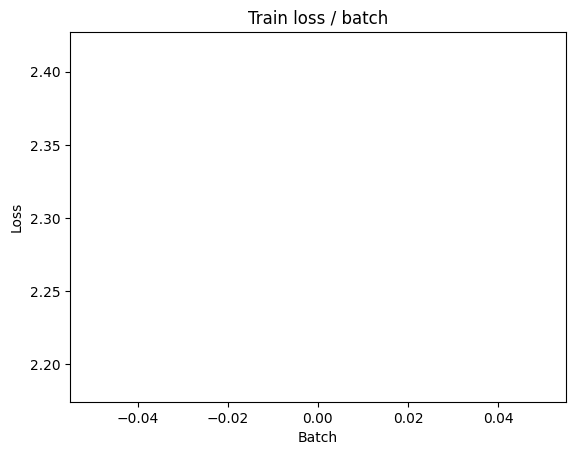

[TRAIN Batch 200/391]	Time 0.026s (0.045s)	Loss 2.1364 (2.2381)	Prec@1  22.7 ( 16.1)	Prec@5  71.1 ( 62.5)


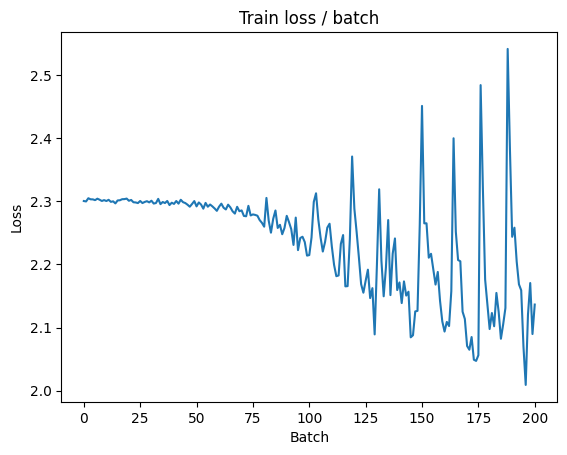


===============> Total time 14s	Avg loss 2.1112	Avg Prec@1 22.02 %	Avg Prec@5 70.42 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 1.7367 (1.7367)	Prec@1  37.5 ( 37.5)	Prec@5  86.7 ( 86.7)

===============> Total time 1s	Avg loss 1.7794	Avg Prec@1 35.17 %	Avg Prec@5 86.45 %



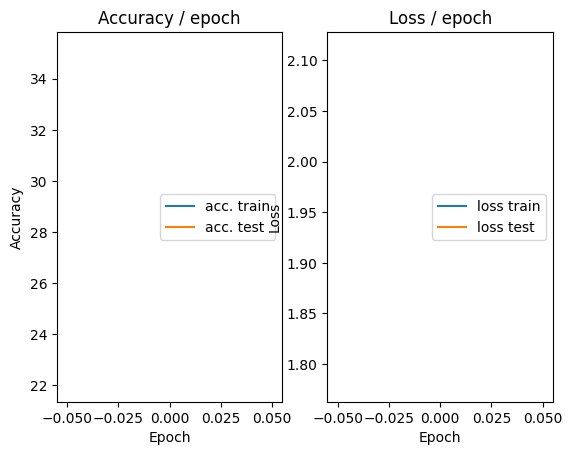

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.122s (0.122s)	Loss 1.8109 (1.8109)	Prec@1  33.6 ( 33.6)	Prec@5  85.2 ( 85.2)


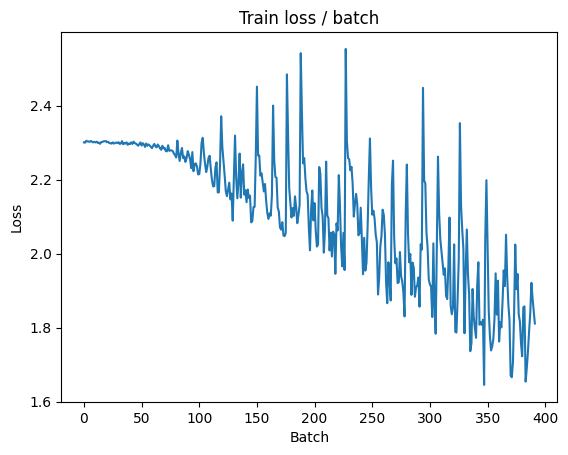

[TRAIN Batch 200/391]	Time 0.027s (0.023s)	Loss 1.5465 (1.7279)	Prec@1  39.8 ( 37.5)	Prec@5  93.8 ( 87.4)


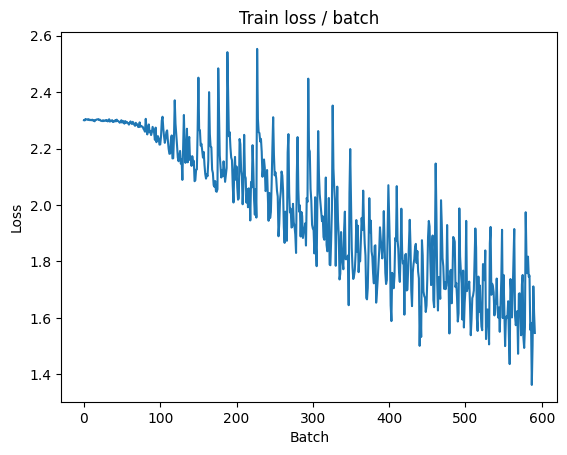


===============> Total time 9s	Avg loss 1.6506	Avg Prec@1 40.37 %	Avg Prec@5 88.79 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.5057 (1.5057)	Prec@1  43.0 ( 43.0)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.4911	Avg Prec@1 44.99 %	Avg Prec@5 91.83 %



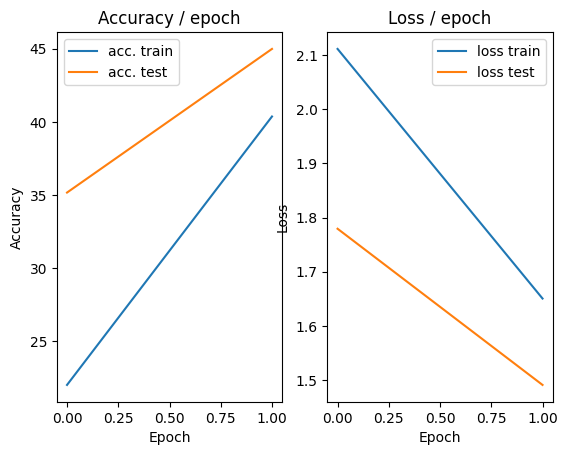

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.139s (0.139s)	Loss 1.4500 (1.4500)	Prec@1  46.1 ( 46.1)	Prec@5  91.4 ( 91.4)


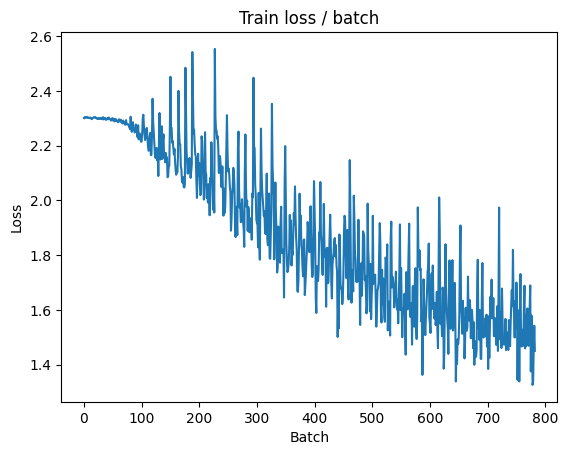

[TRAIN Batch 200/391]	Time 0.014s (0.023s)	Loss 1.5491 (1.4458)	Prec@1  48.4 ( 48.2)	Prec@5  91.4 ( 92.2)


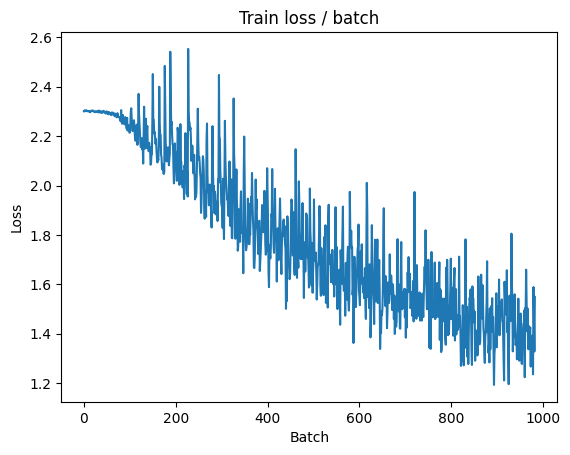


===============> Total time 8s	Avg loss 1.4109	Avg Prec@1 49.48 %	Avg Prec@5 92.72 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.2324 (1.2324)	Prec@1  60.2 ( 60.2)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.3338	Avg Prec@1 51.61 %	Avg Prec@5 93.87 %



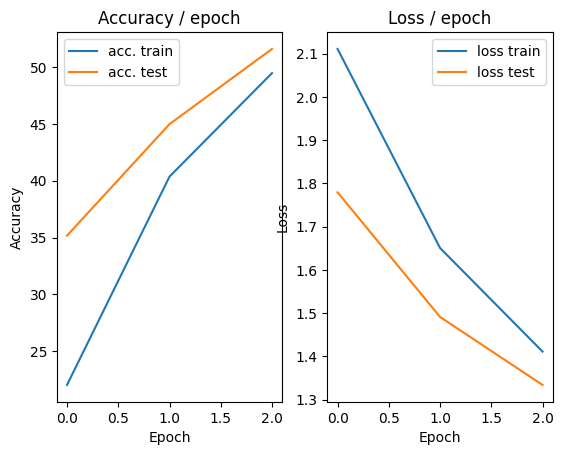

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.129s (0.129s)	Loss 1.4249 (1.4249)	Prec@1  41.4 ( 41.4)	Prec@5  93.0 ( 93.0)


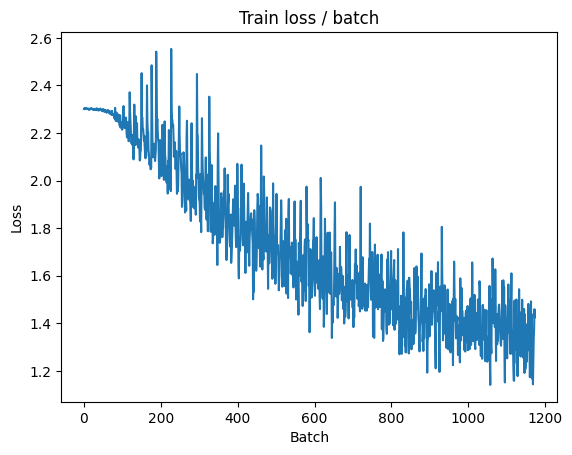

[TRAIN Batch 200/391]	Time 0.012s (0.024s)	Loss 1.2036 (1.2797)	Prec@1  53.1 ( 54.1)	Prec@5  93.8 ( 94.2)


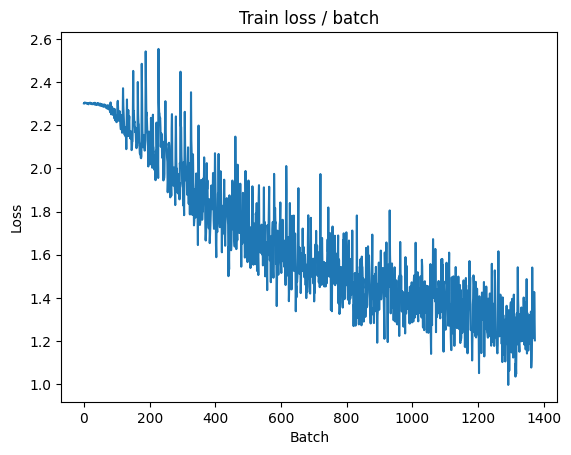


===============> Total time 9s	Avg loss 1.2481	Avg Prec@1 55.33 %	Avg Prec@5 94.60 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 0.9860 (0.9860)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.1816	Avg Prec@1 57.02 %	Avg Prec@5 95.60 %



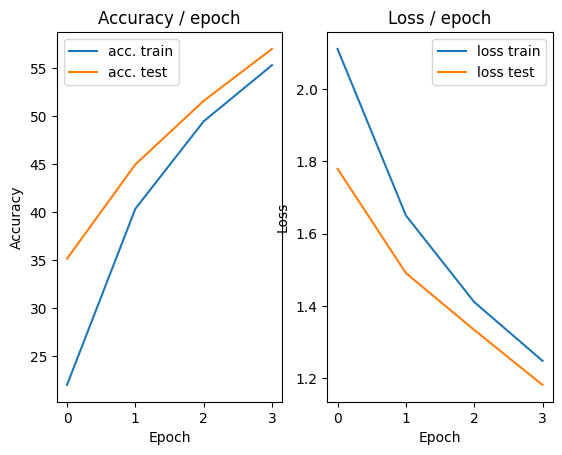

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.139s (0.139s)	Loss 1.0551 (1.0551)	Prec@1  58.6 ( 58.6)	Prec@5  97.7 ( 97.7)


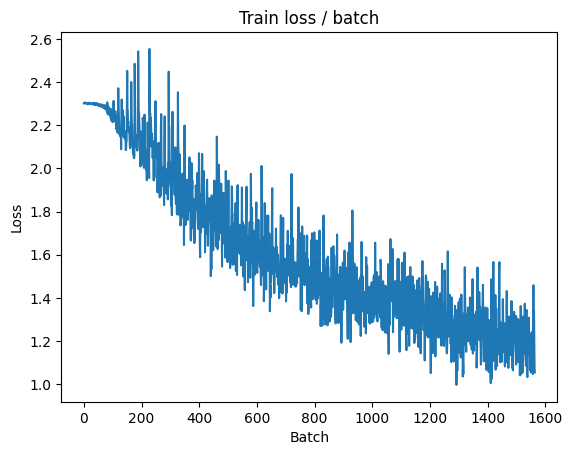

[TRAIN Batch 200/391]	Time 0.015s (0.027s)	Loss 1.1535 (1.1297)	Prec@1  63.3 ( 60.2)	Prec@5  94.5 ( 95.7)


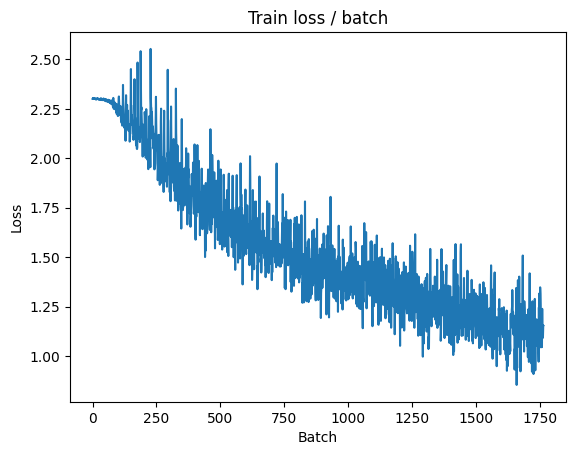


===============> Total time 9s	Avg loss 1.1183	Avg Prec@1 60.50 %	Avg Prec@5 95.82 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.9577 (0.9577)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.0876	Avg Prec@1 61.45 %	Avg Prec@5 96.49 %



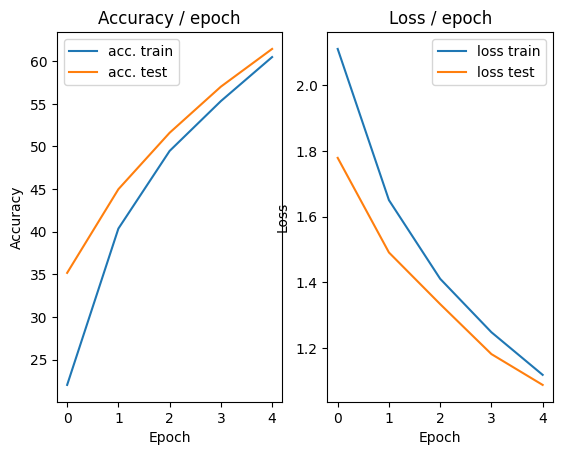

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.129s (0.129s)	Loss 1.0147 (1.0147)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)


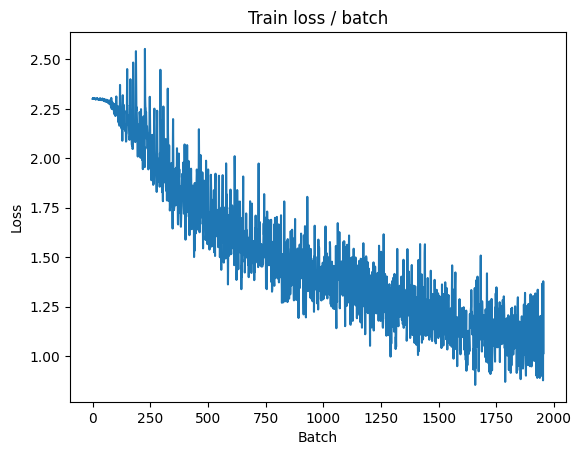

[TRAIN Batch 200/391]	Time 0.014s (0.024s)	Loss 0.9377 (1.0169)	Prec@1  68.0 ( 64.2)	Prec@5  97.7 ( 96.6)


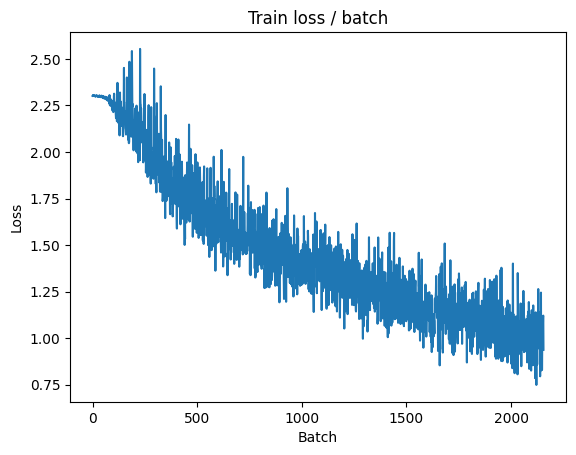


===============> Total time 8s	Avg loss 0.9963	Avg Prec@1 65.06 %	Avg Prec@5 96.77 %

[EVAL Batch 000/079]	Time 0.122s (0.122s)	Loss 0.9312 (0.9312)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.0095	Avg Prec@1 64.19 %	Avg Prec@5 96.87 %



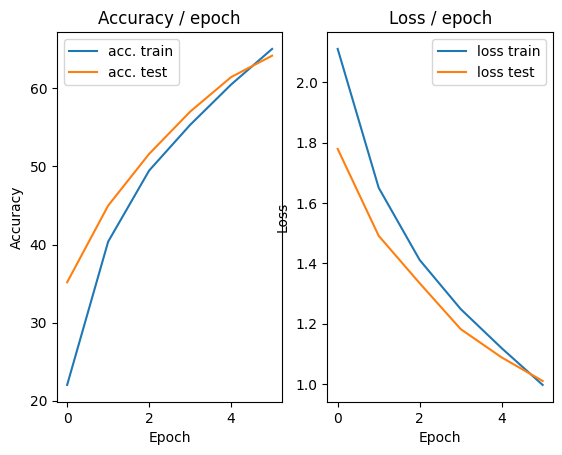

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.7475 (0.7475)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)


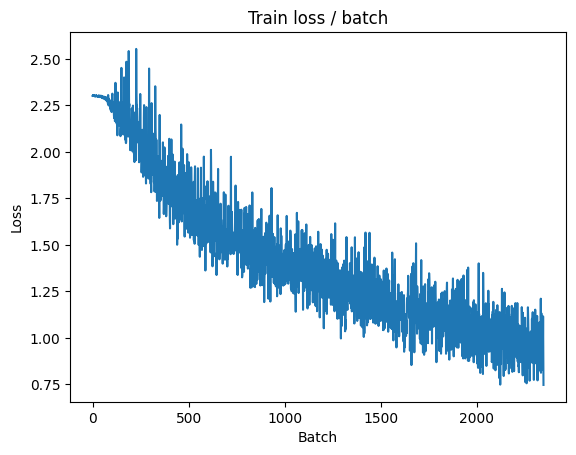

[TRAIN Batch 200/391]	Time 0.013s (0.025s)	Loss 0.8939 (0.8853)	Prec@1  68.0 ( 68.8)	Prec@5  97.7 ( 97.5)


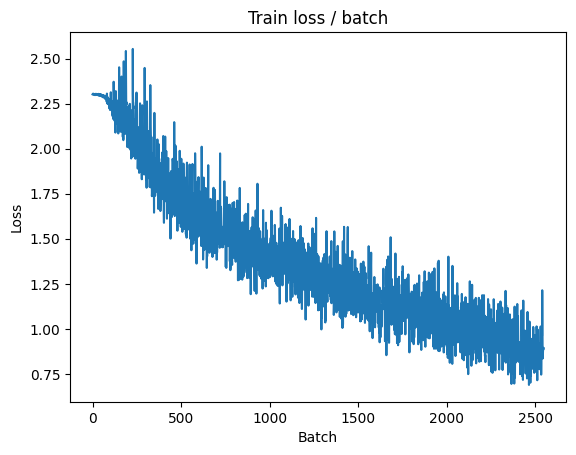


===============> Total time 9s	Avg loss 0.8833	Avg Prec@1 69.04 %	Avg Prec@5 97.59 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.9219 (0.9219)	Prec@1  68.8 ( 68.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0267	Avg Prec@1 64.01 %	Avg Prec@5 96.92 %



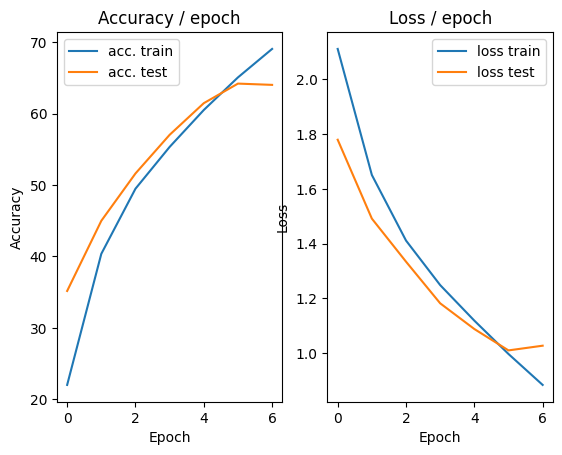

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 0.7581 (0.7581)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


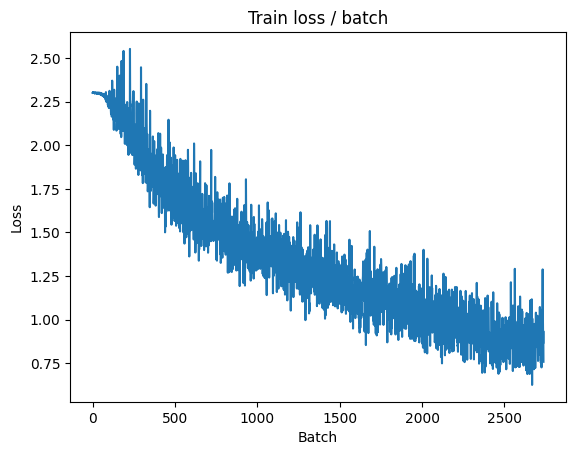

[TRAIN Batch 200/391]	Time 0.008s (0.027s)	Loss 0.7649 (0.7818)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)


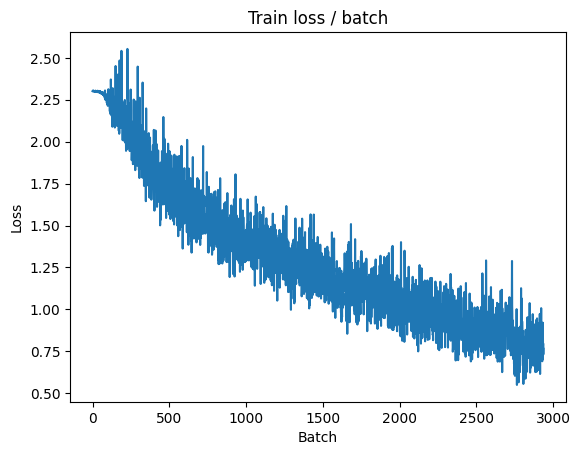


===============> Total time 9s	Avg loss 0.7802	Avg Prec@1 72.69 %	Avg Prec@5 98.36 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.9465 (0.9465)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9670	Avg Prec@1 66.09 %	Avg Prec@5 97.28 %



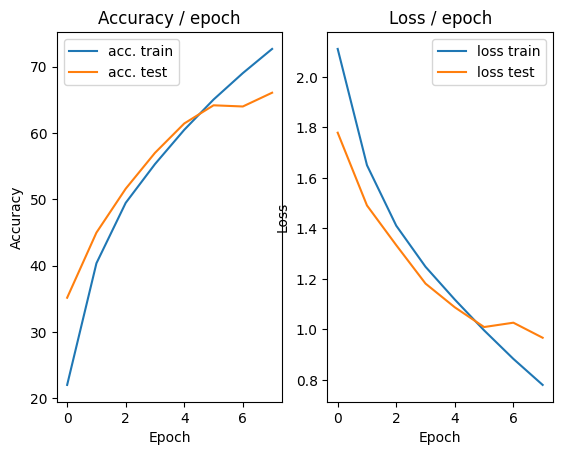

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.6293 (0.6293)	Prec@1  78.9 ( 78.9)	Prec@5 100.0 (100.0)


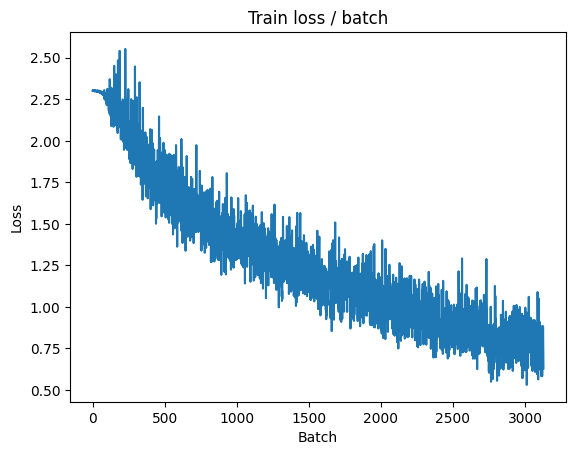

[TRAIN Batch 200/391]	Time 0.024s (0.028s)	Loss 0.8193 (0.6807)	Prec@1  70.3 ( 75.8)	Prec@5  98.4 ( 98.9)


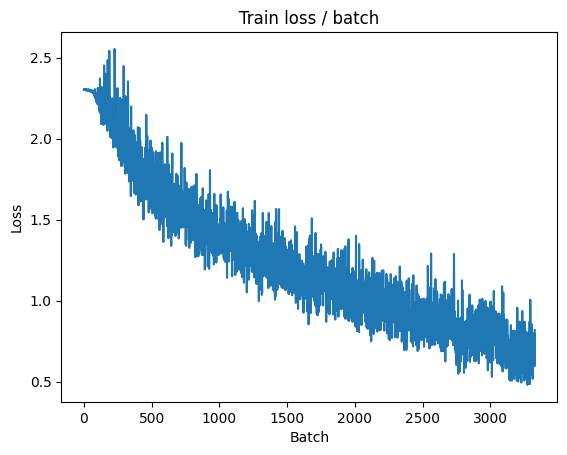


===============> Total time 9s	Avg loss 0.6872	Avg Prec@1 75.64 %	Avg Prec@5 98.70 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 0.9874 (0.9874)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0355	Avg Prec@1 65.03 %	Avg Prec@5 96.60 %



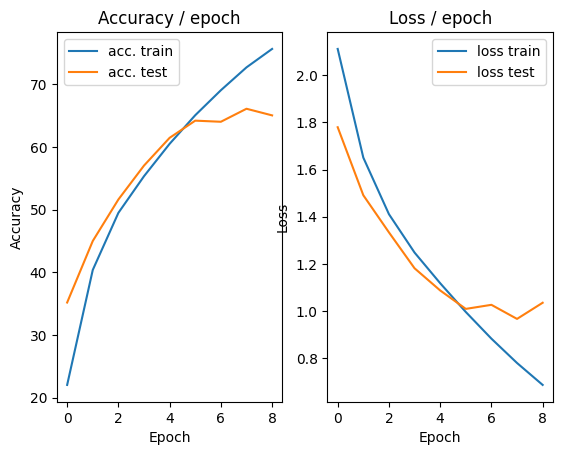

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 0.7473 (0.7473)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


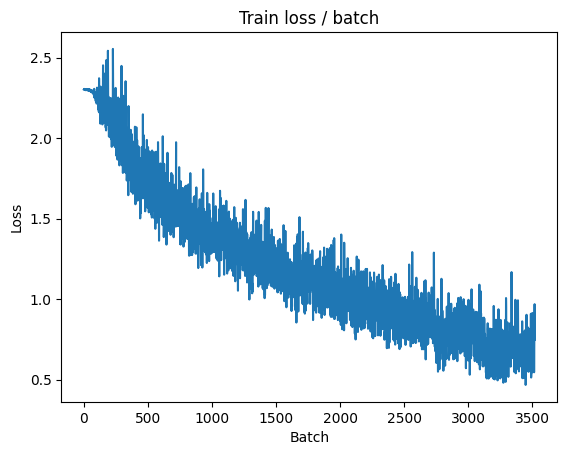

[TRAIN Batch 200/391]	Time 0.036s (0.028s)	Loss 0.4886 (0.5708)	Prec@1  81.2 ( 80.0)	Prec@5 100.0 ( 99.1)


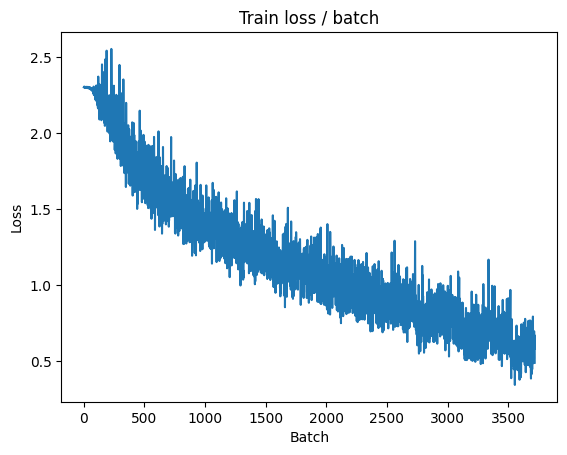


===============> Total time 9s	Avg loss 0.5869	Avg Prec@1 79.46 %	Avg Prec@5 99.08 %

[EVAL Batch 000/079]	Time 0.113s (0.113s)	Loss 0.9182 (0.9182)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9147	Avg Prec@1 69.97 %	Avg Prec@5 97.56 %



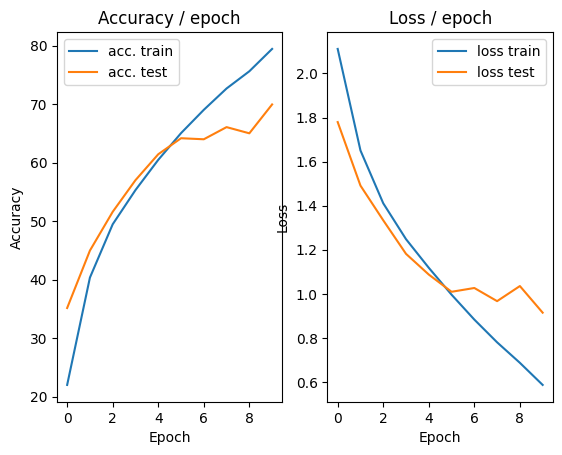

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.4008 (0.4008)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


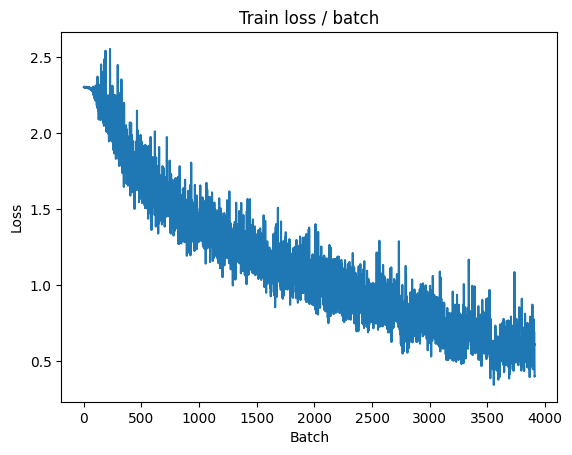

[TRAIN Batch 200/391]	Time 0.014s (0.029s)	Loss 0.4285 (0.4819)	Prec@1  83.6 ( 83.0)	Prec@5 100.0 ( 99.5)


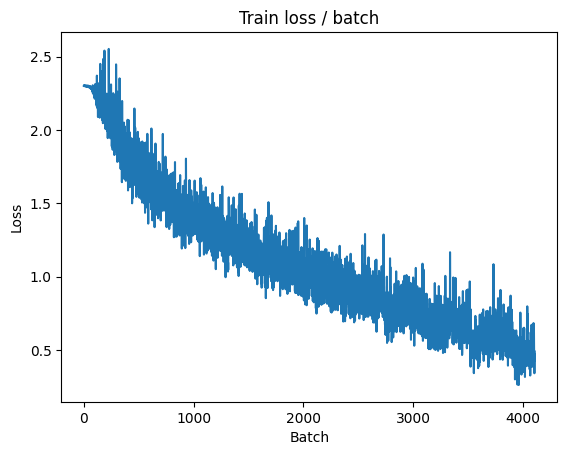


===============> Total time 9s	Avg loss 0.4889	Avg Prec@1 82.83 %	Avg Prec@5 99.42 %

[EVAL Batch 000/079]	Time 0.113s (0.113s)	Loss 0.9344 (0.9344)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0525	Avg Prec@1 67.49 %	Avg Prec@5 97.28 %



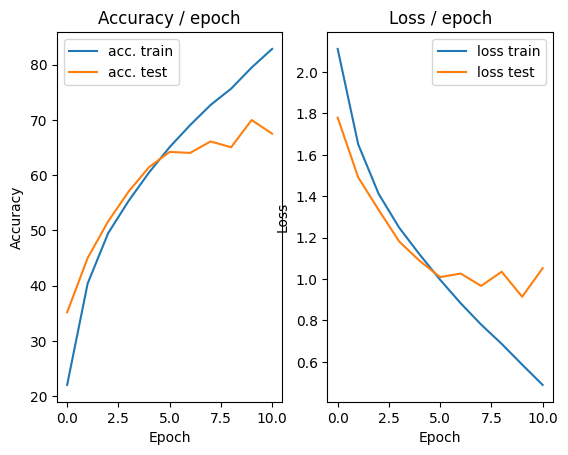

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.145s (0.145s)	Loss 0.4611 (0.4611)	Prec@1  82.0 ( 82.0)	Prec@5 100.0 (100.0)


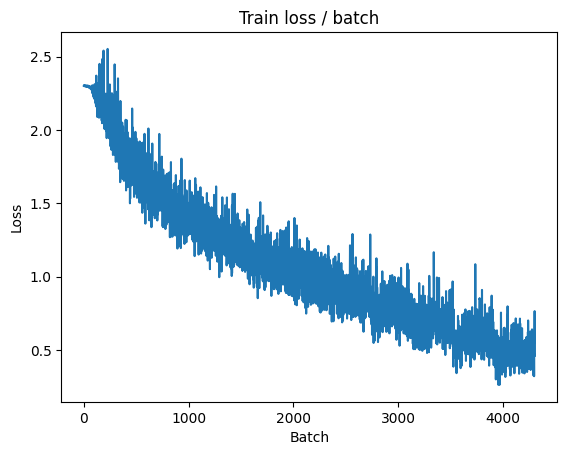

[TRAIN Batch 200/391]	Time 0.011s (0.029s)	Loss 0.3889 (0.3911)	Prec@1  85.9 ( 86.5)	Prec@5 100.0 ( 99.7)


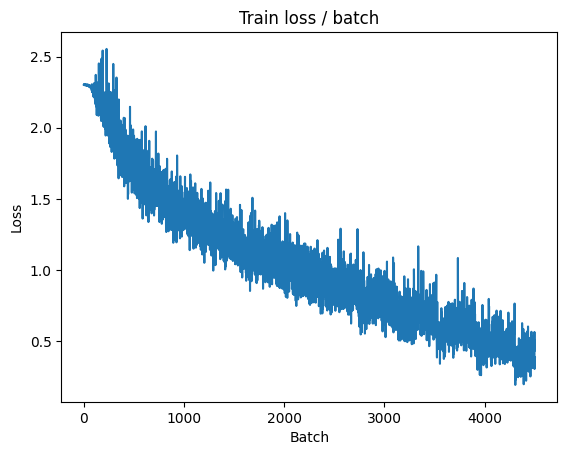


===============> Total time 10s	Avg loss 0.4046	Avg Prec@1 85.91 %	Avg Prec@5 99.66 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 1.0355 (1.0355)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0760	Avg Prec@1 68.34 %	Avg Prec@5 97.24 %



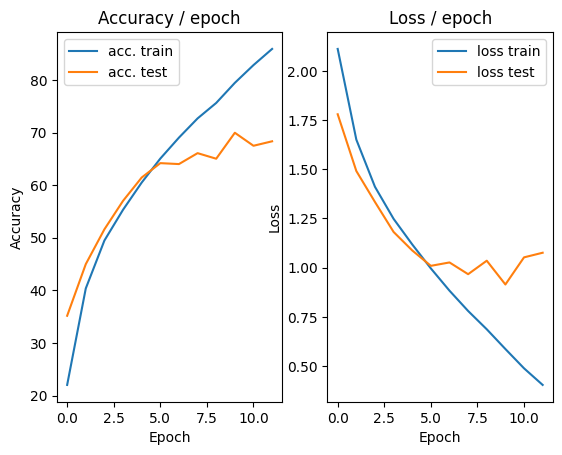

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.3359 (0.3359)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


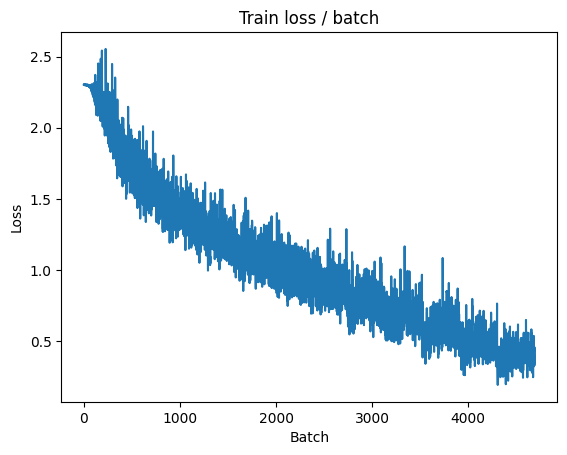

[TRAIN Batch 200/391]	Time 0.027s (0.028s)	Loss 0.2580 (0.2927)	Prec@1  92.2 ( 89.9)	Prec@5 100.0 ( 99.9)


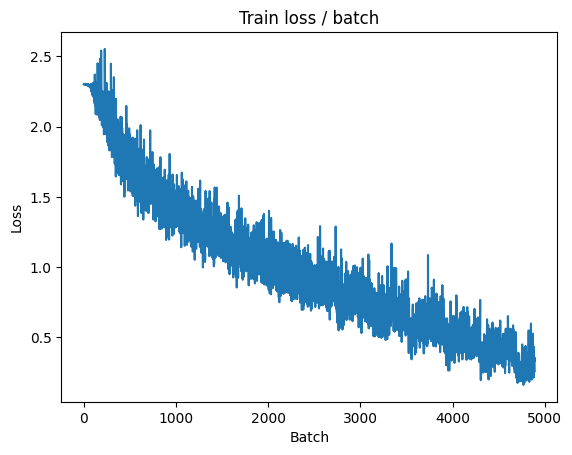


===============> Total time 9s	Avg loss 0.3106	Avg Prec@1 89.33 %	Avg Prec@5 99.84 %

[EVAL Batch 000/079]	Time 0.113s (0.113s)	Loss 1.0231 (1.0231)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0849	Avg Prec@1 70.09 %	Avg Prec@5 97.50 %



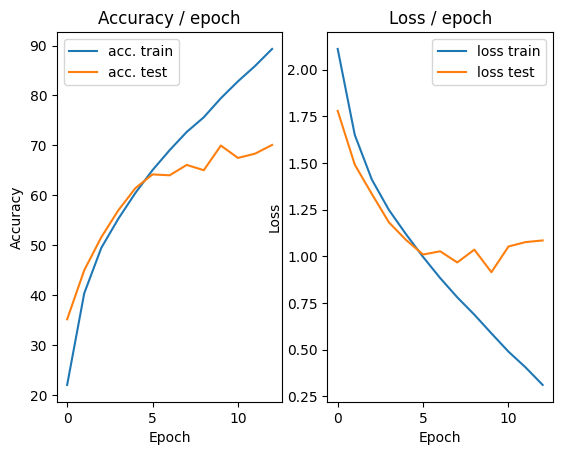

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.1970 (0.1970)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


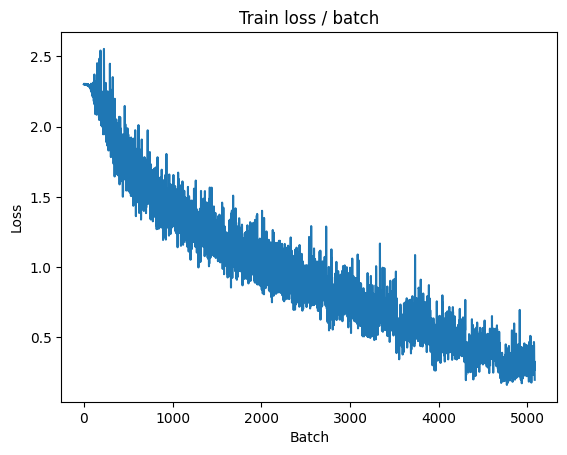

[TRAIN Batch 200/391]	Time 0.011s (0.029s)	Loss 0.2803 (0.2115)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 ( 99.9)


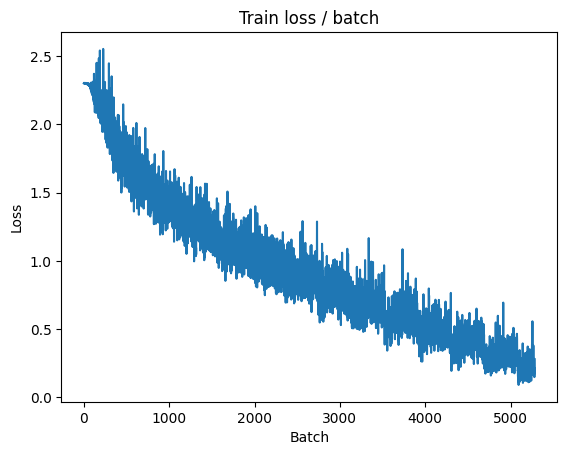


===============> Total time 10s	Avg loss 0.2397	Avg Prec@1 91.82 %	Avg Prec@5 99.90 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 0.9440 (0.9440)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.1505	Avg Prec@1 69.97 %	Avg Prec@5 97.28 %



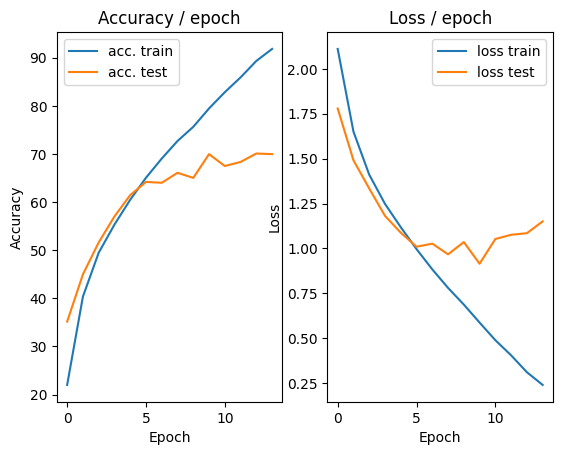

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.134s (0.134s)	Loss 0.1781 (0.1781)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


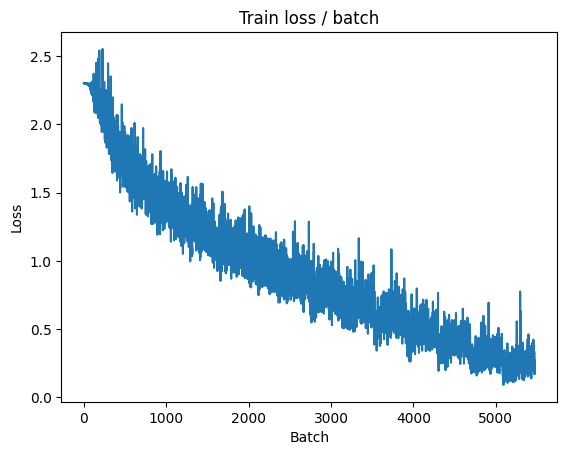

[TRAIN Batch 200/391]	Time 0.023s (0.026s)	Loss 0.0858 (0.1373)	Prec@1  97.7 ( 95.7)	Prec@5 100.0 (100.0)


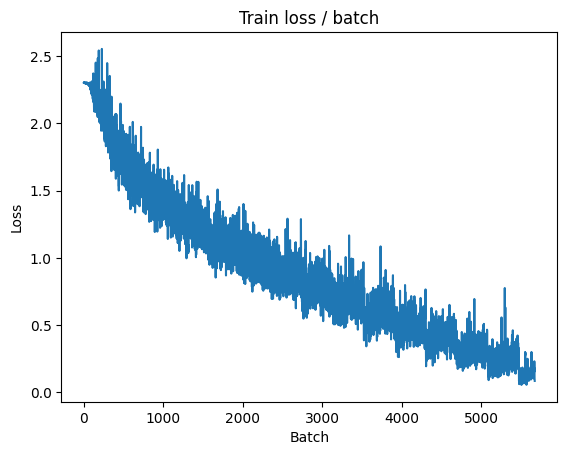


===============> Total time 9s	Avg loss 0.1706	Avg Prec@1 94.26 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.118s (0.118s)	Loss 1.2921 (1.2921)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.2199	Avg Prec@1 70.00 %	Avg Prec@5 97.27 %



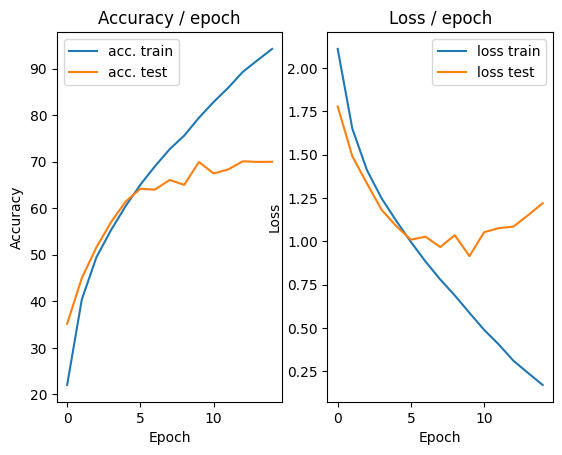

In [5]:
model= CIFAR10_ConvNet()
main(model,batch_size=128,lr=0.1,epochs=15,cuda=True,get_data = get_dataset)

- **Learning Rate**:

  - Effect on Convergence: The learning rate determines the step size at which the model's weights are updated during training. A high learning rate can lead to faster convergence, but it might also make the training process unstable, causing the loss to oscillate or diverge. Conversely, a very low learning rate may lead to very slow convergence and can get stuck in local minima.
  - Optimal Learning Rate: Finding the right learning rate is often a matter of experimentation. Techniques like learning rate schedules, learning rate annealing, or adaptive learning rates (e.g., Adam) can help adjust the learning rate during training to balance convergence speed and stability.
  - Regularization Effect: Higher learning rates can act as a form of regularization, helping to prevent overfitting to some extent by pushing the weights towards smaller values. This can be beneficial in some cases.

- **Batch Size**:

  - Effect on Training Time: The batch size determines how many training examples are used in each forward and backward pass. Larger batch sizes lead to faster training because they utilize parallelism and vectorization on hardware, but smaller batch sizes can provide more accurate updates to the model's weights.
  - Generalization vs. Speed: Smaller batch sizes tend to produce more accurate models because they provide a noisier gradient estimate in each iteration. This noise can have a regularizing effect, improving generalization. Larger batch sizes, on the other hand, can speed up training but might lead to worse generalization if overfitting is not controlled.
  - Memory and Hardware Constraints: Larger batch sizes require more memory and may not fit on some hardware, while smaller batch sizes are less memory-intensive and can be useful in scenarios where memory is limited.
  - Convergence Behavior: The batch size can influence the convergence behavior. In some cases, larger batch sizes may reach convergence with fewer epochs but at the cost of slower convergence within each epoch.

**Overfitting**: The primary issue is overfitting, which means the model has learned to fit the training data too closely, at the expense of generalization.

**Solutions**:
- Regularization: Use techniques like L1 or L2 regularization to constrain the model's weights and prevent overfitting.
- Dropout: Apply dropout during training, which randomly deactivates neurons, preventing them from over-relying on specific features.
- Early Stopping: Monitor the testing loss and stop training when it starts to increase, indicating that further training is detrimental.
- More Data: If possible, collect more training data to help the model generalize better.


## Results Improvements

### Standardization of exemples

In [6]:
def get_dataset_normalized(batch_size,cuda=False):

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,transform=
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447),(0.202,0.199, 0.201))
        ]))


    val_dataset = datasets.CIFAR10(PATH, train=True, download=True,transform=
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447),(0.202,0.199, 0.201))
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)


    return train_loader, val_loader
1

1

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 2.3013 (2.3013)	Prec@1   7.8 (  7.8)	Prec@5  50.0 ( 50.0)


<Figure size 640x480 with 0 Axes>

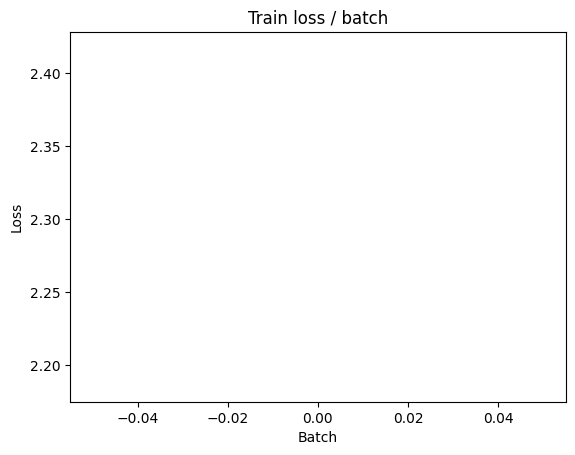

[TRAIN Batch 200/391]	Time 0.080s (0.039s)	Loss 1.7618 (1.8882)	Prec@1  29.7 ( 31.0)	Prec@5  87.5 ( 81.3)


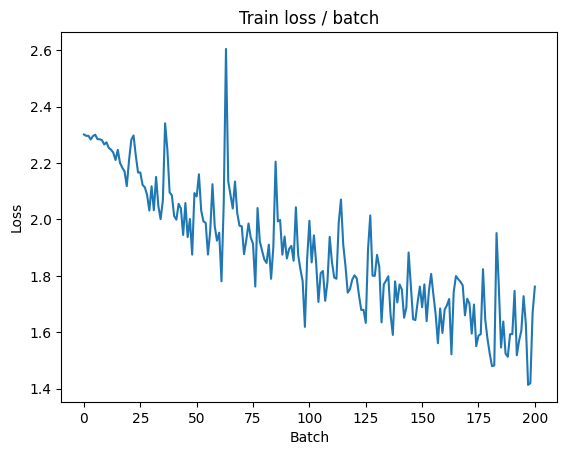


===============> Total time 14s	Avg loss 1.7110	Avg Prec@1 37.92 %	Avg Prec@5 86.30 %

[EVAL Batch 000/391]	Time 0.138s (0.138s)	Loss 1.3116 (1.3116)	Prec@1  54.7 ( 54.7)	Prec@5  92.2 ( 92.2)
[EVAL Batch 200/391]	Time 0.057s (0.036s)	Loss 1.4505 (1.5395)	Prec@1  43.8 ( 45.6)	Prec@5  93.8 ( 92.1)

===============> Total time 12s	Avg loss 1.5435	Avg Prec@1 45.29 %	Avg Prec@5 92.13 %



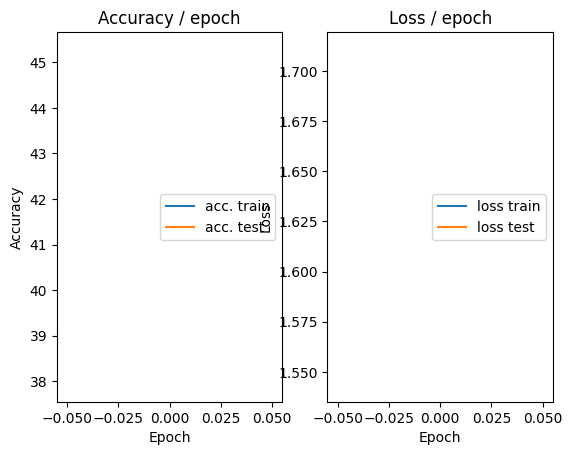

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 1.5435 (1.5435)	Prec@1  46.1 ( 46.1)	Prec@5  92.2 ( 92.2)


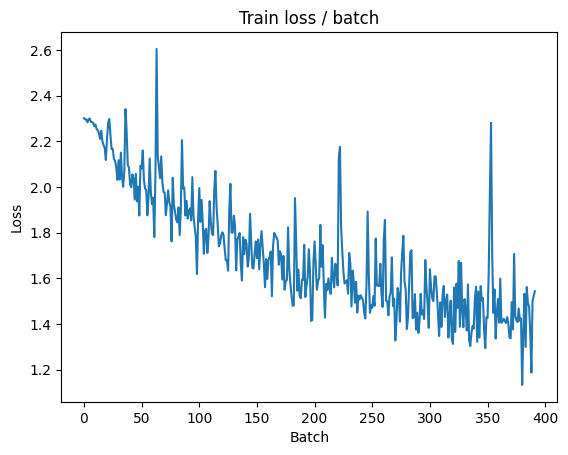

[TRAIN Batch 200/391]	Time 0.009s (0.039s)	Loss 1.2442 (1.3288)	Prec@1  56.2 ( 52.6)	Prec@5  93.8 ( 93.8)


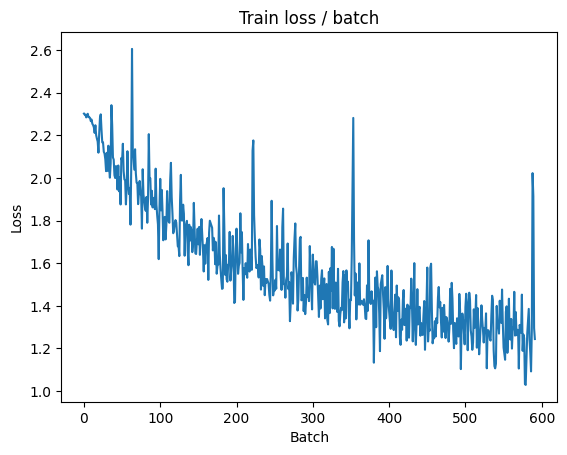


===============> Total time 14s	Avg loss 1.2622	Avg Prec@1 55.06 %	Avg Prec@5 94.66 %

[EVAL Batch 000/391]	Time 0.147s (0.147s)	Loss 1.0852 (1.0852)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)
[EVAL Batch 200/391]	Time 0.003s (0.031s)	Loss 1.1877 (1.0767)	Prec@1  57.8 ( 61.7)	Prec@5  95.3 ( 96.6)

===============> Total time 12s	Avg loss 1.0795	Avg Prec@1 61.70 %	Avg Prec@5 96.58 %



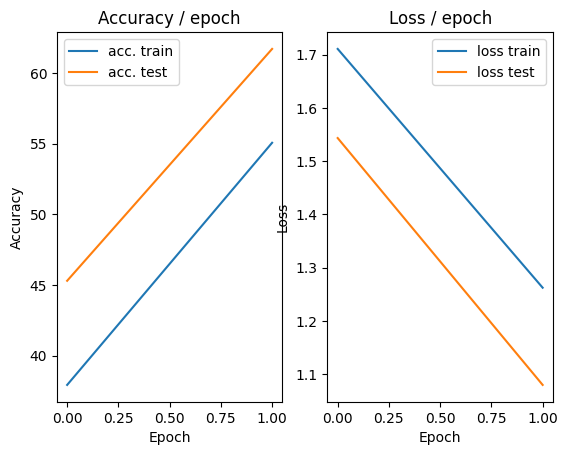

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.164s (0.164s)	Loss 0.8812 (0.8812)	Prec@1  68.0 ( 68.0)	Prec@5  97.7 ( 97.7)


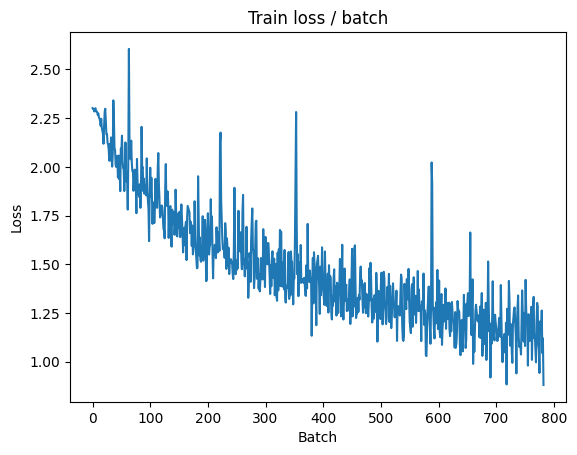

[TRAIN Batch 200/391]	Time 0.022s (0.034s)	Loss 1.1116 (1.0630)	Prec@1  60.9 ( 62.4)	Prec@5  97.7 ( 96.5)


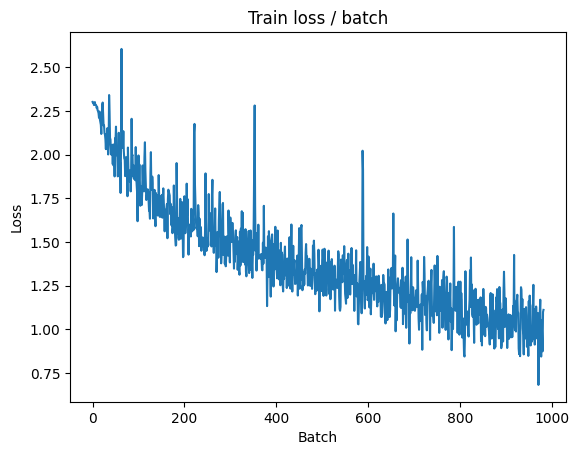


===============> Total time 14s	Avg loss 1.0247	Avg Prec@1 63.97 %	Avg Prec@5 96.77 %

[EVAL Batch 000/391]	Time 0.138s (0.138s)	Loss 0.9245 (0.9245)	Prec@1  71.1 ( 71.1)	Prec@5  93.8 ( 93.8)
[EVAL Batch 200/391]	Time 0.051s (0.030s)	Loss 1.1508 (0.9843)	Prec@1  57.0 ( 65.7)	Prec@5  93.0 ( 96.5)

===============> Total time 12s	Avg loss 0.9826	Avg Prec@1 65.83 %	Avg Prec@5 96.51 %



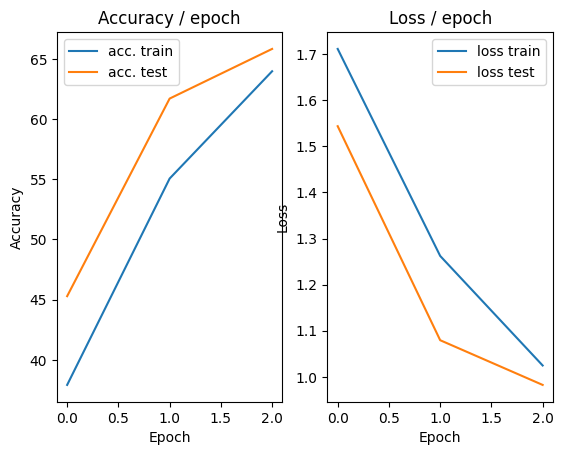

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.9396 (0.9396)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)


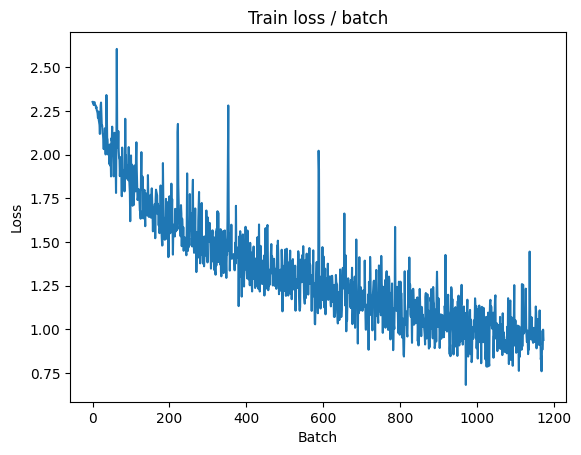

[TRAIN Batch 200/391]	Time 0.016s (0.034s)	Loss 0.9589 (0.8655)	Prec@1  65.6 ( 69.5)	Prec@5  97.7 ( 97.7)


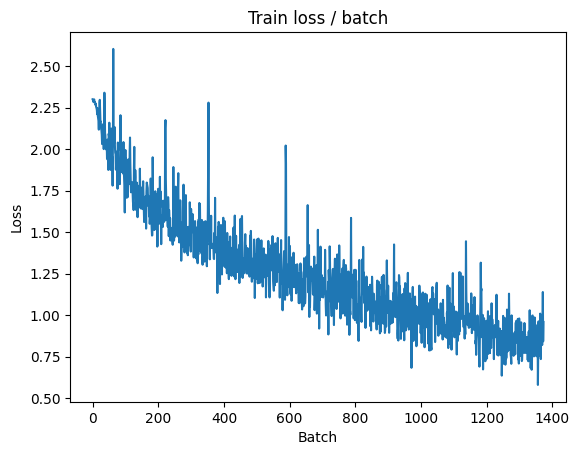


===============> Total time 14s	Avg loss 0.8540	Avg Prec@1 70.06 %	Avg Prec@5 97.73 %

[EVAL Batch 000/391]	Time 0.151s (0.151s)	Loss 0.6892 (0.6892)	Prec@1  77.3 ( 77.3)	Prec@5  96.1 ( 96.1)
[EVAL Batch 200/391]	Time 0.062s (0.030s)	Loss 0.8085 (0.7183)	Prec@1  71.1 ( 75.0)	Prec@5  98.4 ( 98.4)

===============> Total time 12s	Avg loss 0.7185	Avg Prec@1 75.09 %	Avg Prec@5 98.46 %



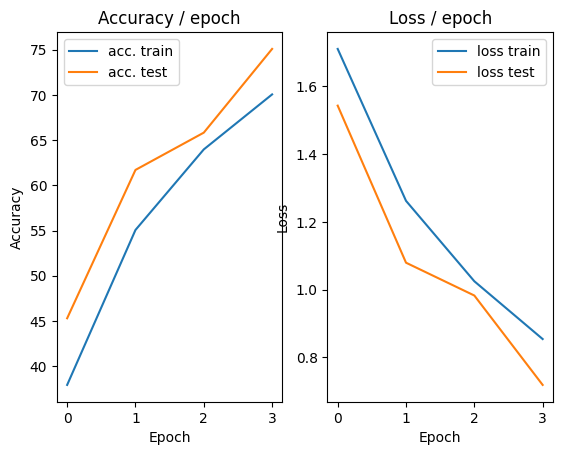

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.6883 (0.6883)	Prec@1  74.2 ( 74.2)	Prec@5 100.0 (100.0)


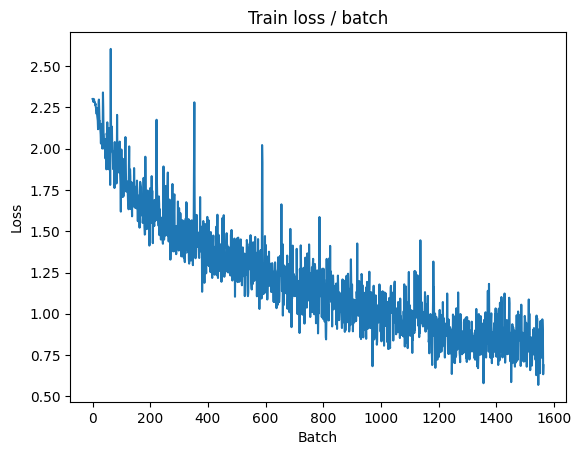

[TRAIN Batch 200/391]	Time 0.064s (0.036s)	Loss 0.6913 (0.7175)	Prec@1  77.3 ( 75.0)	Prec@5  97.7 ( 98.5)


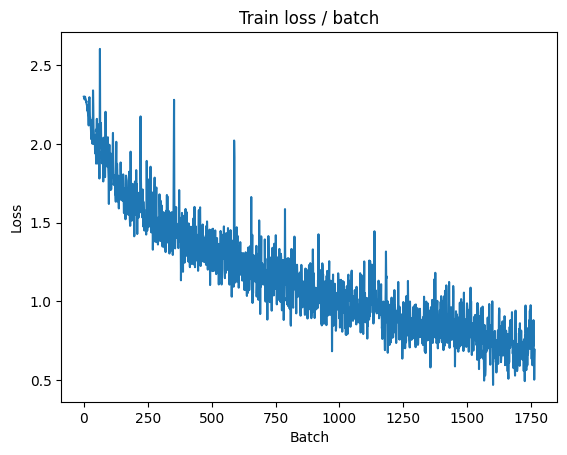


===============> Total time 14s	Avg loss 0.7180	Avg Prec@1 74.85 %	Avg Prec@5 98.49 %

[EVAL Batch 000/391]	Time 0.138s (0.138s)	Loss 0.5942 (0.5942)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)
[EVAL Batch 200/391]	Time 0.102s (0.035s)	Loss 0.6737 (0.6103)	Prec@1  73.4 ( 78.2)	Prec@5  97.7 ( 99.0)

===============> Total time 12s	Avg loss 0.6068	Avg Prec@1 78.26 %	Avg Prec@5 98.98 %



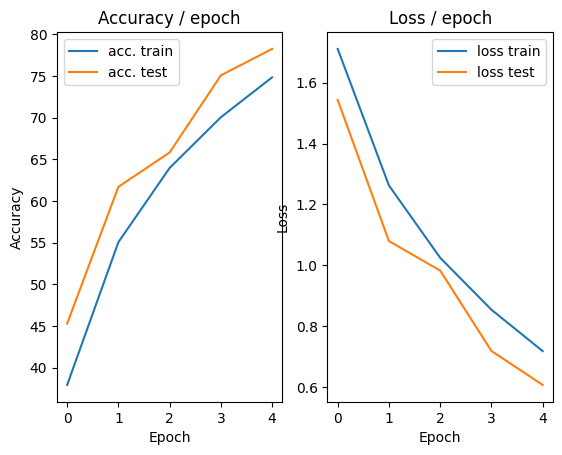

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.5778 (0.5778)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)


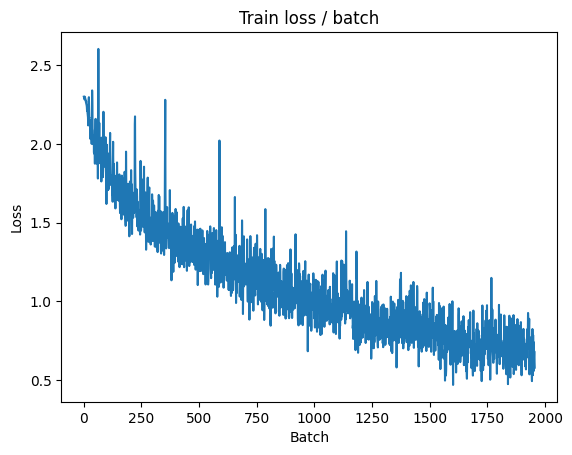

[TRAIN Batch 200/391]	Time 0.039s (0.039s)	Loss 0.5484 (0.5877)	Prec@1  82.0 ( 79.4)	Prec@5 100.0 ( 99.1)


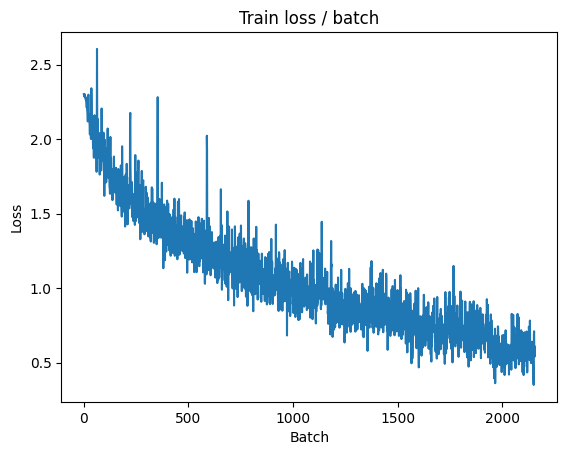


===============> Total time 13s	Avg loss 0.5994	Avg Prec@1 79.10 %	Avg Prec@5 99.04 %

[EVAL Batch 000/391]	Time 0.135s (0.135s)	Loss 0.4422 (0.4422)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.004s (0.034s)	Loss 0.5325 (0.4814)	Prec@1  82.0 ( 83.9)	Prec@5  99.2 ( 99.4)

===============> Total time 12s	Avg loss 0.4796	Avg Prec@1 83.93 %	Avg Prec@5 99.42 %



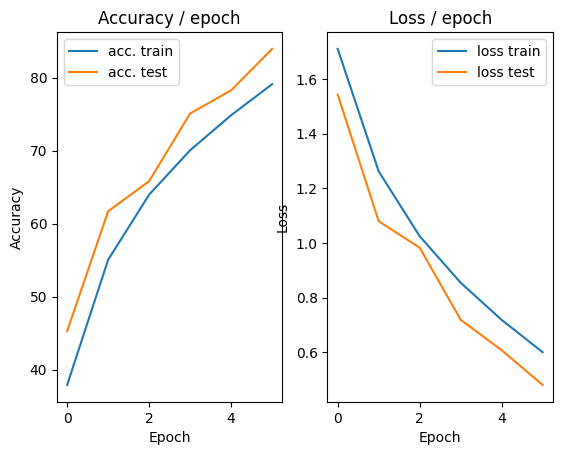

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.4752 (0.4752)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)


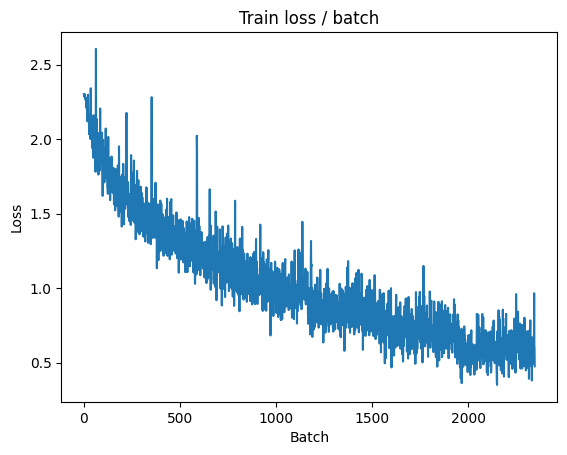

[TRAIN Batch 200/391]	Time 0.060s (0.039s)	Loss 0.6554 (0.4789)	Prec@1  75.0 ( 83.4)	Prec@5 100.0 ( 99.4)


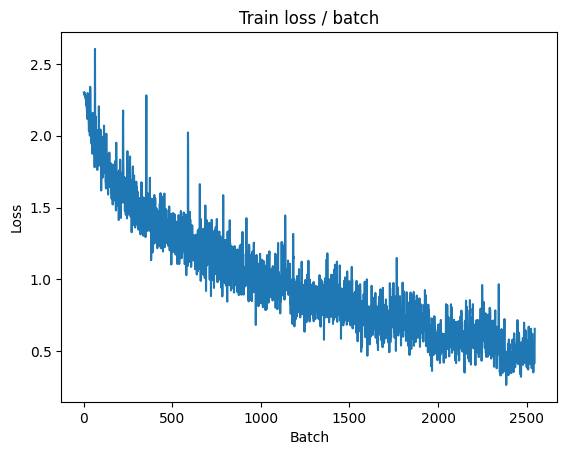


===============> Total time 14s	Avg loss 0.4861	Avg Prec@1 83.00 %	Avg Prec@5 99.42 %

[EVAL Batch 000/391]	Time 0.151s (0.151s)	Loss 0.3454 (0.3454)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.003s (0.037s)	Loss 0.4118 (0.3706)	Prec@1  85.9 ( 87.5)	Prec@5 100.0 ( 99.8)

===============> Total time 13s	Avg loss 0.3662	Avg Prec@1 87.77 %	Avg Prec@5 99.76 %



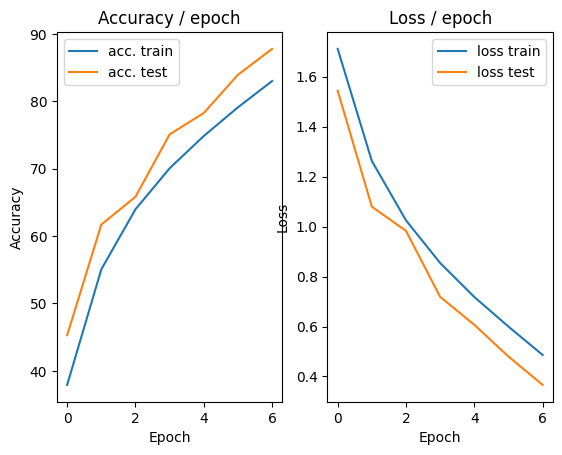

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.219s (0.219s)	Loss 0.2699 (0.2699)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


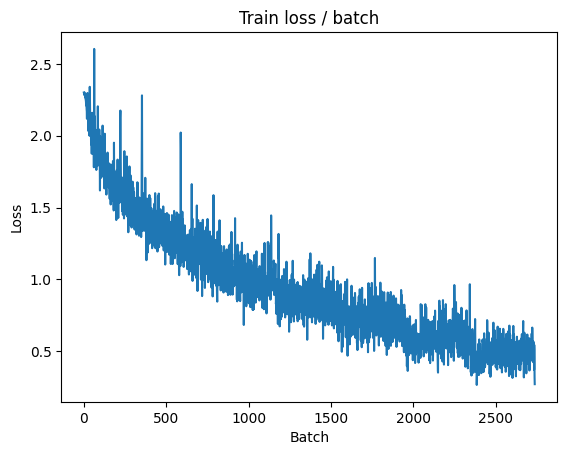

[TRAIN Batch 200/391]	Time 0.068s (0.040s)	Loss 0.2407 (0.3698)	Prec@1  92.2 ( 87.1)	Prec@5 100.0 ( 99.6)


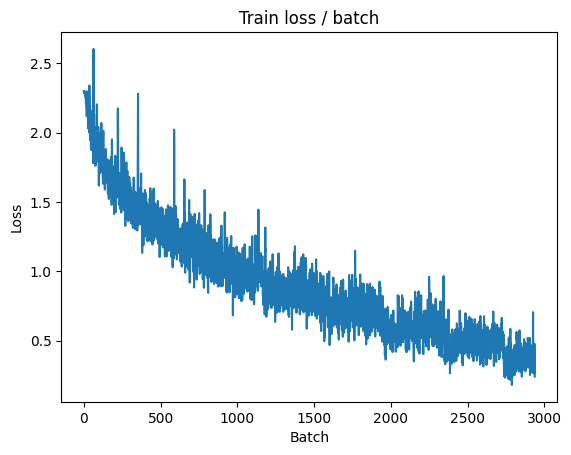


===============> Total time 15s	Avg loss 0.3859	Avg Prec@1 86.57 %	Avg Prec@5 99.62 %

[EVAL Batch 000/391]	Time 0.210s (0.210s)	Loss 0.2484 (0.2484)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.006s (0.031s)	Loss 0.2987 (0.2972)	Prec@1  92.2 ( 90.3)	Prec@5  99.2 ( 99.8)

===============> Total time 12s	Avg loss 0.2972	Avg Prec@1 90.25 %	Avg Prec@5 99.84 %



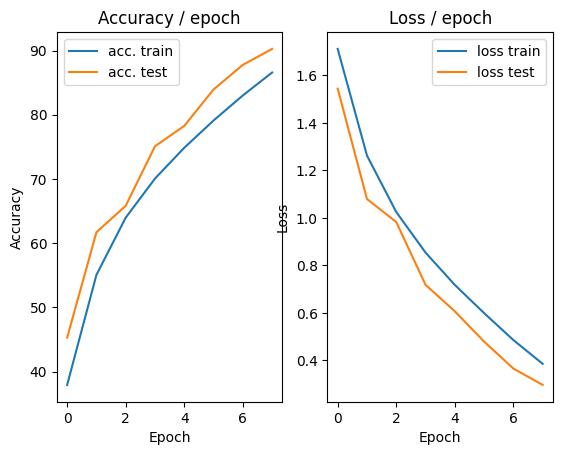

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.2921 (0.2921)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


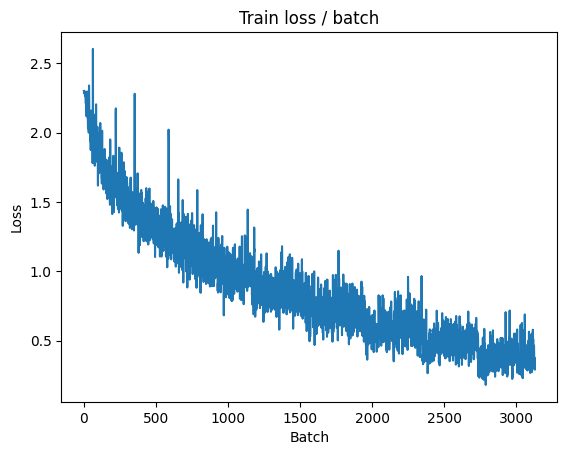

[TRAIN Batch 200/391]	Time 0.042s (0.035s)	Loss 0.3461 (0.2746)	Prec@1  89.1 ( 90.4)	Prec@5 100.0 ( 99.9)


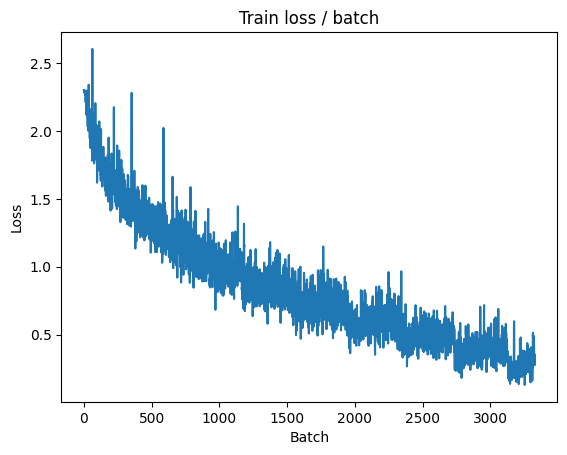


===============> Total time 14s	Avg loss 0.2942	Avg Prec@1 89.71 %	Avg Prec@5 99.84 %

[EVAL Batch 000/391]	Time 0.143s (0.143s)	Loss 0.2188 (0.2188)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.004s (0.031s)	Loss 0.3110 (0.2418)	Prec@1  92.2 ( 91.5)	Prec@5  99.2 ( 99.9)

===============> Total time 12s	Avg loss 0.2412	Avg Prec@1 91.66 %	Avg Prec@5 99.94 %



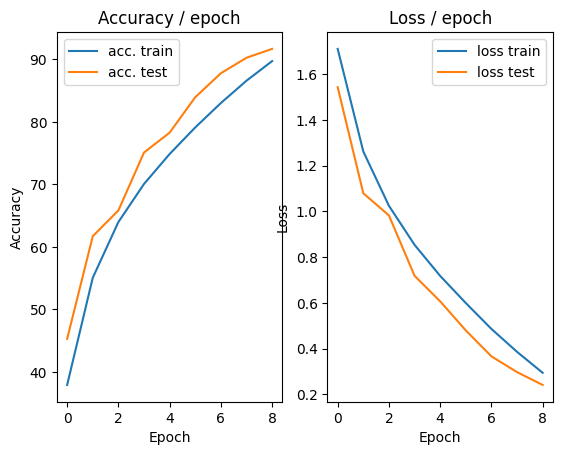

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 0.2210 (0.2210)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


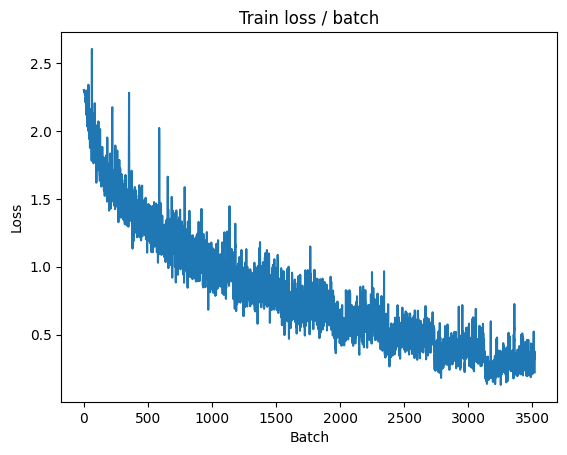

[TRAIN Batch 200/391]	Time 0.016s (0.034s)	Loss 0.2281 (0.1749)	Prec@1  91.4 ( 94.2)	Prec@5 100.0 (100.0)


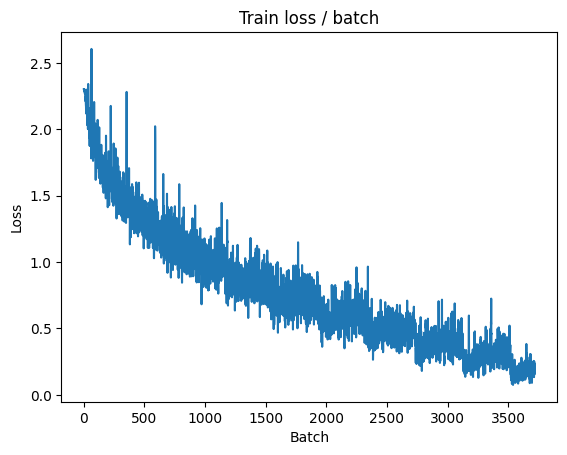


===============> Total time 14s	Avg loss 0.2027	Avg Prec@1 93.10 %	Avg Prec@5 99.94 %

[EVAL Batch 000/391]	Time 0.143s (0.143s)	Loss 0.1328 (0.1328)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.050s (0.030s)	Loss 0.1909 (0.1836)	Prec@1  93.8 ( 93.6)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.1841	Avg Prec@1 93.56 %	Avg Prec@5 99.97 %



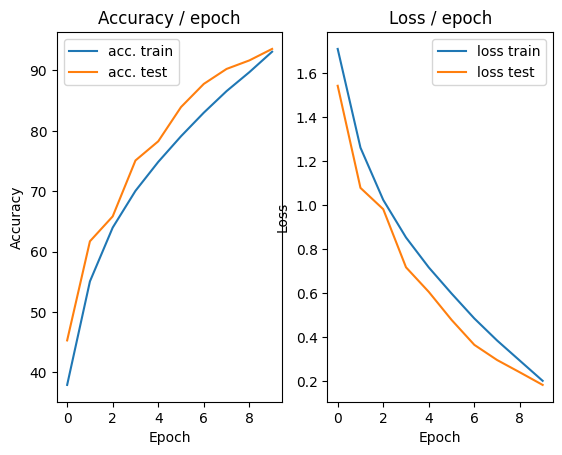

In [7]:
model= CIFAR10_ConvNet()
main(model,batch_size=128,lr=0.1,epochs=10,cuda=True,get_data=get_dataset_normalized)

We observe a remarkable absence of oscillations in the accuracy and loss curves, especially in the context of the test data. The curves for both training and testing data in terms of accuracy and loss exhibit striking similarities. This similarity suggests that the applied normalization techniques have effectively eliminated the overfitting issue we encountered just before.

## Increase in the number of training examples by data increase

In [8]:
def get_dataset_increased(batch_size,cuda=False):

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,transform=
        transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip()
        ]))


    val_dataset = datasets.CIFAR10(PATH, train=True, download=True,transform=
        transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(28)

        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)


    return train_loader, val_loader

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.397s (0.397s)	Loss 2.3033 (2.3033)	Prec@1   7.8 (  7.8)	Prec@5  53.1 ( 53.1)


<Figure size 640x480 with 0 Axes>

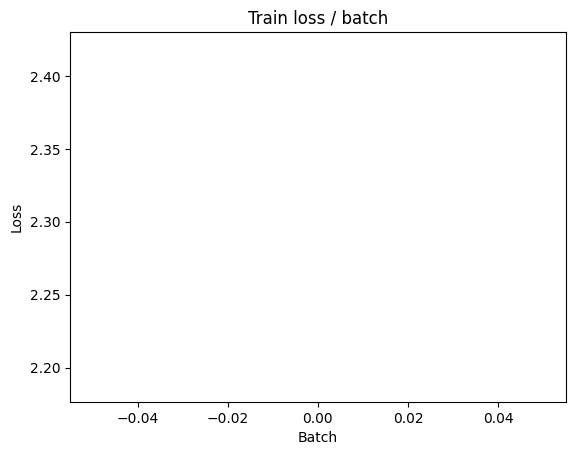

[TRAIN Batch 200/391]	Time 0.015s (0.039s)	Loss 2.2146 (2.2658)	Prec@1  12.5 ( 13.6)	Prec@5  62.5 ( 59.6)


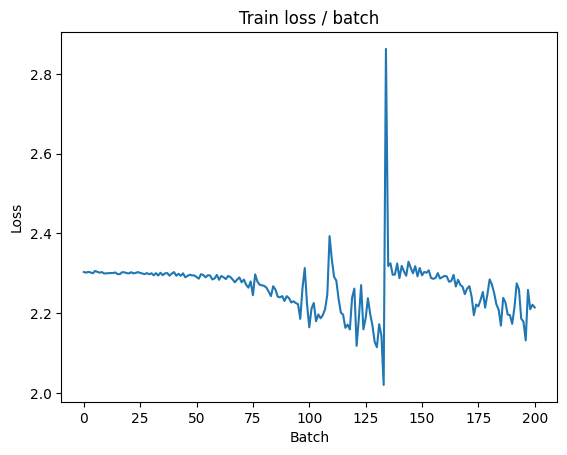


===============> Total time 14s	Avg loss 2.1932	Avg Prec@1 18.06 %	Avg Prec@5 65.87 %

[EVAL Batch 000/391]	Time 0.118s (0.118s)	Loss 1.9343 (1.9343)	Prec@1  25.8 ( 25.8)	Prec@5  83.6 ( 83.6)
[EVAL Batch 200/391]	Time 0.003s (0.028s)	Loss 1.9656 (1.8990)	Prec@1  27.3 ( 30.7)	Prec@5  78.1 ( 82.2)

===============> Total time 10s	Avg loss 1.9059	Avg Prec@1 30.24 %	Avg Prec@5 81.75 %



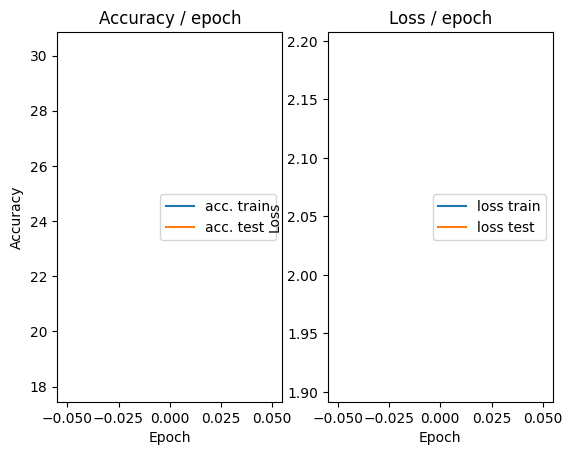

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.8058 (1.8058)	Prec@1  31.2 ( 31.2)	Prec@5  89.1 ( 89.1)


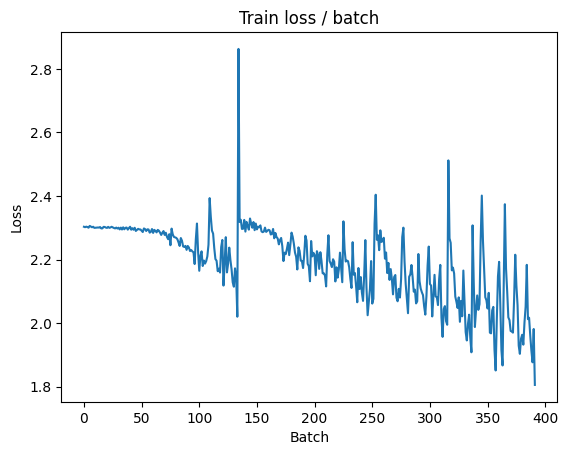

[TRAIN Batch 200/391]	Time 0.048s (0.039s)	Loss 1.7912 (1.9266)	Prec@1  29.7 ( 30.3)	Prec@5  89.8 ( 81.8)


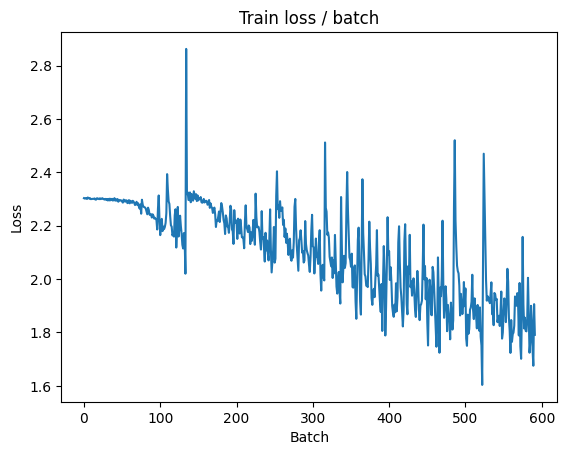


===============> Total time 14s	Avg loss 1.8398	Avg Prec@1 33.19 %	Avg Prec@5 84.23 %

[EVAL Batch 000/391]	Time 0.122s (0.122s)	Loss 1.4994 (1.4994)	Prec@1  43.0 ( 43.0)	Prec@5  93.0 ( 93.0)
[EVAL Batch 200/391]	Time 0.003s (0.029s)	Loss 1.6651 (1.6754)	Prec@1  37.5 ( 38.2)	Prec@5  90.6 ( 88.8)

===============> Total time 10s	Avg loss 1.6781	Avg Prec@1 38.10 %	Avg Prec@5 88.87 %



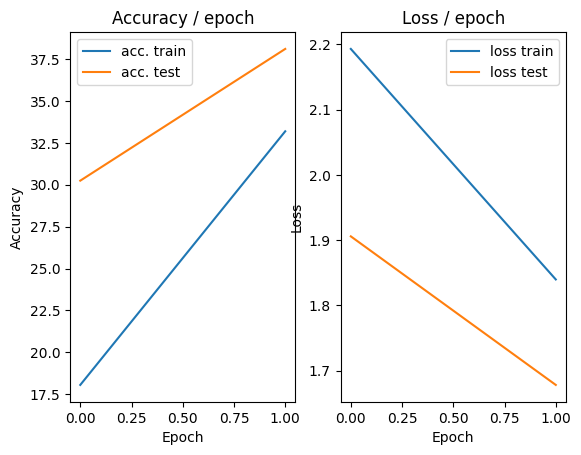

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.6547 (1.6547)	Prec@1  39.8 ( 39.8)	Prec@5  89.1 ( 89.1)


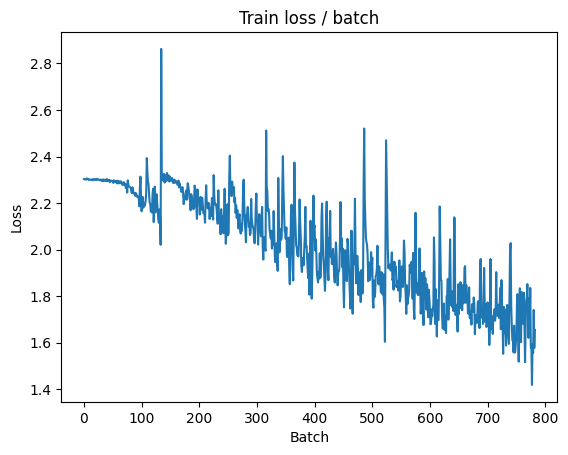

[TRAIN Batch 200/391]	Time 0.075s (0.041s)	Loss 1.5687 (1.6515)	Prec@1  44.5 ( 39.5)	Prec@5  92.2 ( 89.0)


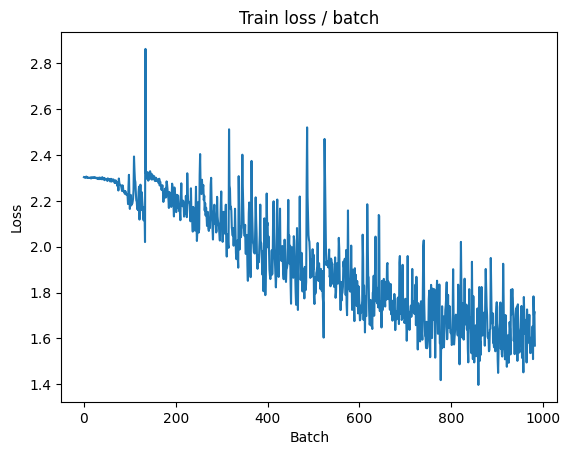


===============> Total time 14s	Avg loss 1.6008	Avg Prec@1 41.55 %	Avg Prec@5 89.73 %

[EVAL Batch 000/391]	Time 0.125s (0.125s)	Loss 1.7560 (1.7560)	Prec@1  38.3 ( 38.3)	Prec@5  81.2 ( 81.2)
[EVAL Batch 200/391]	Time 0.027s (0.029s)	Loss 1.8217 (1.8111)	Prec@1  28.9 ( 37.7)	Prec@5  82.0 ( 83.4)

===============> Total time 10s	Avg loss 1.8145	Avg Prec@1 37.46 %	Avg Prec@5 83.51 %



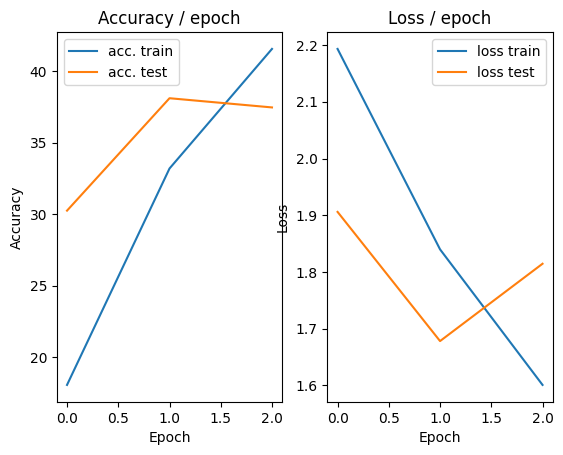

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 1.9169 (1.9169)	Prec@1  33.6 ( 33.6)	Prec@5  82.0 ( 82.0)


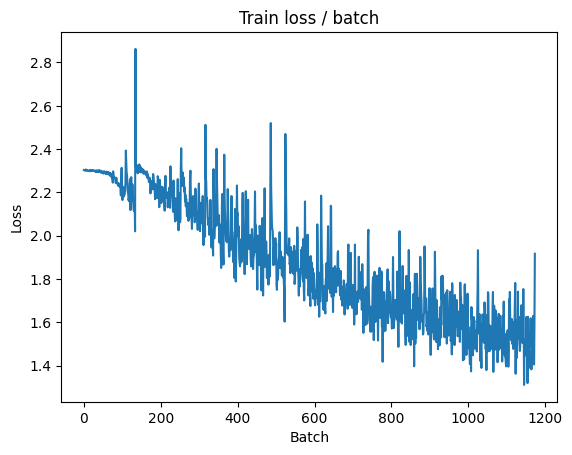

[TRAIN Batch 200/391]	Time 0.054s (0.040s)	Loss 1.3700 (1.4752)	Prec@1  50.8 ( 46.7)	Prec@5  89.8 ( 92.0)


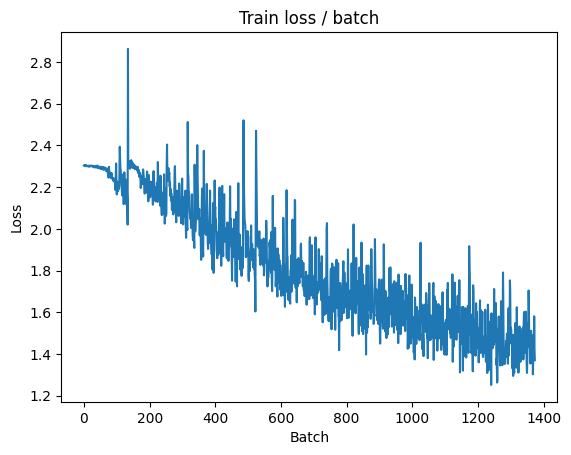


===============> Total time 14s	Avg loss 1.4503	Avg Prec@1 47.66 %	Avg Prec@5 92.24 %

[EVAL Batch 000/391]	Time 0.126s (0.126s)	Loss 1.4836 (1.4836)	Prec@1  54.7 ( 54.7)	Prec@5  89.8 ( 89.8)
[EVAL Batch 200/391]	Time 0.003s (0.030s)	Loss 1.4750 (1.4330)	Prec@1  48.4 ( 48.5)	Prec@5  88.3 ( 92.4)

===============> Total time 10s	Avg loss 1.4380	Avg Prec@1 48.21 %	Avg Prec@5 92.33 %



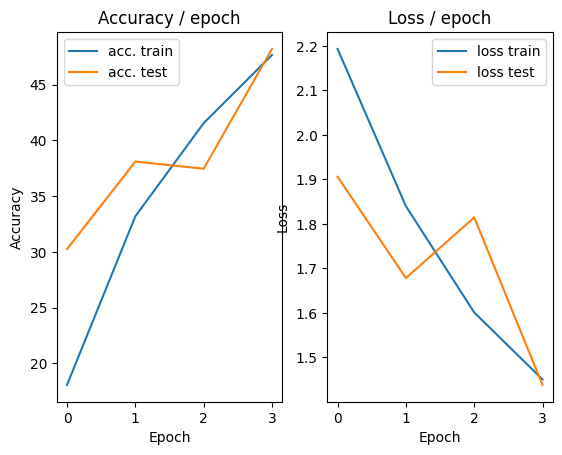

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 1.4729 (1.4729)	Prec@1  48.4 ( 48.4)	Prec@5  94.5 ( 94.5)


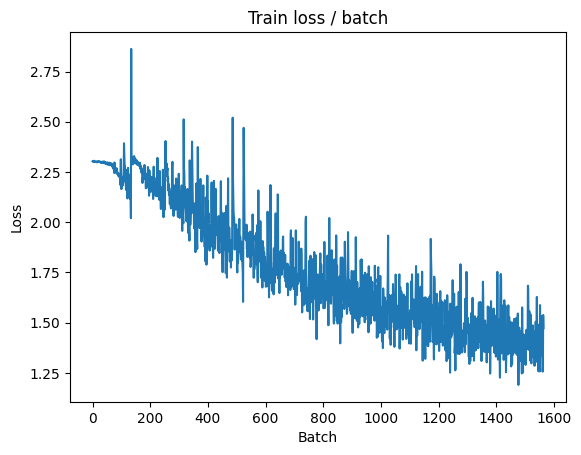

[TRAIN Batch 200/391]	Time 0.049s (0.039s)	Loss 1.4334 (1.3573)	Prec@1  51.6 ( 51.6)	Prec@5  89.8 ( 93.5)


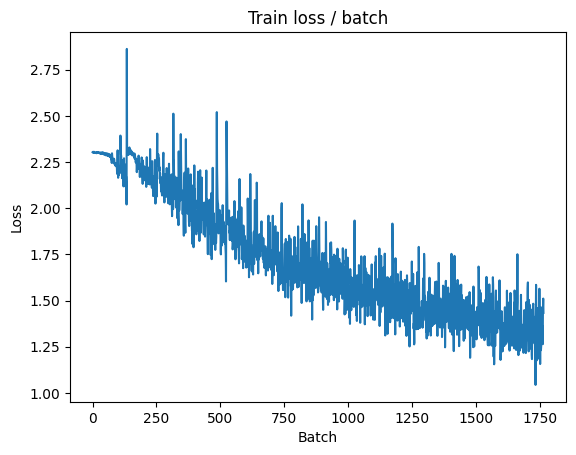


===============> Total time 14s	Avg loss 1.3393	Avg Prec@1 52.11 %	Avg Prec@5 93.72 %

[EVAL Batch 000/391]	Time 0.123s (0.123s)	Loss 1.1263 (1.1263)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)
[EVAL Batch 200/391]	Time 0.003s (0.029s)	Loss 1.2612 (1.2068)	Prec@1  57.8 ( 56.4)	Prec@5  91.4 ( 95.4)

===============> Total time 10s	Avg loss 1.2089	Avg Prec@1 56.42 %	Avg Prec@5 95.31 %



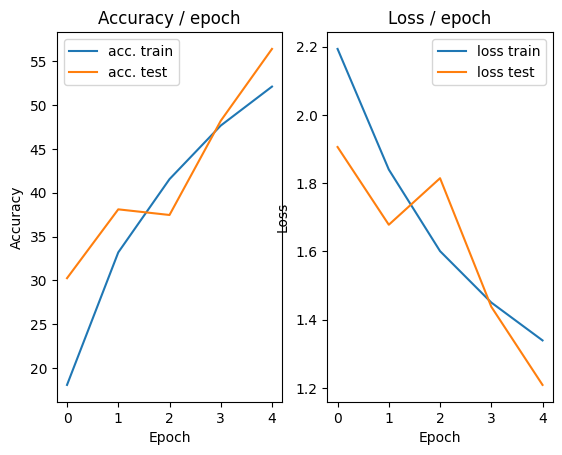

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 1.1369 (1.1369)	Prec@1  56.2 ( 56.2)	Prec@5  96.9 ( 96.9)


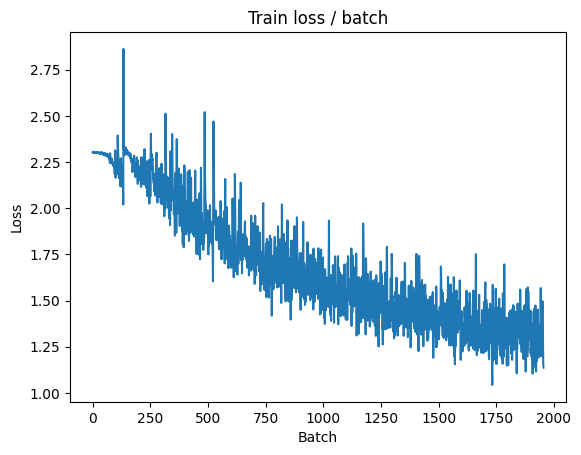

[TRAIN Batch 200/391]	Time 0.042s (0.040s)	Loss 1.3817 (1.2647)	Prec@1  49.2 ( 54.7)	Prec@5  96.1 ( 94.4)


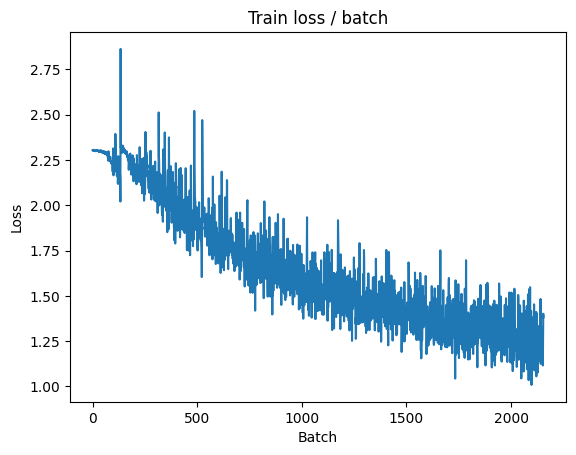


===============> Total time 14s	Avg loss 1.2396	Avg Prec@1 55.62 %	Avg Prec@5 94.84 %

[EVAL Batch 000/391]	Time 0.128s (0.128s)	Loss 1.0454 (1.0454)	Prec@1  62.5 ( 62.5)	Prec@5  97.7 ( 97.7)
[EVAL Batch 200/391]	Time 0.003s (0.029s)	Loss 1.1085 (1.1273)	Prec@1  62.5 ( 59.9)	Prec@5  95.3 ( 96.1)

===============> Total time 10s	Avg loss 1.1318	Avg Prec@1 59.84 %	Avg Prec@5 95.93 %



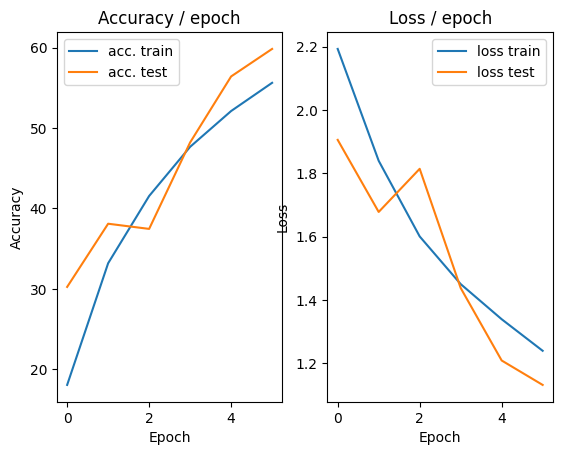

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 1.1580 (1.1580)	Prec@1  59.4 ( 59.4)	Prec@5  96.1 ( 96.1)


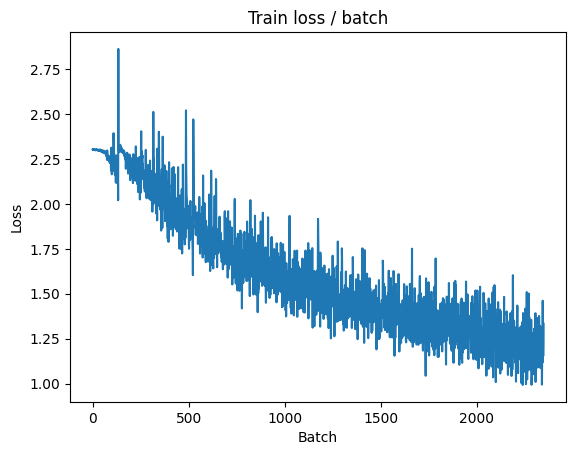

[TRAIN Batch 200/391]	Time 0.014s (0.040s)	Loss 1.2056 (1.1678)	Prec@1  53.1 ( 58.2)	Prec@5  96.1 ( 95.5)


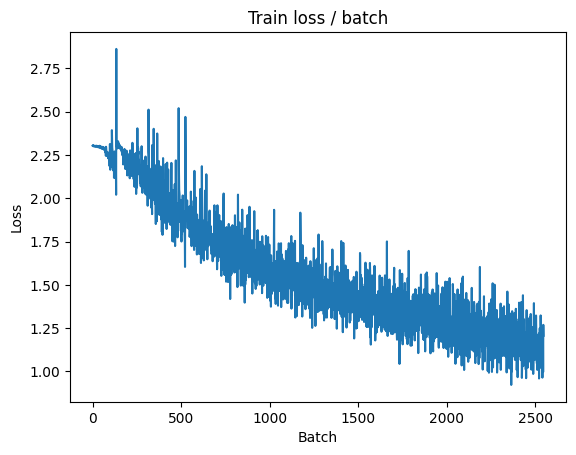


===============> Total time 14s	Avg loss 1.1554	Avg Prec@1 59.03 %	Avg Prec@5 95.54 %

[EVAL Batch 000/391]	Time 0.135s (0.135s)	Loss 0.9146 (0.9146)	Prec@1  71.1 ( 71.1)	Prec@5  99.2 ( 99.2)
[EVAL Batch 200/391]	Time 0.005s (0.029s)	Loss 1.0664 (1.0049)	Prec@1  63.3 ( 64.8)	Prec@5  95.3 ( 96.9)

===============> Total time 10s	Avg loss 1.0076	Avg Prec@1 64.78 %	Avg Prec@5 96.84 %



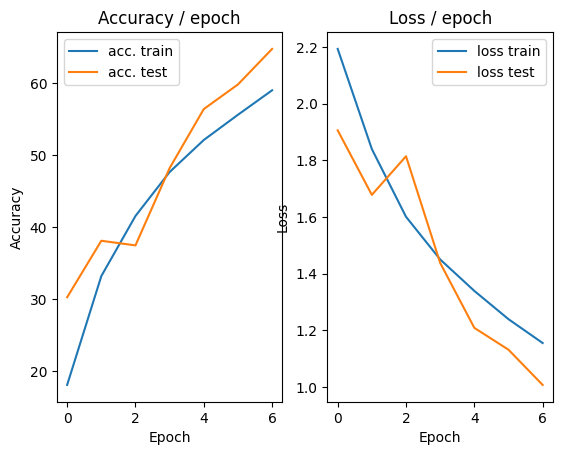

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 1.0921 (1.0921)	Prec@1  58.6 ( 58.6)	Prec@5  96.9 ( 96.9)


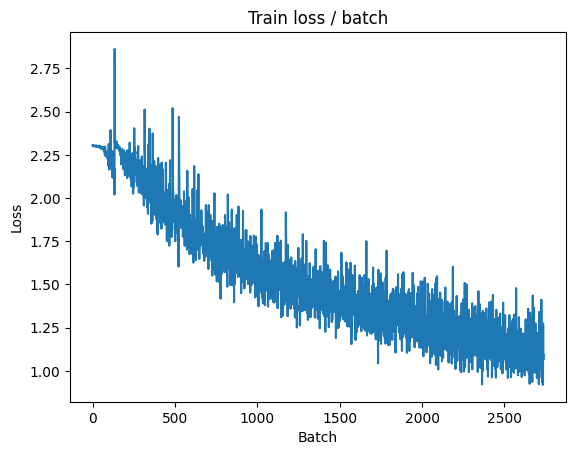

[TRAIN Batch 200/391]	Time 0.016s (0.040s)	Loss 0.9109 (1.0852)	Prec@1  68.0 ( 61.4)	Prec@5  96.9 ( 96.3)


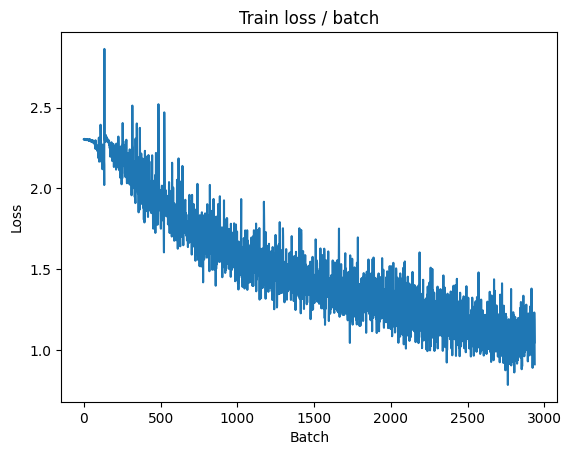


===============> Total time 14s	Avg loss 1.0790	Avg Prec@1 61.73 %	Avg Prec@5 96.21 %

[EVAL Batch 000/391]	Time 0.129s (0.129s)	Loss 0.9819 (0.9819)	Prec@1  65.6 ( 65.6)	Prec@5  97.7 ( 97.7)
[EVAL Batch 200/391]	Time 0.041s (0.029s)	Loss 1.0889 (1.0513)	Prec@1  65.6 ( 62.9)	Prec@5  93.8 ( 96.3)

===============> Total time 10s	Avg loss 1.0564	Avg Prec@1 62.71 %	Avg Prec@5 96.28 %



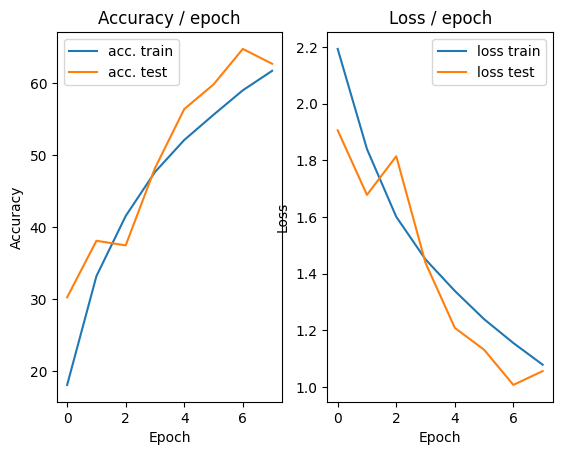

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 1.1852 (1.1852)	Prec@1  57.0 ( 57.0)	Prec@5  92.2 ( 92.2)


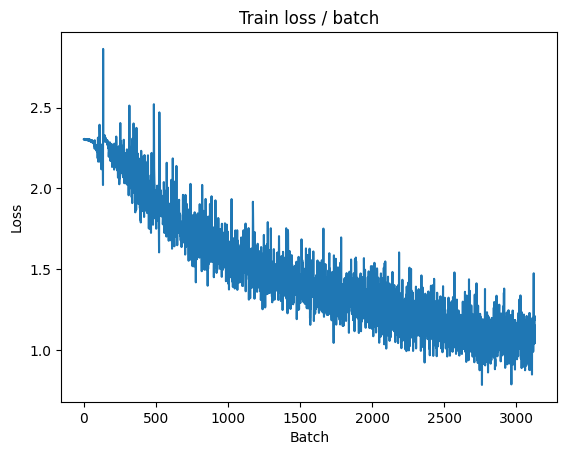

[TRAIN Batch 200/391]	Time 0.051s (0.040s)	Loss 1.0688 (1.0248)	Prec@1  60.2 ( 64.1)	Prec@5  96.9 ( 96.6)


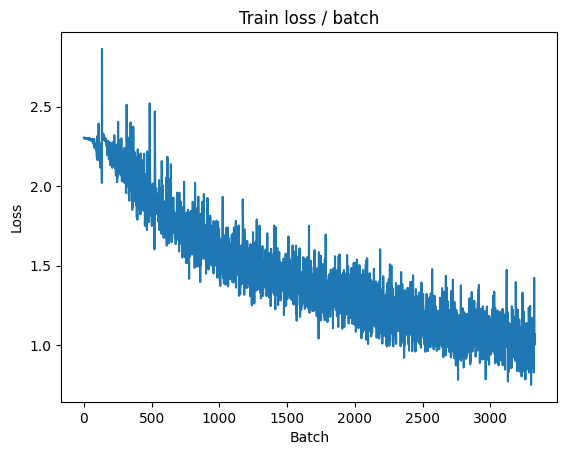


===============> Total time 15s	Avg loss 1.0120	Avg Prec@1 64.51 %	Avg Prec@5 96.64 %

[EVAL Batch 000/391]	Time 0.131s (0.131s)	Loss 0.9959 (0.9959)	Prec@1  65.6 ( 65.6)	Prec@5  98.4 ( 98.4)
[EVAL Batch 200/391]	Time 0.003s (0.029s)	Loss 1.0555 (1.0012)	Prec@1  65.6 ( 64.9)	Prec@5  93.8 ( 97.1)

===============> Total time 10s	Avg loss 1.0040	Avg Prec@1 64.73 %	Avg Prec@5 97.05 %



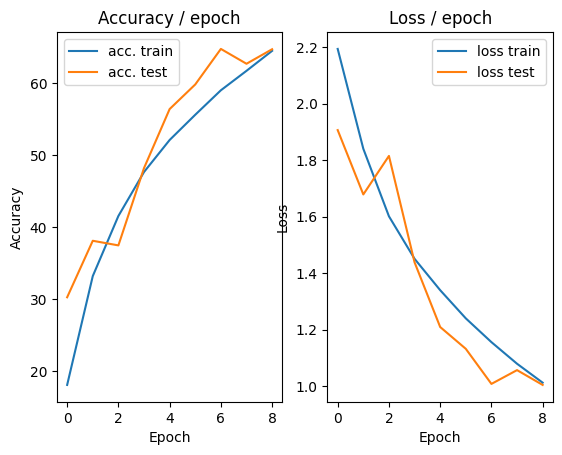

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 1.1216 (1.1216)	Prec@1  58.6 ( 58.6)	Prec@5  97.7 ( 97.7)


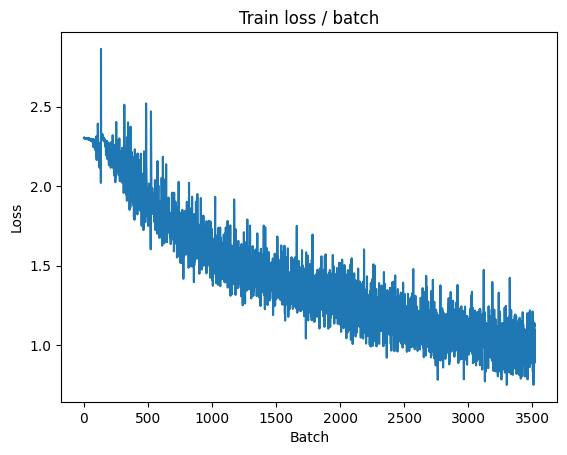

[TRAIN Batch 200/391]	Time 0.055s (0.040s)	Loss 1.1096 (0.9433)	Prec@1  64.1 ( 66.6)	Prec@5  94.5 ( 97.3)


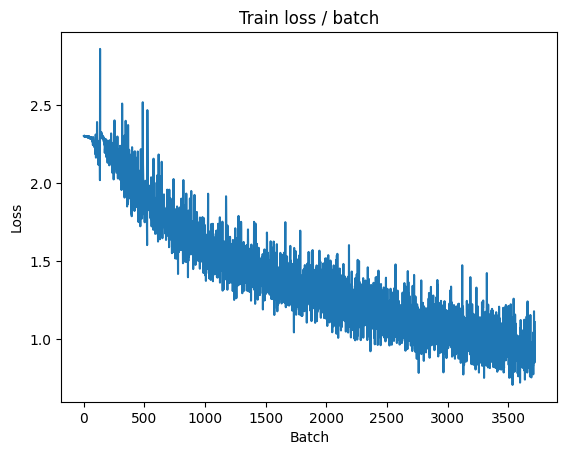


===============> Total time 14s	Avg loss 0.9507	Avg Prec@1 66.57 %	Avg Prec@5 97.18 %

[EVAL Batch 000/391]	Time 0.133s (0.133s)	Loss 0.7687 (0.7687)	Prec@1  75.8 ( 75.8)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.011s (0.030s)	Loss 0.8570 (0.8737)	Prec@1  72.7 ( 69.3)	Prec@5  96.9 ( 97.8)

===============> Total time 10s	Avg loss 0.8759	Avg Prec@1 69.18 %	Avg Prec@5 97.64 %



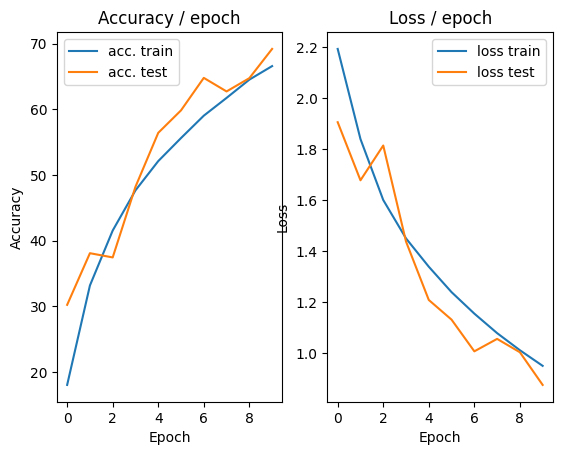

In [9]:
model= CIFAR10_ConvNet()
main(model,batch_size=128,lr=0.1,epochs=10,cuda=True,get_data=get_dataset_increased)

## Variants on the optimization algorithm

In [10]:
import torch.optim.lr_scheduler

def main_scheduler(model,batch_size=128, lr=0.1, epochs=5,cuda=False,get_data=None):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_data(batch_size, cuda)

    # create an expo scheduler
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer,cuda=cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.161s (0.161s)	Loss 2.3016 (2.3016)	Prec@1  13.3 ( 13.3)	Prec@5  53.1 ( 53.1)


<Figure size 640x480 with 0 Axes>

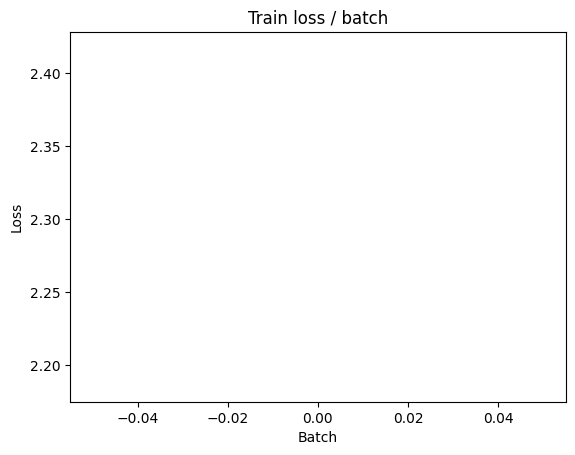

[TRAIN Batch 200/391]	Time 0.016s (0.040s)	Loss 1.6054 (1.9397)	Prec@1  36.7 ( 29.3)	Prec@5  92.2 ( 79.5)


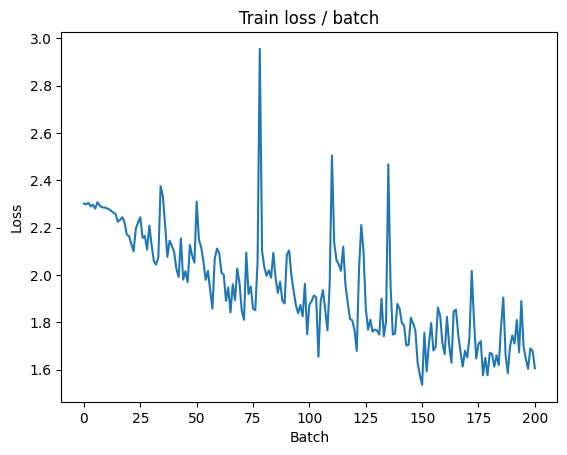


===============> Total time 14s	Avg loss 1.7368	Avg Prec@1 37.04 %	Avg Prec@5 85.34 %

[EVAL Batch 000/391]	Time 0.161s (0.161s)	Loss 1.2633 (1.2633)	Prec@1  50.0 ( 50.0)	Prec@5  96.1 ( 96.1)
[EVAL Batch 200/391]	Time 0.056s (0.036s)	Loss 1.2475 (1.3866)	Prec@1  53.9 ( 50.0)	Prec@5  93.0 ( 93.8)

===============> Total time 13s	Avg loss 1.3897	Avg Prec@1 49.94 %	Avg Prec@5 93.80 %



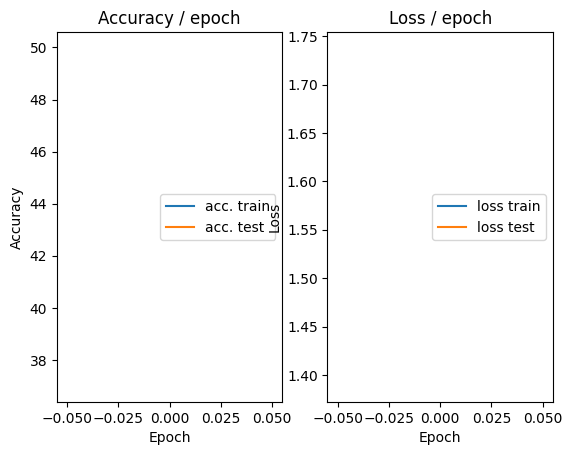

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.269s (0.269s)	Loss 1.3814 (1.3814)	Prec@1  48.4 ( 48.4)	Prec@5  92.2 ( 92.2)


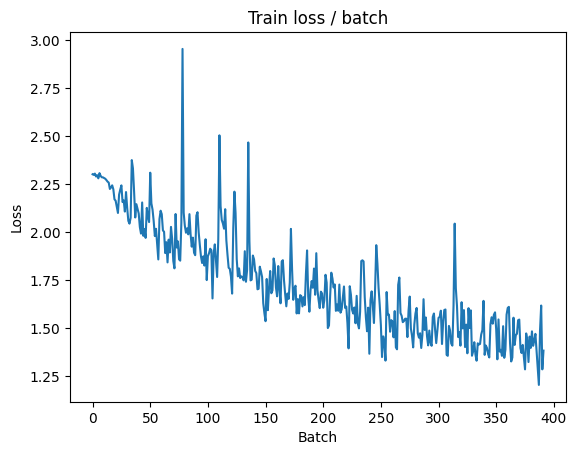

[TRAIN Batch 200/391]	Time 0.016s (0.037s)	Loss 1.0998 (1.3192)	Prec@1  62.5 ( 52.8)	Prec@5  96.9 ( 94.2)


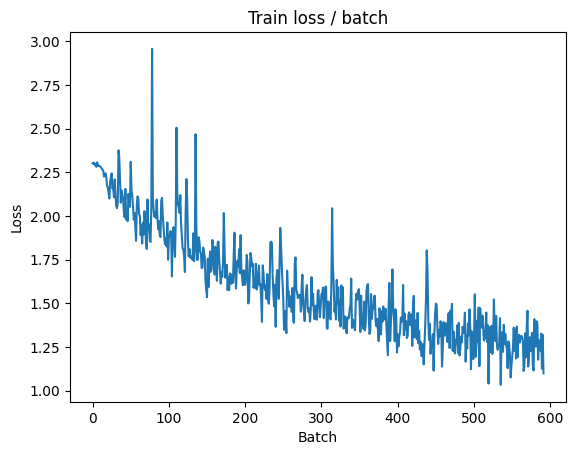


===============> Total time 14s	Avg loss 1.2651	Avg Prec@1 55.03 %	Avg Prec@5 94.66 %

[EVAL Batch 000/391]	Time 0.134s (0.134s)	Loss 0.9900 (0.9900)	Prec@1  69.5 ( 69.5)	Prec@5  94.5 ( 94.5)
[EVAL Batch 200/391]	Time 0.050s (0.031s)	Loss 1.0767 (1.1129)	Prec@1  59.4 ( 60.5)	Prec@5  98.4 ( 96.2)

===============> Total time 12s	Avg loss 1.1157	Avg Prec@1 60.57 %	Avg Prec@5 96.15 %



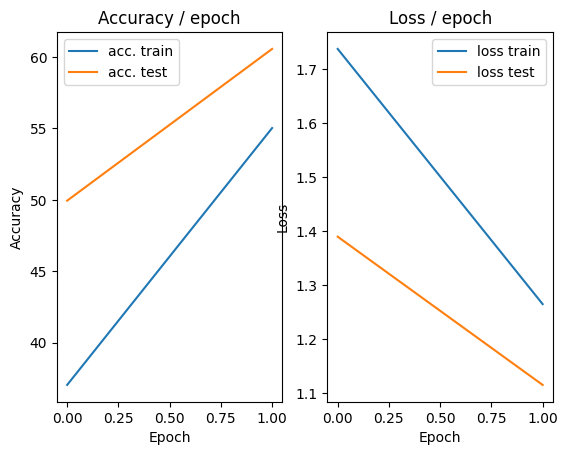

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.9920 (0.9920)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)


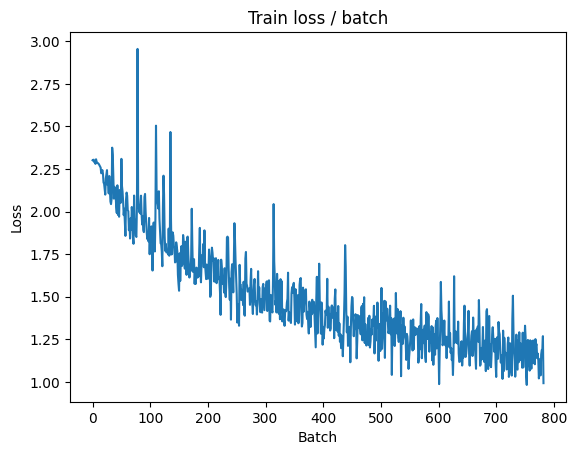

[TRAIN Batch 200/391]	Time 0.023s (0.034s)	Loss 0.8156 (1.0666)	Prec@1  73.4 ( 62.6)	Prec@5  96.9 ( 96.6)


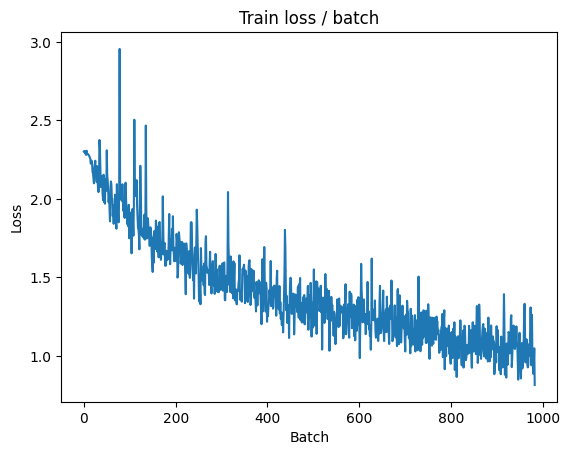


===============> Total time 14s	Avg loss 1.0273	Avg Prec@1 64.17 %	Avg Prec@5 96.72 %

[EVAL Batch 000/391]	Time 0.135s (0.135s)	Loss 0.8349 (0.8349)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)
[EVAL Batch 200/391]	Time 0.044s (0.030s)	Loss 0.9442 (0.9713)	Prec@1  62.5 ( 65.8)	Prec@5  97.7 ( 96.9)

===============> Total time 12s	Avg loss 0.9731	Avg Prec@1 66.01 %	Avg Prec@5 96.97 %



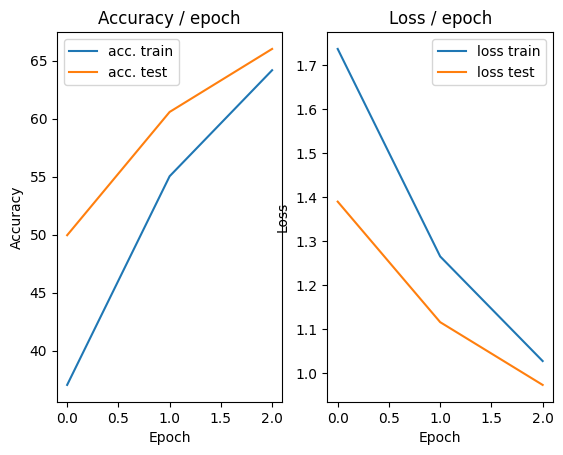

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.155s (0.155s)	Loss 0.8994 (0.8994)	Prec@1  64.1 ( 64.1)	Prec@5 100.0 (100.0)


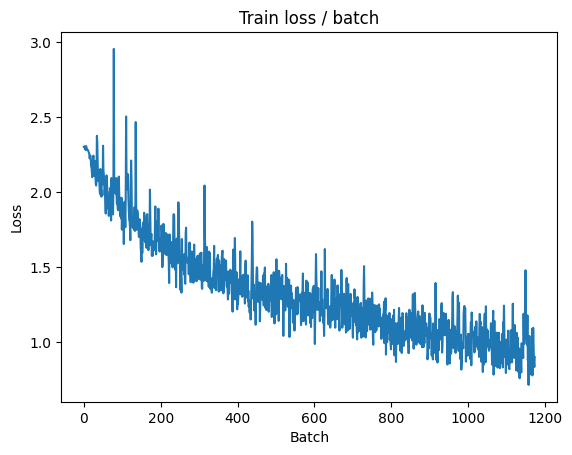

[TRAIN Batch 200/391]	Time 0.019s (0.034s)	Loss 0.8480 (0.8535)	Prec@1  68.0 ( 70.4)	Prec@5  99.2 ( 97.9)


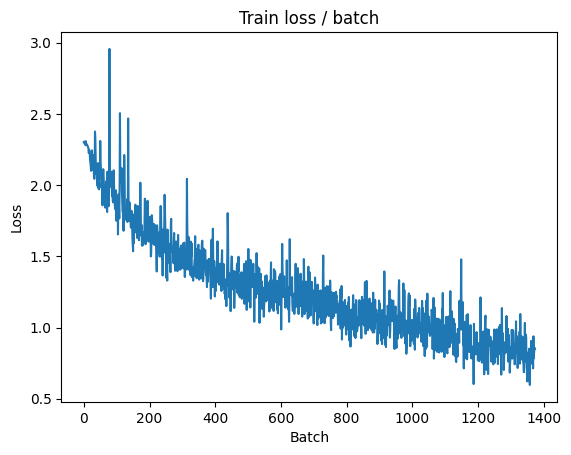


===============> Total time 13s	Avg loss 0.8468	Avg Prec@1 70.61 %	Avg Prec@5 97.86 %

[EVAL Batch 000/391]	Time 0.149s (0.149s)	Loss 0.7168 (0.7168)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)
[EVAL Batch 200/391]	Time 0.009s (0.033s)	Loss 0.7960 (0.6966)	Prec@1  74.2 ( 76.3)	Prec@5  96.9 ( 98.7)

===============> Total time 12s	Avg loss 0.6968	Avg Prec@1 76.26 %	Avg Prec@5 98.68 %



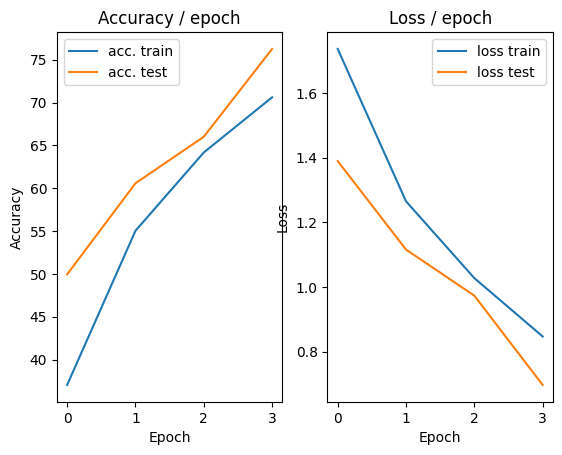

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.155s (0.155s)	Loss 0.7061 (0.7061)	Prec@1  78.9 ( 78.9)	Prec@5  96.1 ( 96.1)


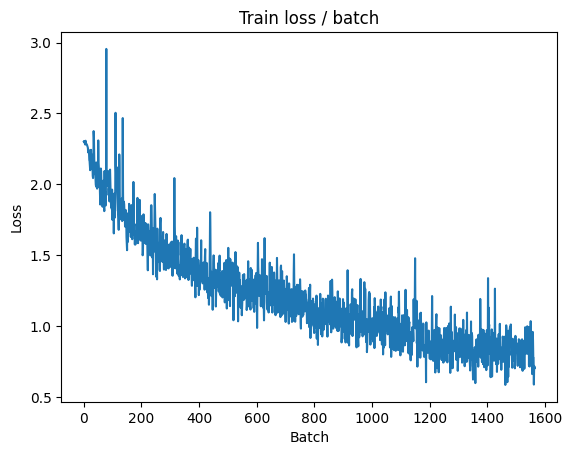

[TRAIN Batch 200/391]	Time 0.029s (0.039s)	Loss 0.7232 (0.7077)	Prec@1  78.1 ( 75.3)	Prec@5  99.2 ( 98.6)


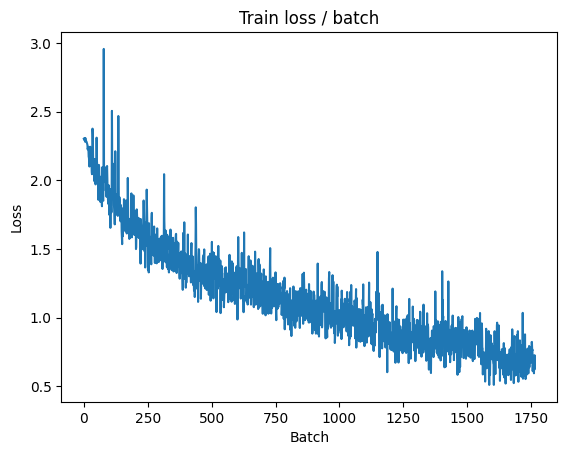


===============> Total time 14s	Avg loss 0.7055	Avg Prec@1 75.45 %	Avg Prec@5 98.54 %

[EVAL Batch 000/391]	Time 0.141s (0.141s)	Loss 0.6150 (0.6150)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)
[EVAL Batch 200/391]	Time 0.060s (0.036s)	Loss 0.7928 (0.6860)	Prec@1  72.7 ( 75.9)	Prec@5  99.2 ( 98.8)

===============> Total time 12s	Avg loss 0.6884	Avg Prec@1 76.05 %	Avg Prec@5 98.74 %



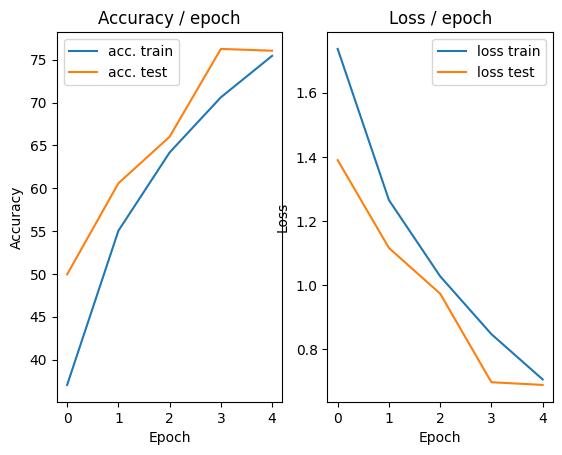

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 0.6161 (0.6161)	Prec@1  78.1 ( 78.1)	Prec@5  98.4 ( 98.4)


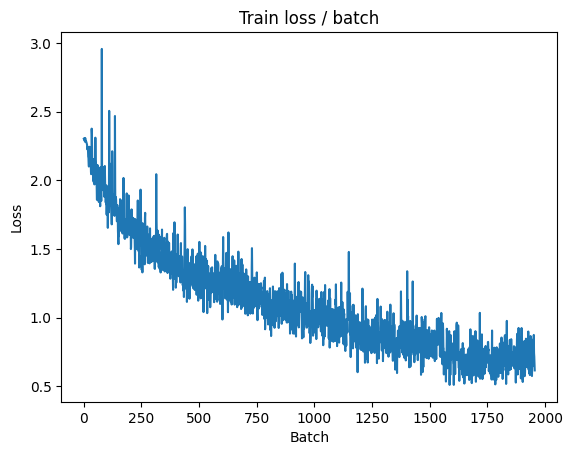

[TRAIN Batch 200/391]	Time 0.014s (0.040s)	Loss 0.5351 (0.5780)	Prec@1  81.2 ( 79.8)	Prec@5 100.0 ( 99.1)


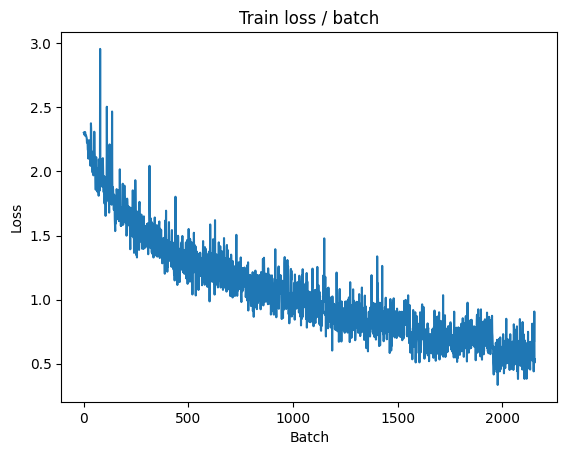


===============> Total time 14s	Avg loss 0.5805	Avg Prec@1 79.82 %	Avg Prec@5 99.06 %

[EVAL Batch 000/391]	Time 0.141s (0.141s)	Loss 0.4340 (0.4340)	Prec@1  84.4 ( 84.4)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.004s (0.036s)	Loss 0.5904 (0.5038)	Prec@1  80.5 ( 81.9)	Prec@5  97.7 ( 99.5)

===============> Total time 12s	Avg loss 0.5034	Avg Prec@1 82.11 %	Avg Prec@5 99.43 %



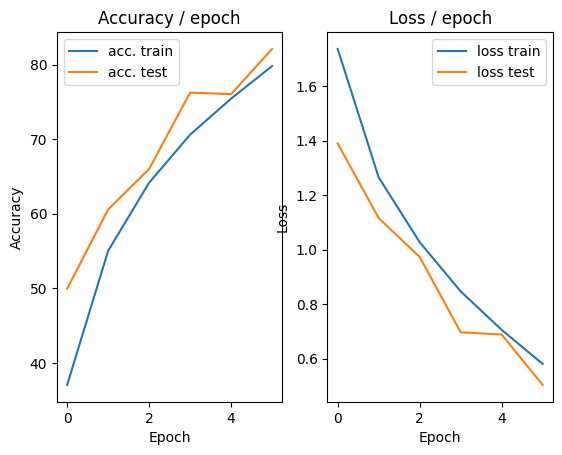

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.319s (0.319s)	Loss 0.5655 (0.5655)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


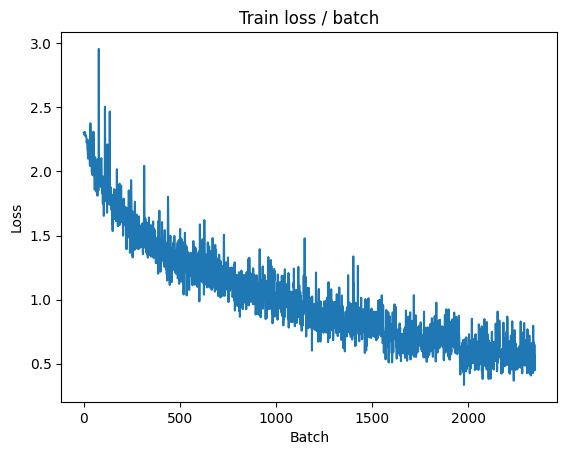

[TRAIN Batch 200/391]	Time 0.060s (0.040s)	Loss 0.4775 (0.4705)	Prec@1  82.0 ( 84.0)	Prec@5  99.2 ( 99.4)


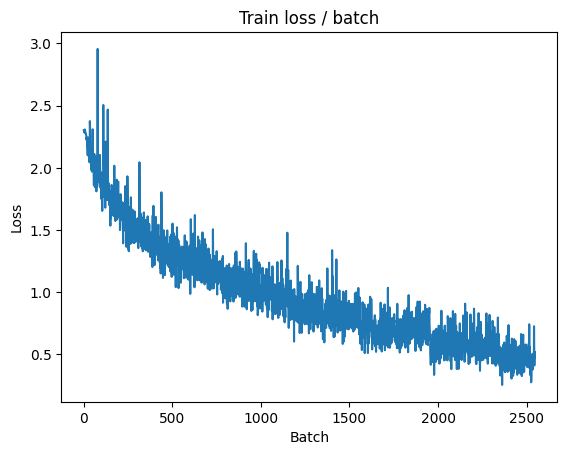


===============> Total time 15s	Avg loss 0.4749	Avg Prec@1 83.60 %	Avg Prec@5 99.41 %

[EVAL Batch 000/391]	Time 0.244s (0.244s)	Loss 0.3571 (0.3571)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.057s (0.031s)	Loss 0.4475 (0.4139)	Prec@1  85.2 ( 85.5)	Prec@5  99.2 ( 99.6)

===============> Total time 12s	Avg loss 0.4087	Avg Prec@1 85.77 %	Avg Prec@5 99.62 %



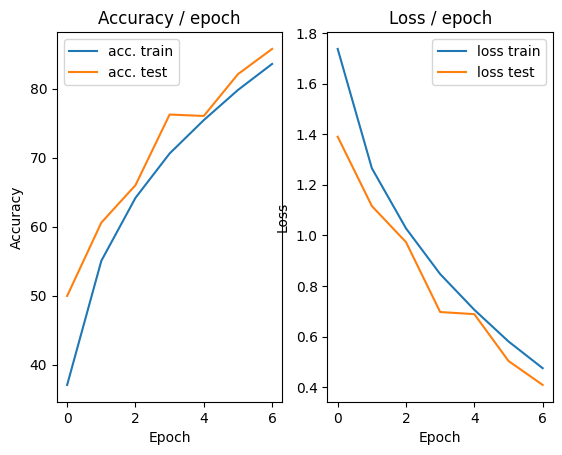

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.3709 (0.3709)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


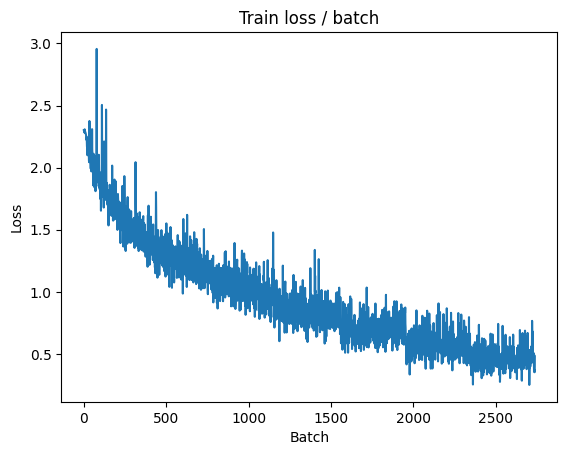

[TRAIN Batch 200/391]	Time 0.018s (0.035s)	Loss 0.4378 (0.3513)	Prec@1  87.5 ( 87.8)	Prec@5 100.0 ( 99.7)


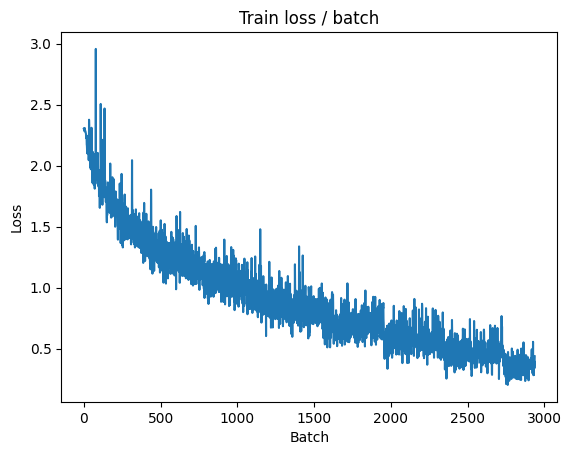


===============> Total time 14s	Avg loss 0.3645	Avg Prec@1 87.34 %	Avg Prec@5 99.67 %

[EVAL Batch 000/391]	Time 0.147s (0.147s)	Loss 0.2243 (0.2243)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.050s (0.030s)	Loss 0.3142 (0.2784)	Prec@1  87.5 ( 90.7)	Prec@5 100.0 ( 99.9)

===============> Total time 12s	Avg loss 0.2796	Avg Prec@1 90.72 %	Avg Prec@5 99.85 %



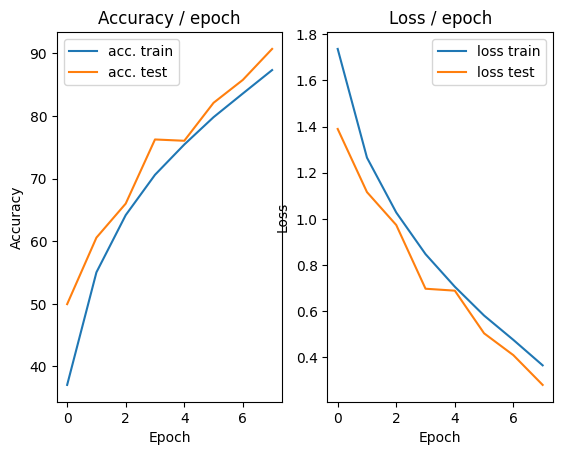

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.170s (0.170s)	Loss 0.2626 (0.2626)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


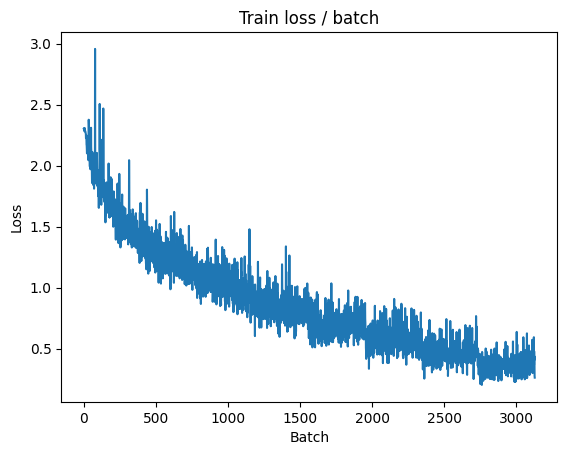

[TRAIN Batch 200/391]	Time 0.011s (0.034s)	Loss 0.2295 (0.2601)	Prec@1  91.4 ( 91.3)	Prec@5 100.0 ( 99.9)


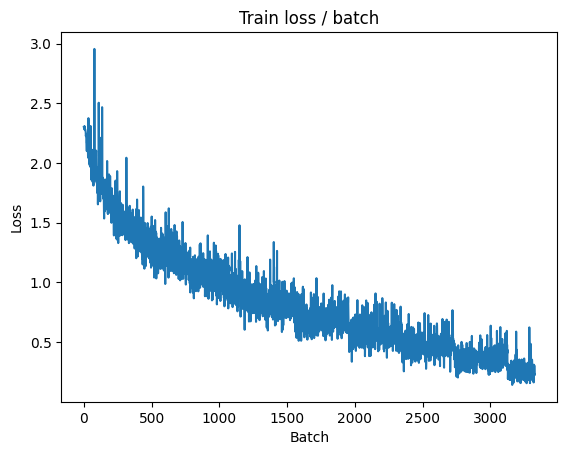


===============> Total time 14s	Avg loss 0.2614	Avg Prec@1 91.01 %	Avg Prec@5 99.85 %

[EVAL Batch 000/391]	Time 0.141s (0.141s)	Loss 0.2135 (0.2135)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.051s (0.030s)	Loss 0.2059 (0.1865)	Prec@1  91.4 ( 93.7)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.1860	Avg Prec@1 93.76 %	Avg Prec@5 99.96 %



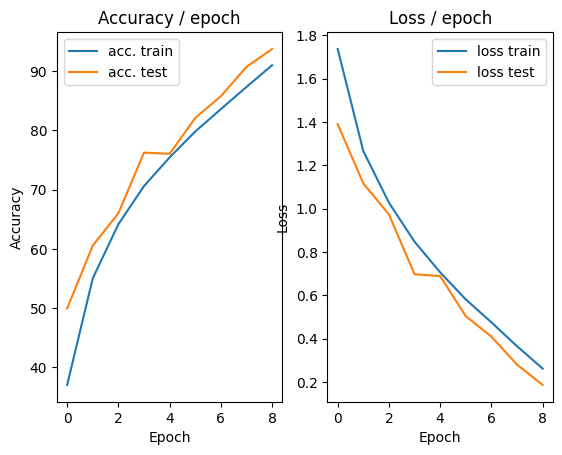

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.1546 (0.1546)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


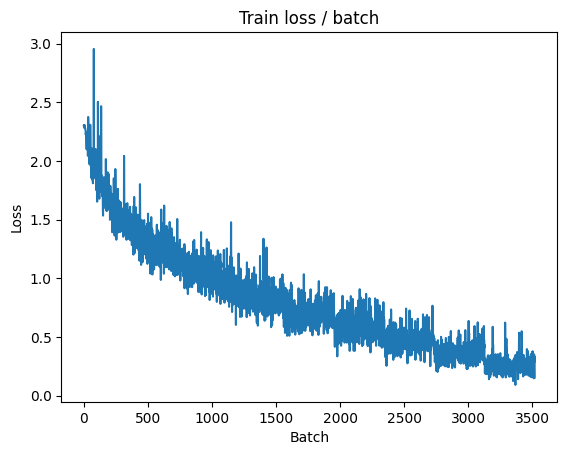

[TRAIN Batch 200/391]	Time 0.084s (0.038s)	Loss 0.1901 (0.1643)	Prec@1  93.0 ( 94.7)	Prec@5 100.0 ( 99.9)


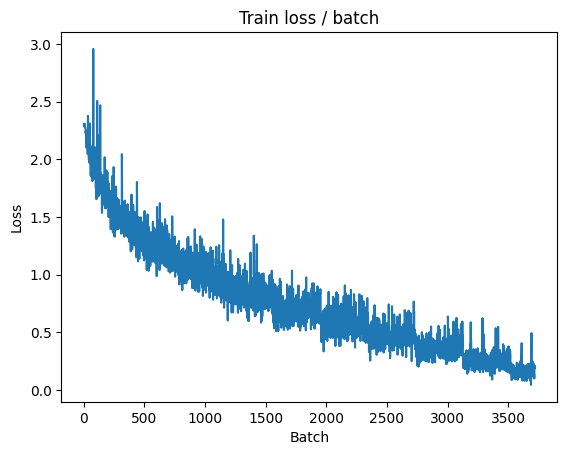


===============> Total time 14s	Avg loss 0.1745	Avg Prec@1 94.14 %	Avg Prec@5 99.93 %

[EVAL Batch 000/391]	Time 0.172s (0.172s)	Loss 0.0963 (0.0963)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.051s (0.036s)	Loss 0.1944 (0.1418)	Prec@1  91.4 ( 95.4)	Prec@5 100.0 (100.0)

===============> Total time 13s	Avg loss 0.1423	Avg Prec@1 95.46 %	Avg Prec@5 99.98 %



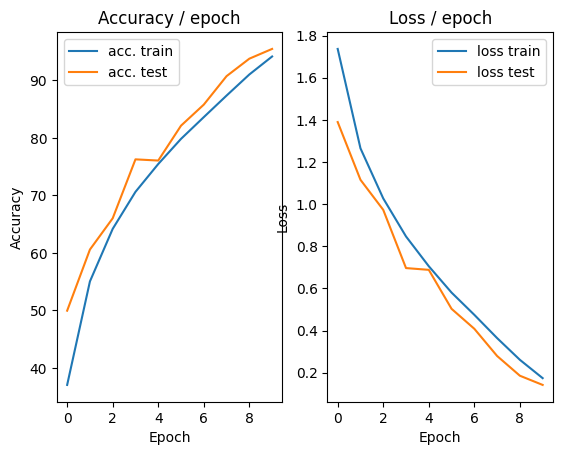

In [11]:
model= CIFAR10_ConvNet()
main_scheduler(model,batch_size=128,lr=0.1,epochs=10,cuda=True,get_data=get_dataset_normalized)

## Regularization of the network by dropout

In [12]:
class CIFAR10_ConvNet_Dropouted(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(CIFAR10_ConvNet_Dropouted, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0,ceil_mode=True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 2.3007 (2.3007)	Prec@1   9.4 (  9.4)	Prec@5  55.5 ( 55.5)


<Figure size 640x480 with 0 Axes>

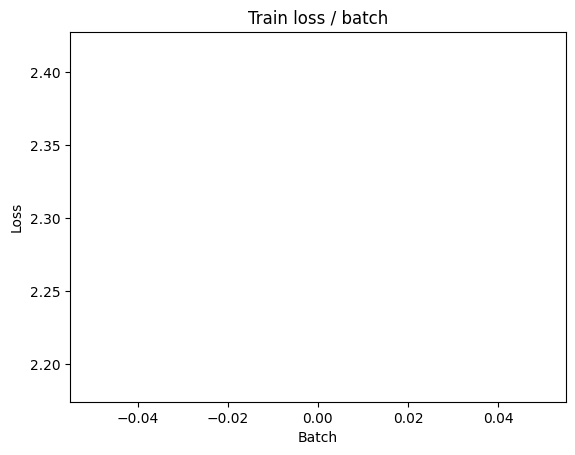

[TRAIN Batch 200/391]	Time 0.060s (0.039s)	Loss 1.6185 (1.9348)	Prec@1  43.8 ( 29.5)	Prec@5  90.6 ( 79.5)


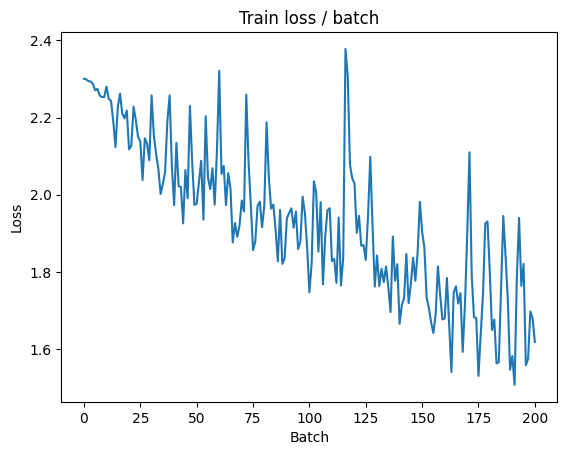


===============> Total time 14s	Avg loss 1.7544	Avg Prec@1 36.38 %	Avg Prec@5 84.99 %

[EVAL Batch 000/391]	Time 0.168s (0.168s)	Loss 1.2305 (1.2305)	Prec@1  55.5 ( 55.5)	Prec@5  94.5 ( 94.5)
[EVAL Batch 200/391]	Time 0.003s (0.035s)	Loss 1.2657 (1.3565)	Prec@1  56.2 ( 51.6)	Prec@5  92.2 ( 94.0)

===============> Total time 12s	Avg loss 1.3587	Avg Prec@1 51.40 %	Avg Prec@5 93.94 %



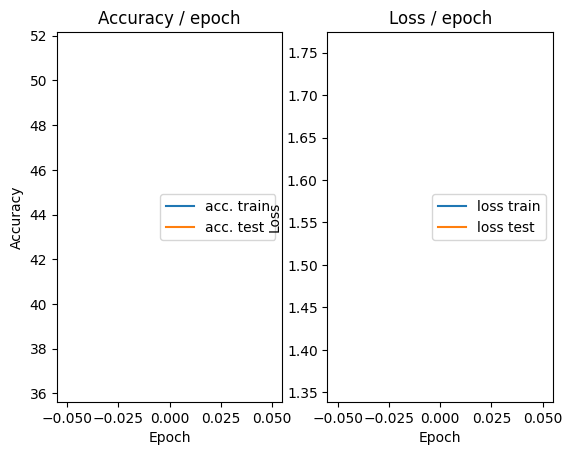

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.295s (0.295s)	Loss 1.3428 (1.3428)	Prec@1  50.0 ( 50.0)	Prec@5  93.0 ( 93.0)


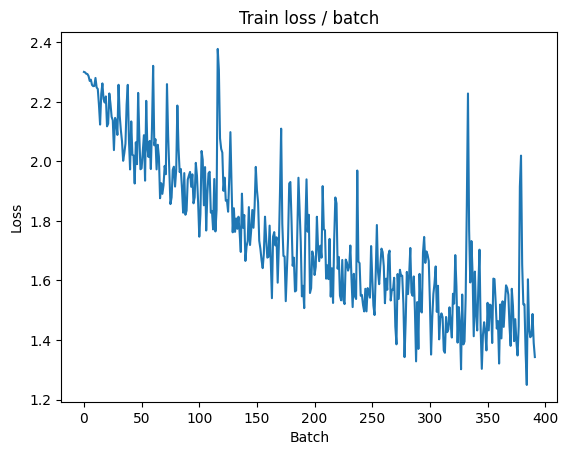

[TRAIN Batch 200/391]	Time 0.017s (0.038s)	Loss 1.3386 (1.3614)	Prec@1  53.1 ( 51.4)	Prec@5  92.2 ( 93.7)


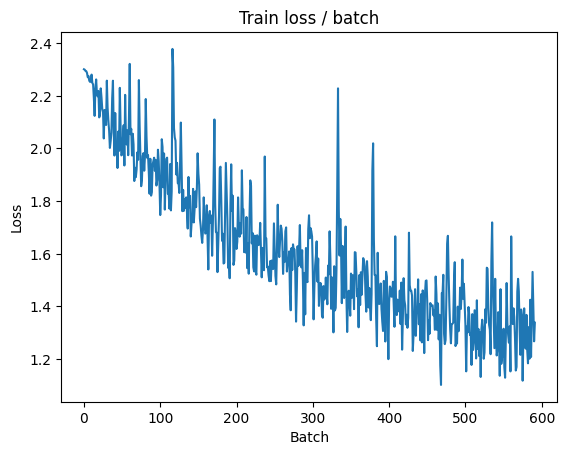


===============> Total time 15s	Avg loss 1.2967	Avg Prec@1 53.88 %	Avg Prec@5 94.47 %

[EVAL Batch 000/391]	Time 0.159s (0.159s)	Loss 0.9552 (0.9552)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)
[EVAL Batch 200/391]	Time 0.003s (0.031s)	Loss 1.1405 (1.0782)	Prec@1  58.6 ( 61.4)	Prec@5  95.3 ( 96.6)

===============> Total time 13s	Avg loss 1.0796	Avg Prec@1 61.43 %	Avg Prec@5 96.53 %



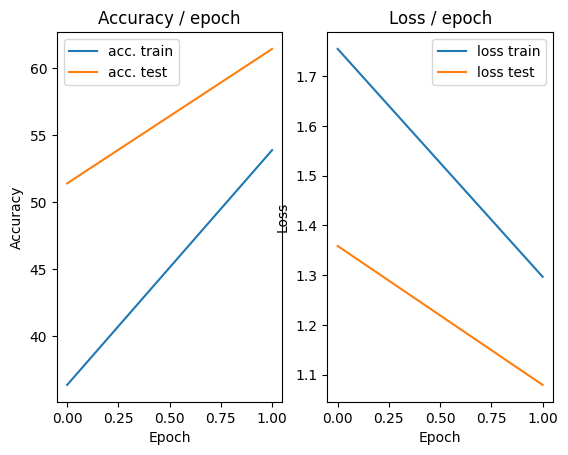

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 1.0277 (1.0277)	Prec@1  60.9 ( 60.9)	Prec@5  97.7 ( 97.7)


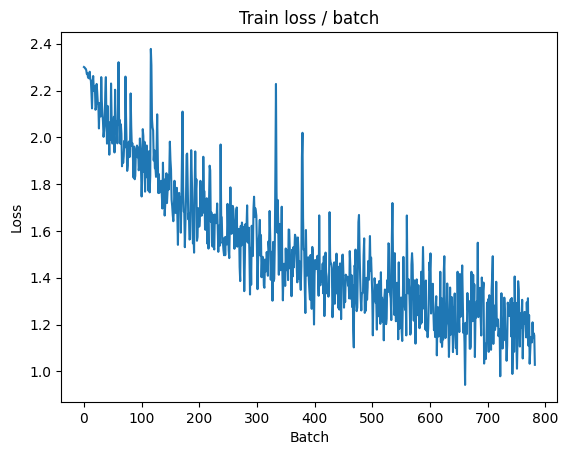

[TRAIN Batch 200/391]	Time 0.022s (0.034s)	Loss 1.2468 (1.1020)	Prec@1  54.7 ( 61.4)	Prec@5  95.3 ( 96.2)


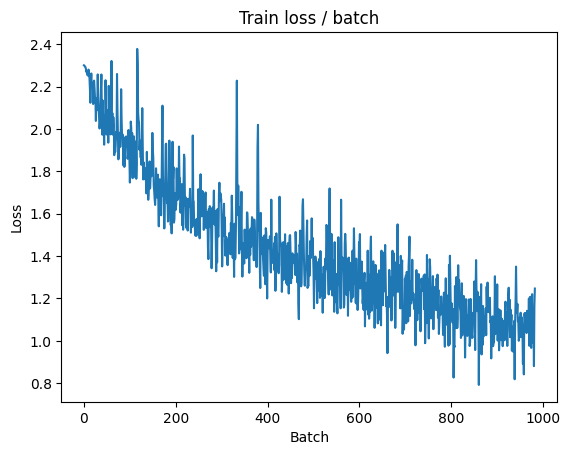


===============> Total time 14s	Avg loss 1.0608	Avg Prec@1 62.70 %	Avg Prec@5 96.53 %

[EVAL Batch 000/391]	Time 0.141s (0.141s)	Loss 0.8307 (0.8307)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)
[EVAL Batch 200/391]	Time 0.038s (0.031s)	Loss 0.8462 (0.9294)	Prec@1  69.5 ( 68.0)	Prec@5  99.2 ( 97.3)

===============> Total time 12s	Avg loss 0.9303	Avg Prec@1 68.23 %	Avg Prec@5 97.25 %



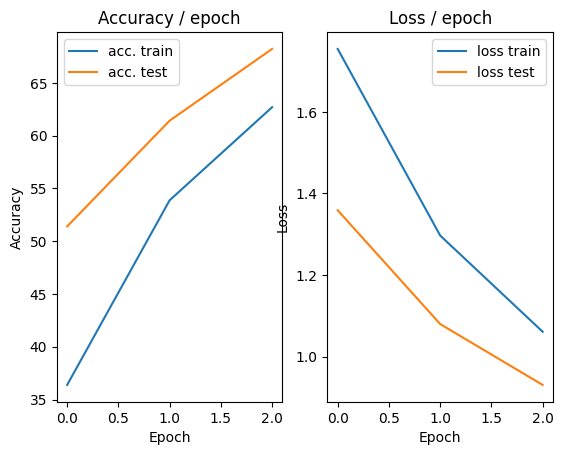

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.8771 (0.8771)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)


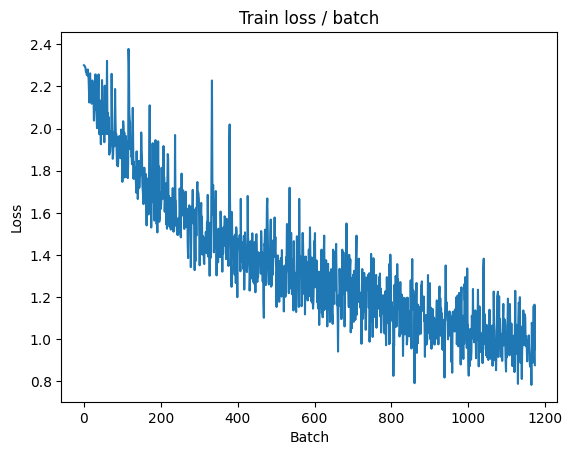

[TRAIN Batch 200/391]	Time 0.046s (0.036s)	Loss 0.9941 (0.9096)	Prec@1  66.4 ( 68.5)	Prec@5  95.3 ( 97.4)


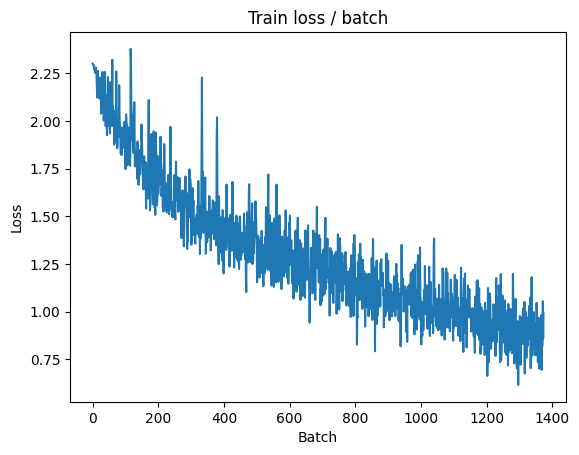


===============> Total time 14s	Avg loss 0.8883	Avg Prec@1 69.03 %	Avg Prec@5 97.54 %

[EVAL Batch 000/391]	Time 0.148s (0.148s)	Loss 0.6374 (0.6374)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)
[EVAL Batch 200/391]	Time 0.014s (0.035s)	Loss 0.8320 (0.7532)	Prec@1  69.5 ( 73.0)	Prec@5  96.9 ( 98.4)

===============> Total time 13s	Avg loss 0.7520	Avg Prec@1 73.22 %	Avg Prec@5 98.33 %



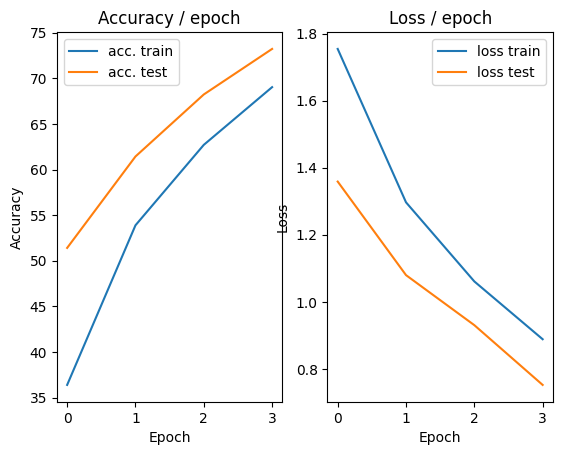

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.170s (0.170s)	Loss 0.8134 (0.8134)	Prec@1  70.3 ( 70.3)	Prec@5  96.1 ( 96.1)


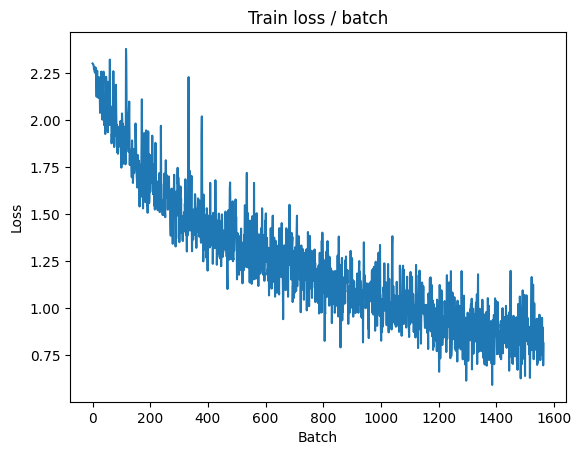

[TRAIN Batch 200/391]	Time 0.036s (0.040s)	Loss 0.7308 (0.7643)	Prec@1  74.2 ( 73.1)	Prec@5  96.9 ( 98.2)


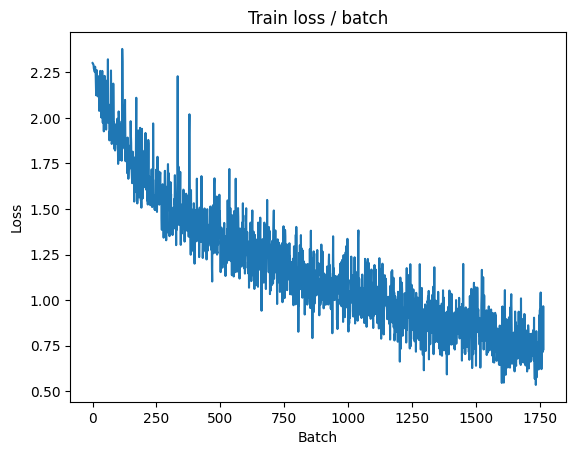


===============> Total time 14s	Avg loss 0.7642	Avg Prec@1 73.13 %	Avg Prec@5 98.23 %

[EVAL Batch 000/391]	Time 0.149s (0.149s)	Loss 0.5937 (0.5937)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)
[EVAL Batch 200/391]	Time 0.055s (0.036s)	Loss 0.6926 (0.6760)	Prec@1  77.3 ( 76.2)	Prec@5  98.4 ( 98.9)

===============> Total time 12s	Avg loss 0.6723	Avg Prec@1 76.52 %	Avg Prec@5 98.91 %



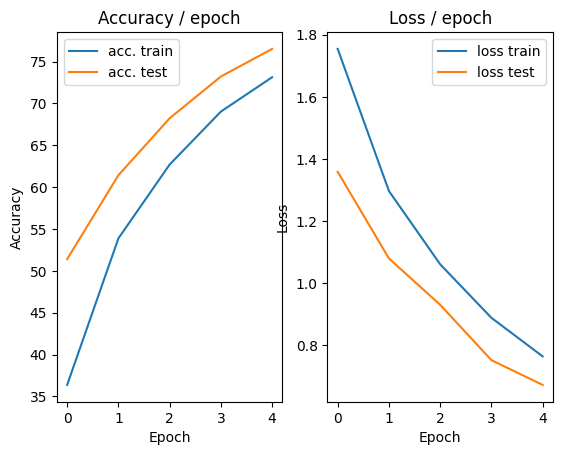

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.6733 (0.6733)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)


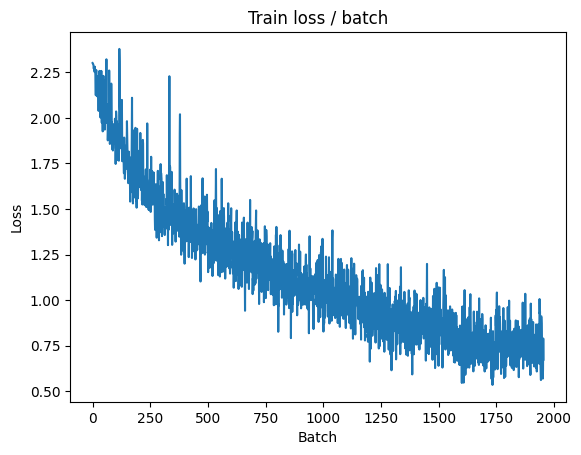

[TRAIN Batch 200/391]	Time 0.055s (0.040s)	Loss 0.6394 (0.6570)	Prec@1  76.6 ( 76.8)	Prec@5  98.4 ( 98.6)


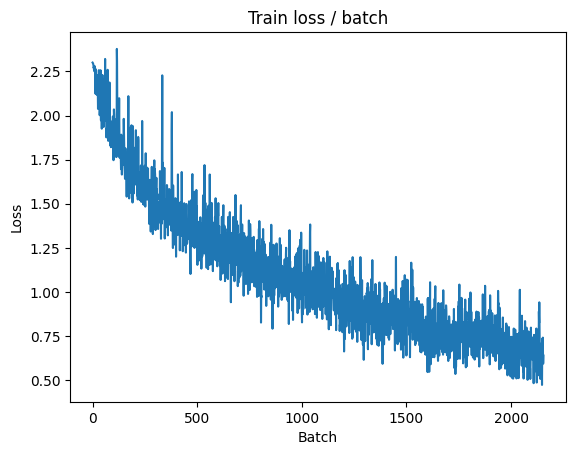


===============> Total time 14s	Avg loss 0.6554	Avg Prec@1 76.95 %	Avg Prec@5 98.69 %

[EVAL Batch 000/391]	Time 0.145s (0.145s)	Loss 0.4948 (0.4948)	Prec@1  84.4 ( 84.4)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.054s (0.037s)	Loss 0.5674 (0.5446)	Prec@1  80.5 ( 81.3)	Prec@5  99.2 ( 99.1)

===============> Total time 13s	Avg loss 0.5427	Avg Prec@1 81.44 %	Avg Prec@5 99.17 %



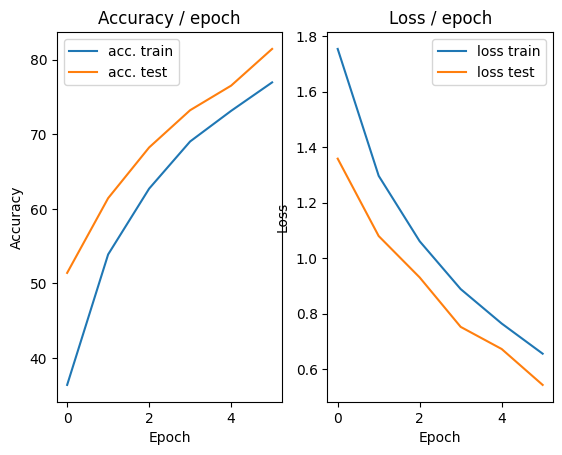

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.251s (0.251s)	Loss 0.5956 (0.5956)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


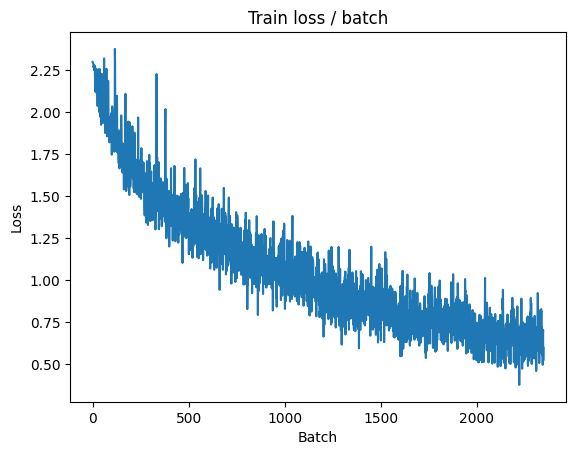

[TRAIN Batch 200/391]	Time 0.046s (0.038s)	Loss 0.6649 (0.5581)	Prec@1  74.2 ( 80.6)	Prec@5 100.0 ( 99.2)


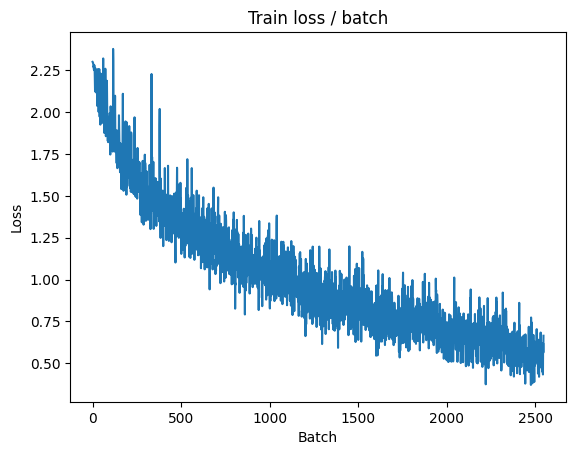


===============> Total time 14s	Avg loss 0.5635	Avg Prec@1 80.30 %	Avg Prec@5 99.14 %

[EVAL Batch 000/391]	Time 0.138s (0.138s)	Loss 0.3769 (0.3769)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.004s (0.030s)	Loss 0.4807 (0.4604)	Prec@1  82.0 ( 84.4)	Prec@5  98.4 ( 99.5)

===============> Total time 12s	Avg loss 0.4612	Avg Prec@1 84.47 %	Avg Prec@5 99.44 %



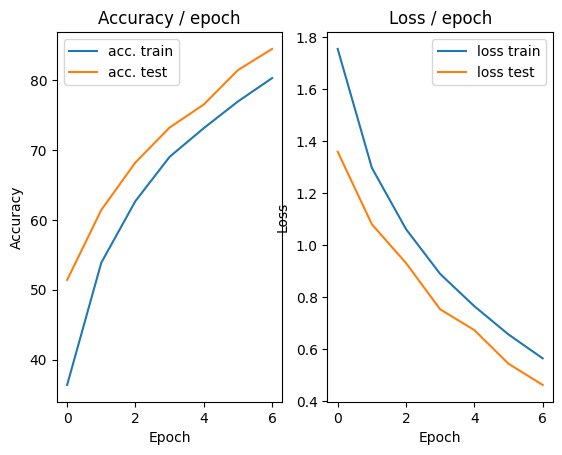

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.4663 (0.4663)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


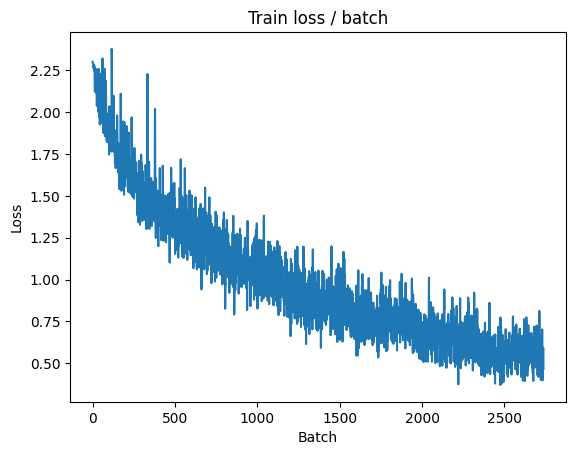

[TRAIN Batch 200/391]	Time 0.057s (0.035s)	Loss 0.5117 (0.4712)	Prec@1  79.7 ( 83.6)	Prec@5 100.0 ( 99.4)


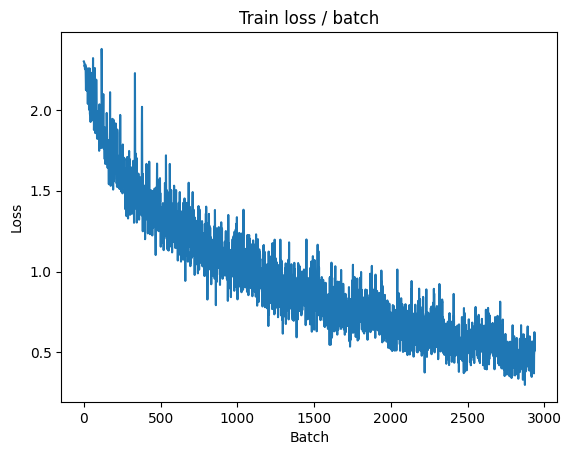


===============> Total time 14s	Avg loss 0.4781	Avg Prec@1 83.34 %	Avg Prec@5 99.40 %

[EVAL Batch 000/391]	Time 0.142s (0.142s)	Loss 0.2683 (0.2683)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.060s (0.031s)	Loss 0.3837 (0.3549)	Prec@1  84.4 ( 88.1)	Prec@5 100.0 ( 99.7)

===============> Total time 13s	Avg loss 0.3533	Avg Prec@1 88.22 %	Avg Prec@5 99.69 %



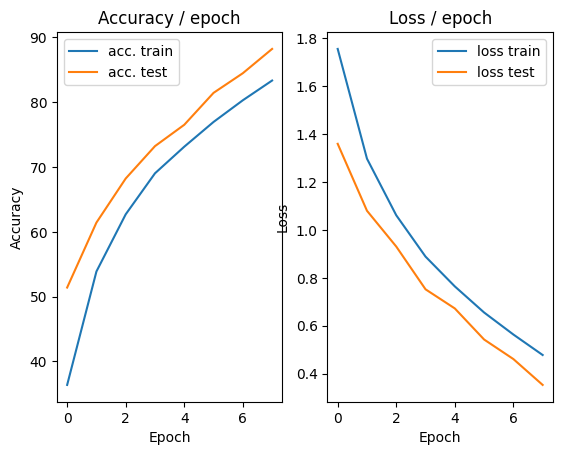

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.3518 (0.3518)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)


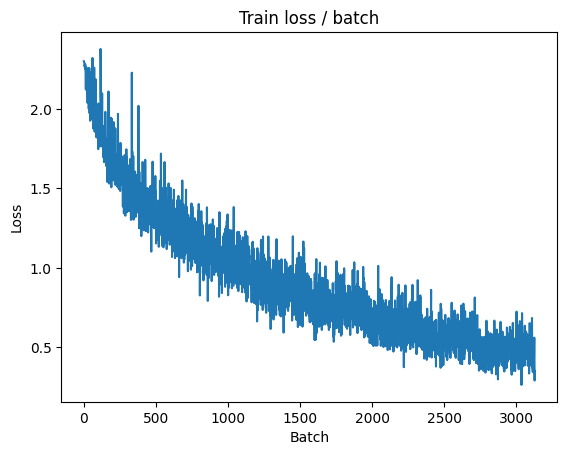

[TRAIN Batch 200/391]	Time 0.096s (0.036s)	Loss 0.3252 (0.3867)	Prec@1  89.8 ( 86.6)	Prec@5 100.0 ( 99.6)


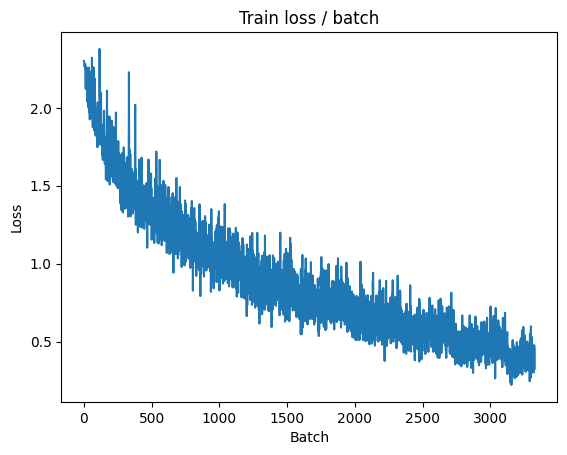


===============> Total time 14s	Avg loss 0.4004	Avg Prec@1 86.05 %	Avg Prec@5 99.61 %

[EVAL Batch 000/391]	Time 0.139s (0.139s)	Loss 0.2576 (0.2576)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.104s (0.035s)	Loss 0.3747 (0.3059)	Prec@1  85.9 ( 90.3)	Prec@5  99.2 ( 99.8)

===============> Total time 12s	Avg loss 0.3035	Avg Prec@1 90.21 %	Avg Prec@5 99.81 %



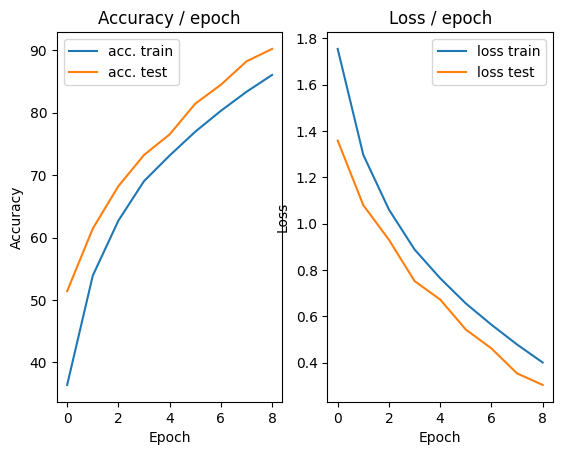

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 0.3906 (0.3906)	Prec@1  87.5 ( 87.5)	Prec@5  98.4 ( 98.4)


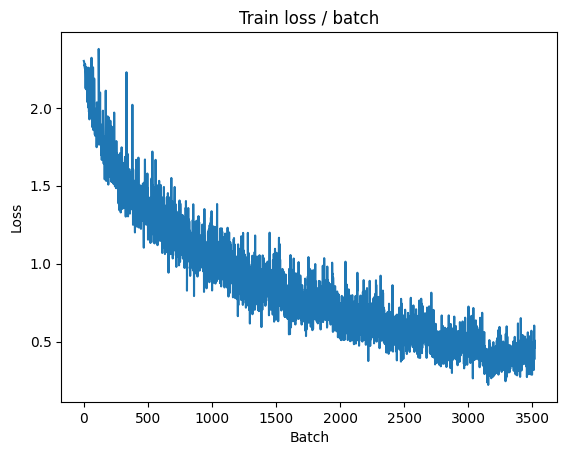

[TRAIN Batch 200/391]	Time 0.019s (0.040s)	Loss 0.2489 (0.3175)	Prec@1  93.0 ( 88.9)	Prec@5 100.0 ( 99.8)


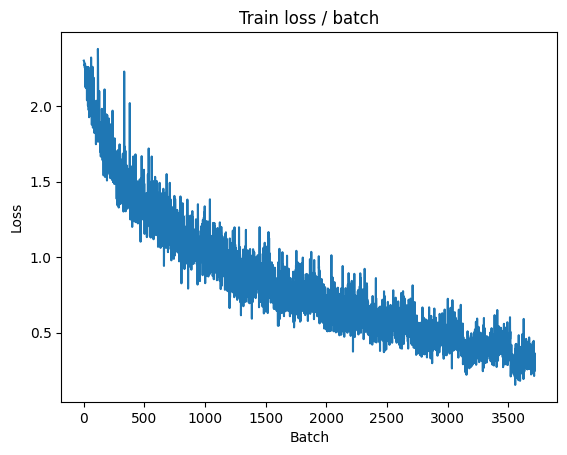


===============> Total time 14s	Avg loss 0.3253	Avg Prec@1 88.66 %	Avg Prec@5 99.77 %

[EVAL Batch 000/391]	Time 0.144s (0.144s)	Loss 0.2299 (0.2299)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.027s (0.036s)	Loss 0.3887 (0.3118)	Prec@1  83.6 ( 88.6)	Prec@5 100.0 ( 99.9)

===============> Total time 12s	Avg loss 0.3114	Avg Prec@1 88.73 %	Avg Prec@5 99.88 %



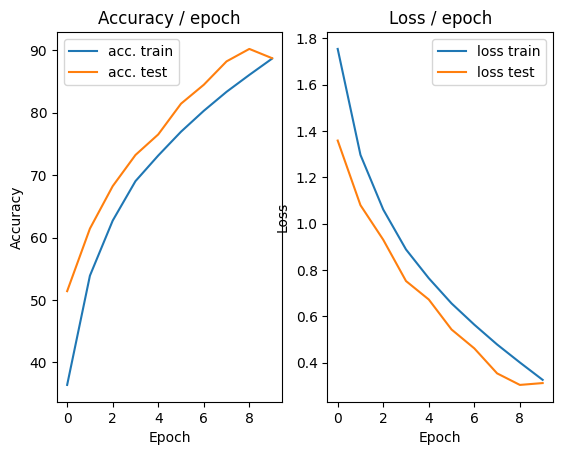

In [13]:
model= CIFAR10_ConvNet_Dropouted()
main_scheduler(model,batch_size=128,lr=0.1,epochs=10,cuda=True,get_data=get_dataset_normalized)

## Use of batch normalization

In [14]:
class CIFAR10_ConvNet_BatchNorm(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(CIFAR10_ConvNet_BatchNorm, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0,ceil_mode=True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.370s (0.370s)	Loss 2.3691 (2.3691)	Prec@1  10.2 ( 10.2)	Prec@5  51.6 ( 51.6)


<Figure size 640x480 with 0 Axes>

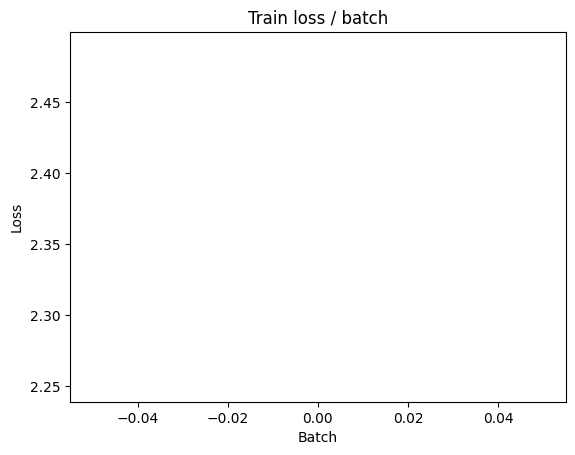

[TRAIN Batch 200/391]	Time 0.023s (0.040s)	Loss 1.1397 (1.4529)	Prec@1  60.2 ( 47.2)	Prec@5  96.9 ( 91.6)


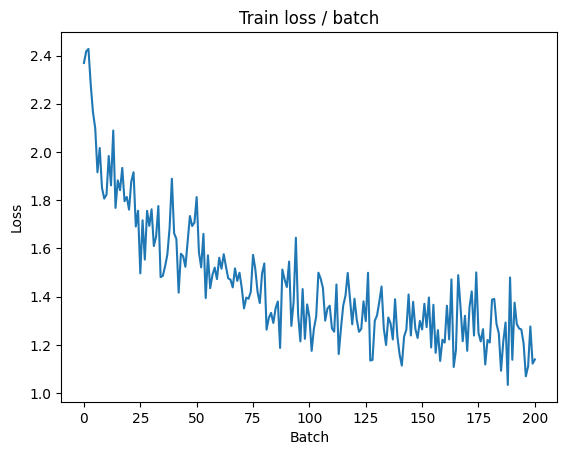


===============> Total time 15s	Avg loss 1.2716	Avg Prec@1 54.04 %	Avg Prec@5 93.85 %

[EVAL Batch 000/391]	Time 0.141s (0.141s)	Loss 0.8748 (0.8748)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)
[EVAL Batch 200/391]	Time 0.003s (0.029s)	Loss 1.0308 (0.9720)	Prec@1  65.6 ( 65.5)	Prec@5  96.1 ( 97.0)

===============> Total time 12s	Avg loss 0.9716	Avg Prec@1 65.57 %	Avg Prec@5 96.90 %



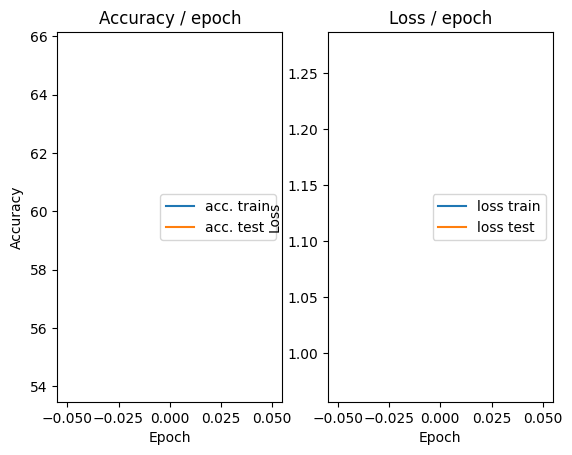

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 1.0770 (1.0770)	Prec@1  58.6 ( 58.6)	Prec@5  96.9 ( 96.9)


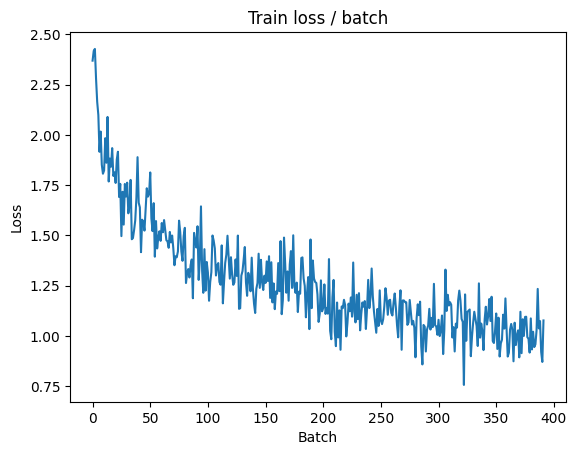

[TRAIN Batch 200/391]	Time 0.057s (0.034s)	Loss 0.9914 (0.8501)	Prec@1  62.5 ( 70.1)	Prec@5  97.7 ( 97.8)


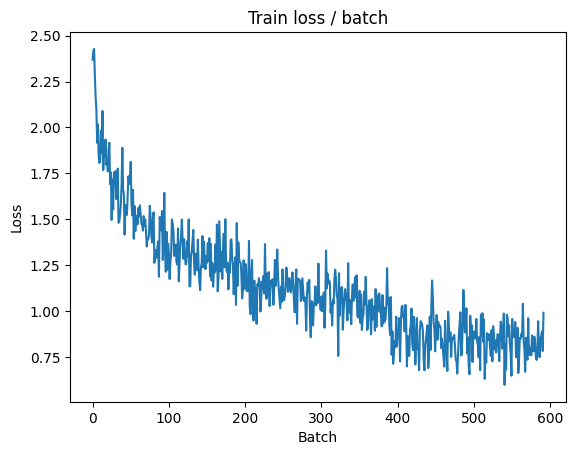


===============> Total time 14s	Avg loss 0.8154	Avg Prec@1 71.29 %	Avg Prec@5 97.98 %

[EVAL Batch 000/391]	Time 0.135s (0.135s)	Loss 0.5640 (0.5640)	Prec@1  79.7 ( 79.7)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.025s (0.030s)	Loss 0.7656 (0.6599)	Prec@1  73.4 ( 76.5)	Prec@5  99.2 ( 98.8)

===============> Total time 12s	Avg loss 0.6609	Avg Prec@1 76.57 %	Avg Prec@5 98.85 %



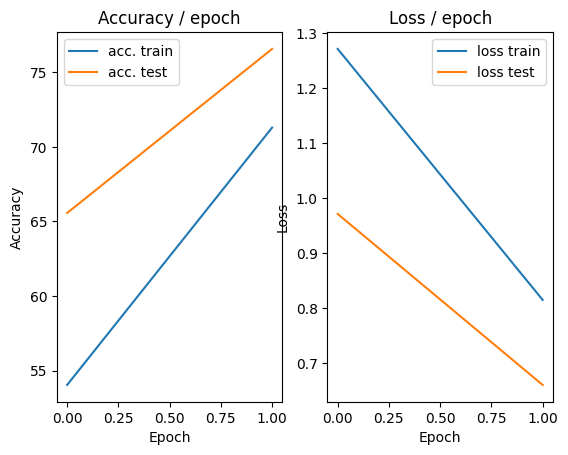

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.6082 (0.6082)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


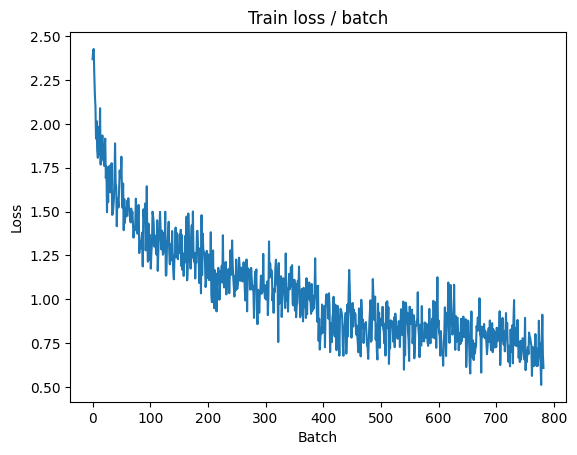

[TRAIN Batch 200/391]	Time 0.043s (0.034s)	Loss 0.3966 (0.6129)	Prec@1  85.2 ( 78.4)	Prec@5 100.0 ( 99.0)


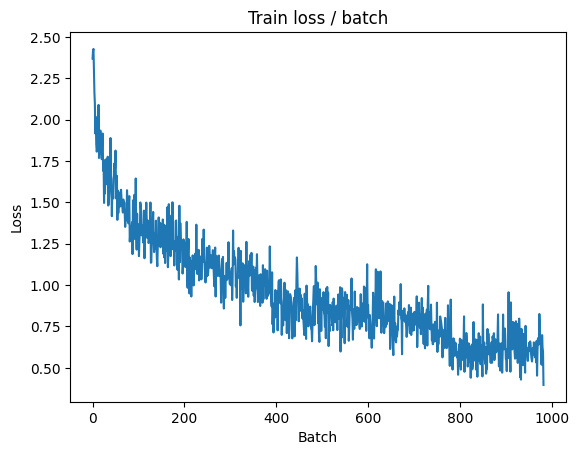


===============> Total time 14s	Avg loss 0.6108	Avg Prec@1 78.69 %	Avg Prec@5 98.89 %

[EVAL Batch 000/391]	Time 0.135s (0.135s)	Loss 0.4172 (0.4172)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.004s (0.029s)	Loss 0.5632 (0.4593)	Prec@1  81.2 ( 84.5)	Prec@5  98.4 ( 99.4)

===============> Total time 12s	Avg loss 0.4580	Avg Prec@1 84.61 %	Avg Prec@5 99.44 %



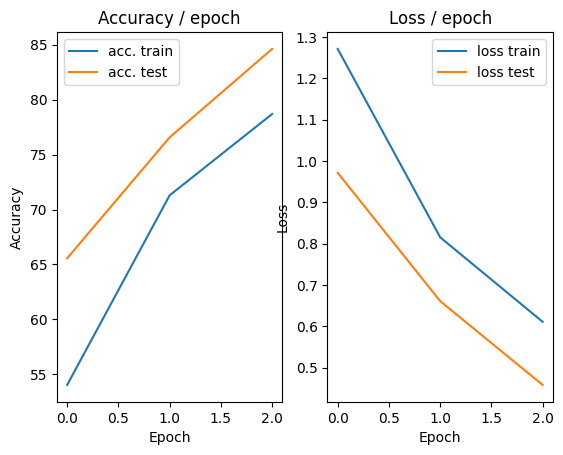

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.161s (0.161s)	Loss 0.3968 (0.3968)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


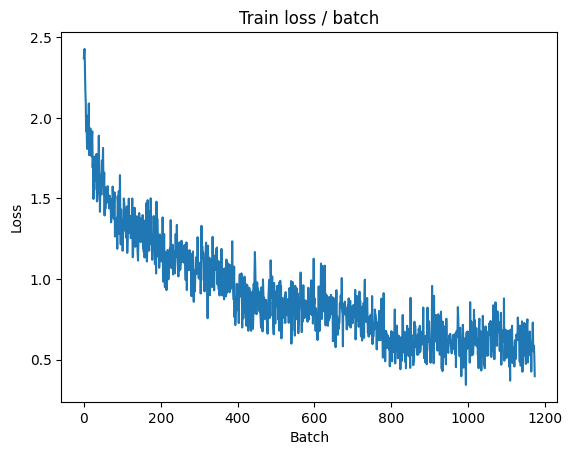

[TRAIN Batch 200/391]	Time 0.027s (0.038s)	Loss 0.3444 (0.4446)	Prec@1  88.3 ( 84.9)	Prec@5  99.2 ( 99.4)


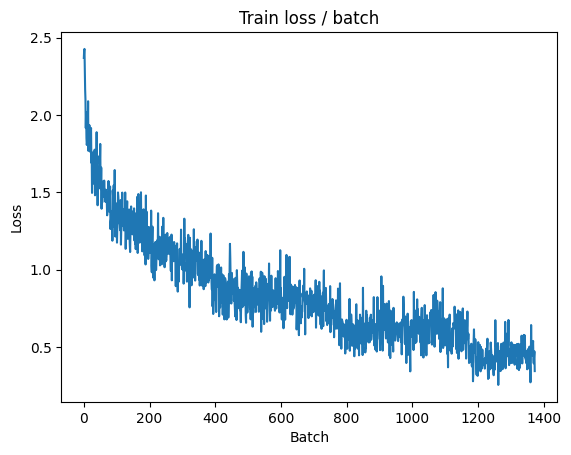


===============> Total time 14s	Avg loss 0.4540	Avg Prec@1 84.46 %	Avg Prec@5 99.38 %

[EVAL Batch 000/391]	Time 0.160s (0.160s)	Loss 0.3301 (0.3301)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.063s (0.035s)	Loss 0.4557 (0.3608)	Prec@1  85.9 ( 88.1)	Prec@5  98.4 ( 99.6)

===============> Total time 12s	Avg loss 0.3652	Avg Prec@1 87.89 %	Avg Prec@5 99.64 %



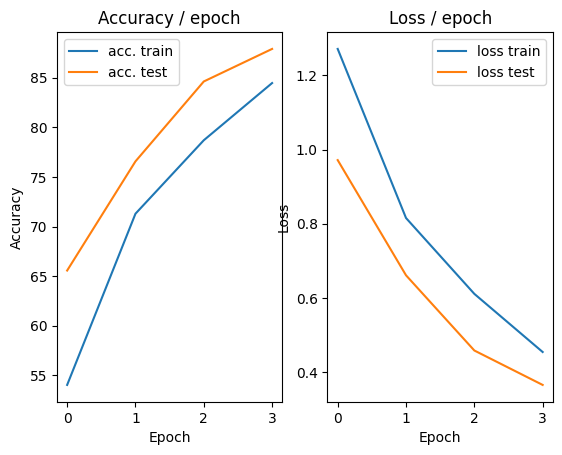

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.4282 (0.4282)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)


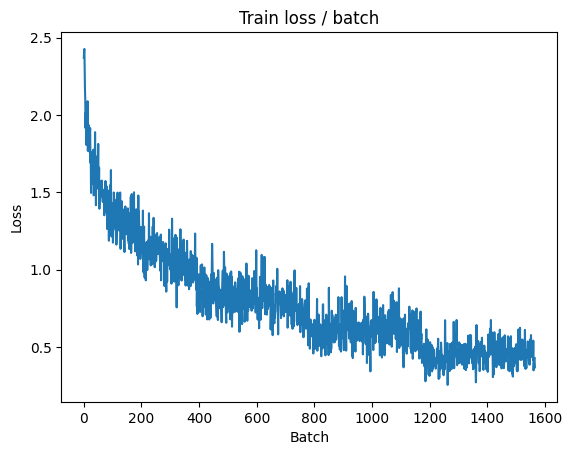

[TRAIN Batch 200/391]	Time 0.010s (0.039s)	Loss 0.3152 (0.3087)	Prec@1  89.1 ( 89.8)	Prec@5  99.2 ( 99.8)


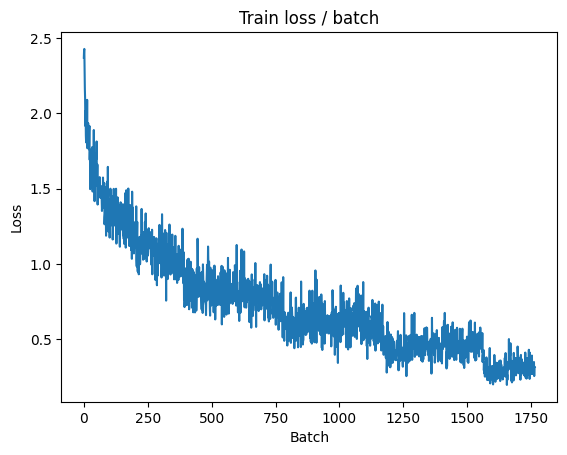


===============> Total time 14s	Avg loss 0.3230	Avg Prec@1 89.05 %	Avg Prec@5 99.73 %

[EVAL Batch 000/391]	Time 0.146s (0.146s)	Loss 0.2280 (0.2280)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.047s (0.036s)	Loss 0.2151 (0.2373)	Prec@1  94.5 ( 92.5)	Prec@5 100.0 ( 99.9)

===============> Total time 12s	Avg loss 0.2378	Avg Prec@1 92.44 %	Avg Prec@5 99.88 %



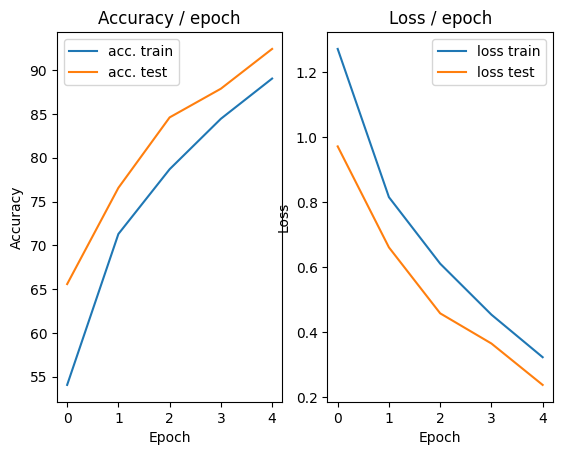

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 0.2612 (0.2612)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


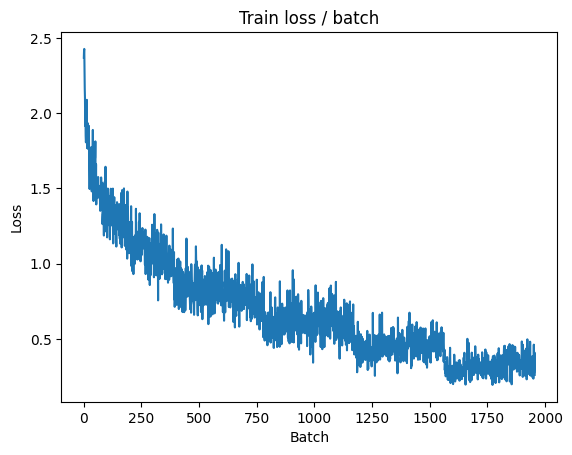

[TRAIN Batch 200/391]	Time 0.035s (0.040s)	Loss 0.2248 (0.1867)	Prec@1  92.2 ( 94.3)	Prec@5 100.0 ( 99.9)


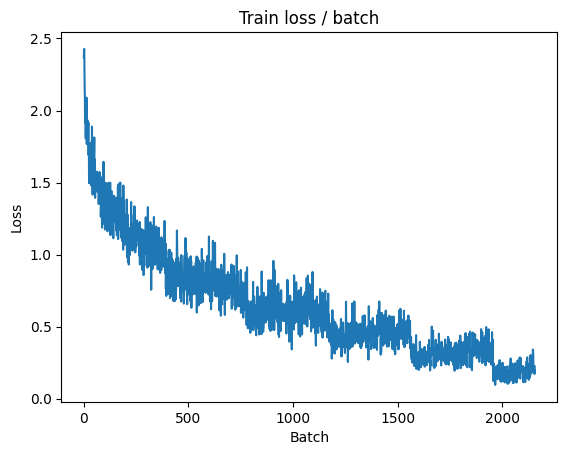


===============> Total time 14s	Avg loss 0.2063	Avg Prec@1 93.29 %	Avg Prec@5 99.87 %

[EVAL Batch 000/391]	Time 0.146s (0.146s)	Loss 0.1188 (0.1188)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.005s (0.036s)	Loss 0.1789 (0.1672)	Prec@1  94.5 ( 94.9)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.1680	Avg Prec@1 94.91 %	Avg Prec@5 99.97 %



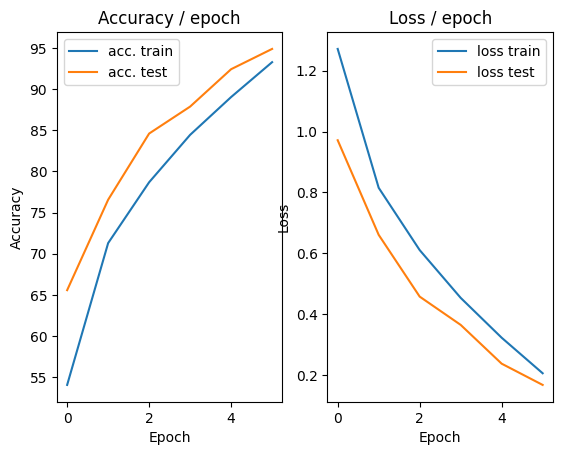

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.1185 (0.1185)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


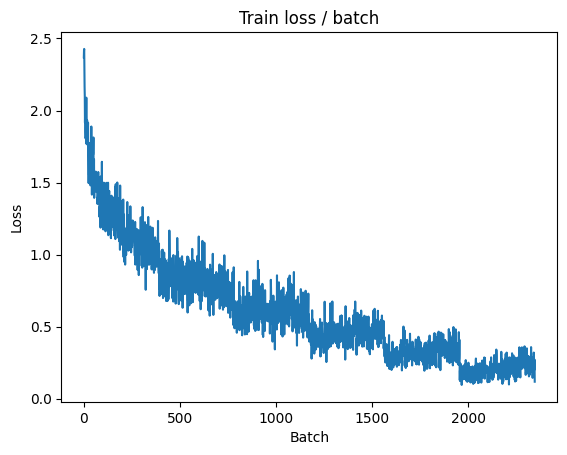

[TRAIN Batch 200/391]	Time 0.031s (0.039s)	Loss 0.0764 (0.1040)	Prec@1  98.4 ( 97.2)	Prec@5 100.0 (100.0)


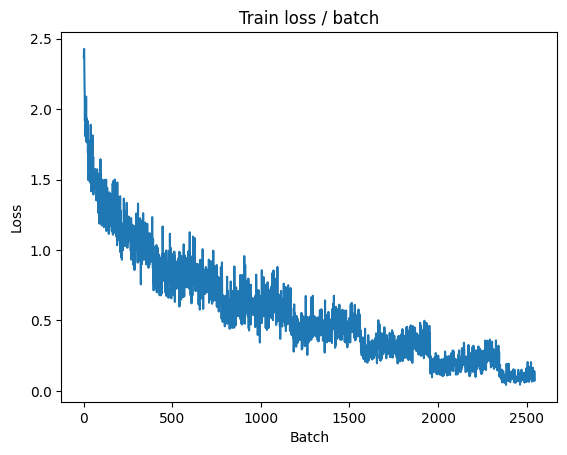


===============> Total time 14s	Avg loss 0.1126	Avg Prec@1 96.77 %	Avg Prec@5 99.98 %

[EVAL Batch 000/391]	Time 0.268s (0.268s)	Loss 0.0702 (0.0702)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.054s (0.032s)	Loss 0.0642 (0.0683)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.0673	Avg Prec@1 98.68 %	Avg Prec@5 100.00 %



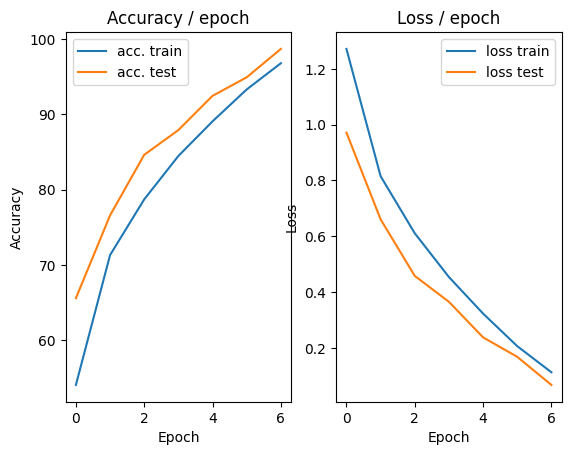

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.274s (0.274s)	Loss 0.0570 (0.0570)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


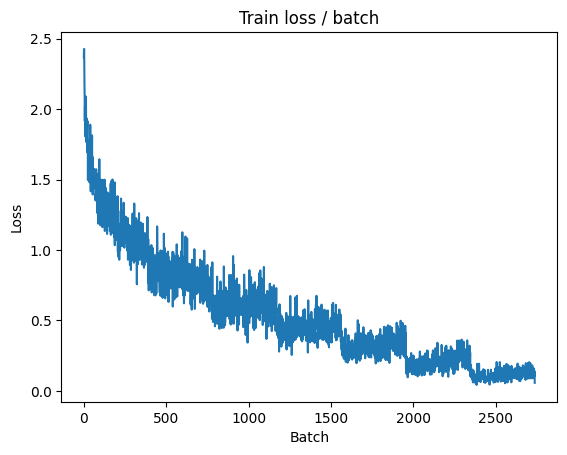

[TRAIN Batch 200/391]	Time 0.039s (0.035s)	Loss 0.0251 (0.0520)	Prec@1 100.0 ( 99.1)	Prec@5 100.0 (100.0)


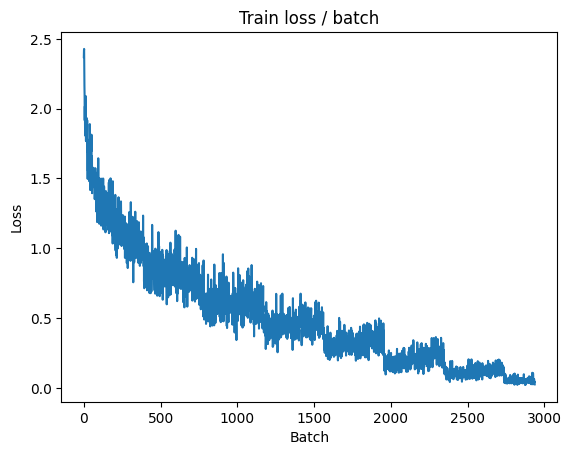


===============> Total time 14s	Avg loss 0.0516	Avg Prec@1 98.96 %	Avg Prec@5 100.00 %

[EVAL Batch 000/391]	Time 0.139s (0.139s)	Loss 0.0145 (0.0145)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.039s (0.030s)	Loss 0.0213 (0.0264)	Prec@1 100.0 ( 99.7)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.0263	Avg Prec@1 99.75 %	Avg Prec@5 100.00 %



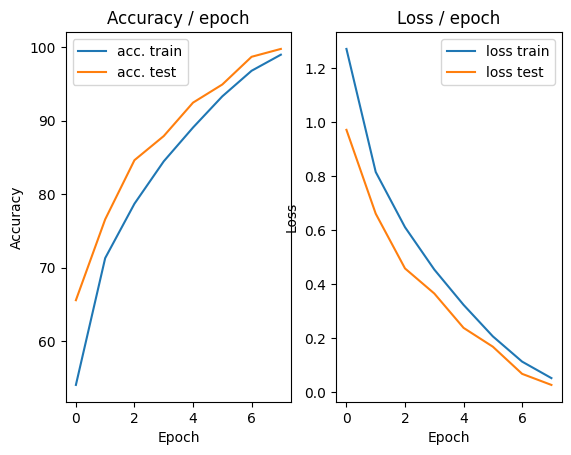

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0303 (0.0303)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


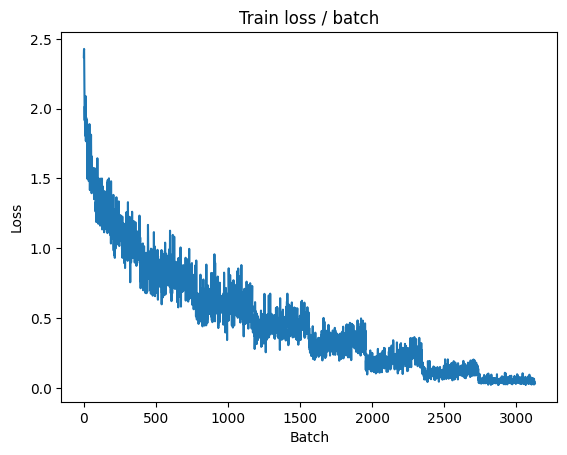

[TRAIN Batch 200/391]	Time 0.052s (0.034s)	Loss 0.0232 (0.0194)	Prec@1 100.0 ( 99.9)	Prec@5 100.0 (100.0)


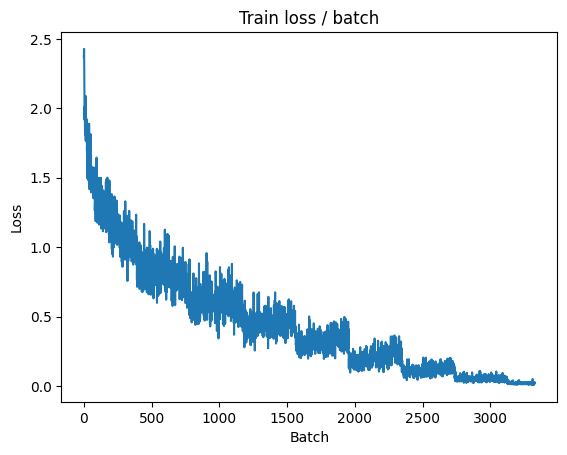


===============> Total time 14s	Avg loss 0.0194	Avg Prec@1 99.86 %	Avg Prec@5 100.00 %

[EVAL Batch 000/391]	Time 0.176s (0.176s)	Loss 0.0111 (0.0111)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.039s (0.030s)	Loss 0.0368 (0.0168)	Prec@1  99.2 ( 99.9)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.0172	Avg Prec@1 99.85 %	Avg Prec@5 100.00 %



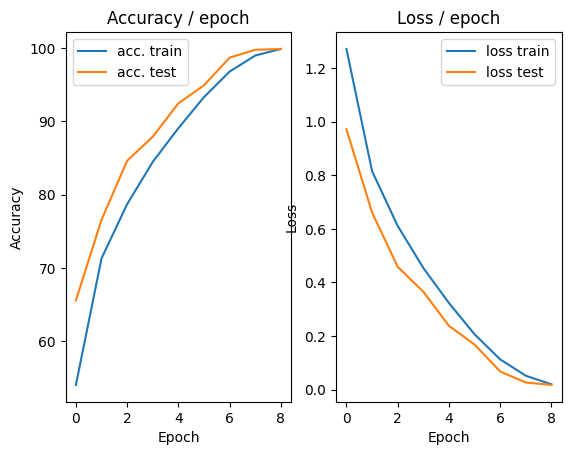

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.0152 (0.0152)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


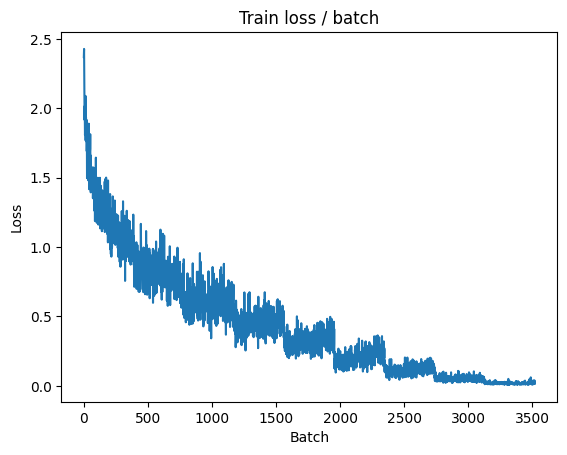

[TRAIN Batch 200/391]	Time 0.038s (0.035s)	Loss 0.0059 (0.0089)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


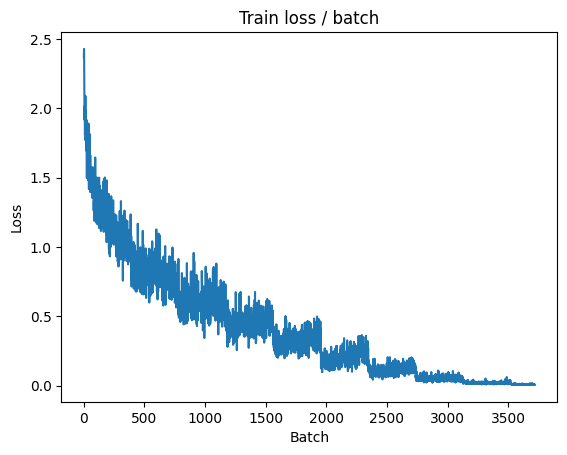


===============> Total time 14s	Avg loss 0.0087	Avg Prec@1 99.99 %	Avg Prec@5 100.00 %

[EVAL Batch 000/391]	Time 0.140s (0.140s)	Loss 0.0023 (0.0023)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)
[EVAL Batch 200/391]	Time 0.005s (0.031s)	Loss 0.0056 (0.0044)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 12s	Avg loss 0.0044	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %



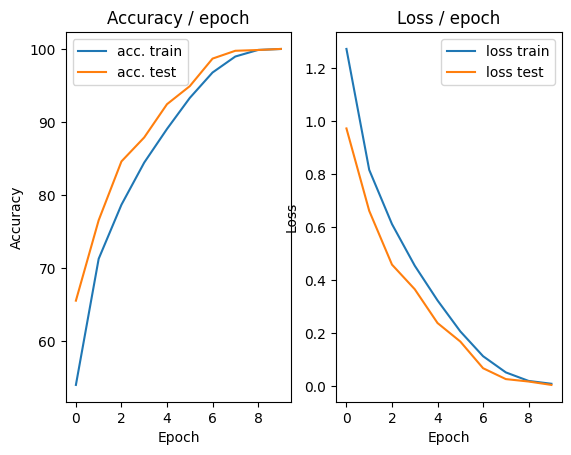

In [15]:
model= CIFAR10_ConvNet_BatchNorm()
main_scheduler(model,batch_size=128,lr=0.1,epochs=10,cuda=True,get_data=get_dataset_normalized)